#Import Librairies & Dataset

In [161]:
# General libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For basic visualizations
import seaborn as sns  # For advanced visualizations
from scipy.stats import f_oneway
from pandas.plotting import parallel_coordinates
from matplotlib import cm

# Data preparation and transformation
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit  # For splitting and cross-validation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder, TargetEncoder  # For scaling and encoding
from sklearn.compose import ColumnTransformer  # For column-specific transformations
from sklearn.pipeline import Pipeline, make_pipeline  # For creating data pipelines
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Machine learning models

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet  # Linear models
from sklearn.neighbors import KNeighborsRegressor  # k-Nearest Neighbors for regression
from sklearn.svm import SVR  # Support Vector Regression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor  # Ensemble models
from xgboost import XGBRegressor  # Extreme Gradient Boosting (XGBoost)

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # For hyperparameter optimization

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Metrics for regression evaluation

# External library (specific purpose)
import kagglehub  # Kaggle-related functionality
from scipy.stats import shapiro, kstest, normaltest






---
*Dataset Import*

---

In [162]:
path = kagglehub.dataset_download("deepcontractor/car-price-prediction-challenge")
print("Path to dataset files:", path)
df = pd.read_csv(str(path)+"/car_price_prediction.csv")

Path to dataset files: /root/.cache/kagglehub/datasets/deepcontractor/car-price-prediction-challenge/versions/1


#About the Dataset

In [163]:
target = df['Price']
df = df.drop('Price', axis=1)

---
Let's have a general idea of the dataset

---

In [164]:
df.head(n=2)

ID  Levy Manufacturer    Model  Prod. year Category Leather interior  \
0  45654403  1399        LEXUS   RX 450        2010     Jeep              Yes   
1  44731507  1018    CHEVROLET  Equinox        2011     Jeep               No   

  Fuel type Engine volume    Mileage  Cylinders Gear box type Drive wheels  \
0    Hybrid           3.5  186005 km        6.0     Automatic          4x4   
1    Petrol             3  192000 km        6.0     Tiptronic          4x4   

    Doors       Wheel   Color  Airbags  
0  04-May  Left wheel  Silver       12  
1  04-May  Left wheel   Black        8

---
We can see 17 features we will investigate further. First we can see some categorical features like the gear box type which can be Automatic, Tiptronic for instance. Besides we can notice Mileage is followed by its units kilometers which must be removed. Below you can get more details about the features' definitions.

---

---
Let's describe the features:



1.   ID: Unique identifier for each car
2.   A Levy (additional tax or fee) that may affect the car's price
3.   Manufacturer: The brand or make of the car (e.g., LEXUS, HONDA, FORD).
4.   Model: The model name of the car.
5.   Prod. Year: The year the car was manufactured.
6.   Category: The type of car (e.g., Jeep, Hatchback, Sedan).
7.   Leather Interior: Indicates whether the car has leather interior (Yes or No).
8. Fuel Type: The type of fuel the car uses (e.g., Petrol, Hybrid, Diesel).
9.   Engine Volume: The volume of the car's engine in liters (e.g., 3.5, 2.0).
10.   Mileage: The total distance the car has traveled (recorded in kilometers).
11. Cylinders: The number of cylinders in the engine.
12. Gear Box Type: The type of transmission (e.g., Automatic, Tiptronic, Variator).
13. Drive Wheels: The car's drivetrain system (e.g., 4x4, Front, Rear).
14. Doors: The number of doors on the car (commonly 2, 4, or 5).
15. Wheel: Whether the car is left or right-hand drive.
16. Color: The exterior color of the car.
17. Airbags: The number of airbags installed in the car.

---






In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Levy              19237 non-null  object 
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  object 
 9   Mileage           19237 non-null  object 
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  object 
 14  Wheel             19237 non-null  object 
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

---
At first sight, there appear to be 4 numerical and 13 categorical features.

---

In [166]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

print(f" The numerical features are {numerical_features}")
print(f"The categorical features are {categorical_features}")

 The numerical features are ['ID', 'Prod. year', 'Cylinders', 'Airbags']
The categorical features are ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']


---
Engine Volume, Mileage and Levy must be numerical features while the ID column should be remove as it does not contain any interpretable information.

---

# Preprocessing

---
In this section we do the preprocessing

---  


####**Numerical Features - Preprocessing**

######**Engine Volume**

In [167]:
df['Engine volume'].iloc[23:27]

23    2.0 Turbo
24          1.8
25    2.2 Turbo
26          4.7
Name: Engine volume, dtype: object

---
We decided to turn the engine volume into numbers. We also need to remove the string 'Turbo'.

---

In [168]:
df['Engine volume'] = df['Engine volume'].str.replace(' Turbo', '').astype(float)


######**Mileage**

In [169]:
df['Mileage'].head(2)
df['Mileage'] = df['Mileage'].str.replace(' km', '').str.replace(' ', '').astype(float)

---

We remove the units from Mileage to convert it into numerical values.

---

######**Levy**

In [171]:
df['Levy'].head(2)
df['Levy'] = df['Levy'].replace('-', 0).astype(float)

---

We interpret the symbol '-' as indicating no tax, rather than 'nan', which would have been used otherwise. Although we acknowledge that some cars had no regulations in the past, but the models will consider both 'Age' and 'Levy' features, so this approach is acceptable. Additionally, we convert 'Levy' into numerical values since it represents tax fees.  

---

######**ID**

In [172]:
df.drop('ID', axis=1, inplace=True)
df.head(2)

Levy Manufacturer    Model  Prod. year Category Leather interior  \
0  1399.0        LEXUS   RX 450        2010     Jeep              Yes   
1  1018.0    CHEVROLET  Equinox        2011     Jeep               No   

  Fuel type  Engine volume   Mileage  Cylinders Gear box type Drive wheels  \
0    Hybrid            3.5  186005.0        6.0     Automatic          4x4   
1    Petrol            3.0  192000.0        6.0     Tiptronic          4x4   

    Doors       Wheel   Color  Airbags  
0  04-May  Left wheel  Silver       12  
1  04-May  Left wheel   Black        8

---
The ID is unique and does not bring us any interpretable informaton. We remove the entire column.

---

######**Age Rather than Prod.year**

In [173]:
df['Age'] = 2024 - df['Prod. year']
df.drop('Prod. year', axis=1, inplace=True)

---

It is easier for our interpretation to know the Age of the car rather than its year of production. What is more we drop the entire column as it is a linear transformation of the Production year (the correlation is -1)

---

######**Doors**

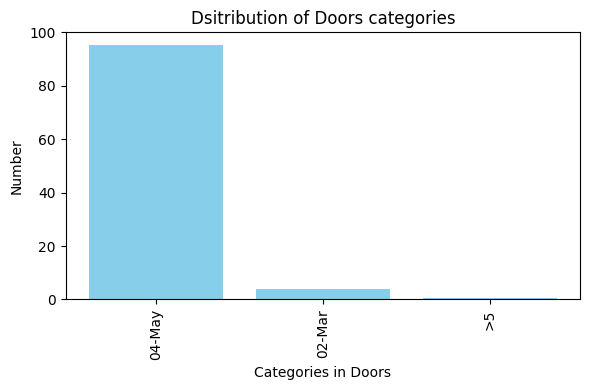

In [174]:
category_counts = df['Doors'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(category_counts.index, 100*category_counts/len(df['Doors']), color='skyblue')
plt.xlabel('Categories in Doors')
plt.ylabel('Number')
plt.title(f"Dsitribution of Doors categories")
plt.xticks(rotation=90)  # Tourne les labels de 90 degrés
plt.tight_layout()
plt.show()

In [175]:
df['Doors'] = df['Doors'].replace({'04-May': 4, '02-Mar': 2, '>5': 6})

df['Doors'] = df['Doors'].astype(int)

df['Doors'].head(2)

df.drop('Doors', axis=1, inplace=True)
df.head(2)

<ipython-input-175-db957d473174>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Doors'] = df['Doors'].replace({'04-May': 4, '02-Mar': 2, '>5': 6})


Levy Manufacturer    Model Category Leather interior Fuel type  \
0  1399.0        LEXUS   RX 450     Jeep              Yes    Hybrid   
1  1018.0    CHEVROLET  Equinox     Jeep               No    Petrol   

   Engine volume   Mileage  Cylinders Gear box type Drive wheels       Wheel  \
0            3.5  186005.0        6.0     Automatic          4x4  Left wheel   
1            3.0  192000.0        6.0     Tiptronic          4x4  Left wheel   

    Color  Airbags  Age  
0  Silver       12   14  
1   Black        8   13

---
We think there is a positive correlation between the number of doors and the price as the more you have doors the more it is expensive. However we see it is not interesting enough to keep it as regards to the distribution above showing 3 categories including 2 unfrequent.

---

######**Missing Values and Duplicates**

In [176]:
print(df.isnull().sum())

Levy                0
Manufacturer        0
Model               0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Wheel               0
Color               0
Airbags             0
Age                 0
dtype: int64


---
There is no missing values

---

In [177]:
print(df.duplicated().sum()) # Numbers of Duplicates

3774


---
There are 3774 duplicates we will remove later as we need to analyse further to see if all the features are interesting enough to be kept.

---

####**Categorical Encoding - Preprocessor**

In [178]:
numerical_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

print(f" The numerical features are {numerical_features}")
print(f"The categorical features are {categorical_features}")

 The numerical features are ['Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'Age']
The categorical features are ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']


In [179]:
unique_counts = {col: len(df[col].unique()) for col in categorical_features}
print(unique_counts)

{'Manufacturer': 65, 'Model': 1590, 'Category': 11, 'Leather interior': 2, 'Fuel type': 7, 'Gear box type': 4, 'Drive wheels': 3, 'Wheel': 2, 'Color': 16}



---
We think it is a bad idea to use one hot encoding on Model and Manufacturer as there are too many different categories. Let's Try using another method available within the sklearn librairy : TargetEncoding. However to do so, we think it is better to do it during the pipeline

---


---

Below we define the pipelines that will be used. We have three strategies:

- Using One-hot Encoder alone to encode categorical features, but the inconvenients are to increase the dimension of the feature space a lot. To limit this effect we set up a limit to the number of categories (30).

- Using Target Encoder alone to encode categorical features. This technique encodes each category using the average target for that particular category (some smoothing technique are also used to avoid overfitting but the principle remains using the average target).

- Using a combination of Target and one-hot encoding. We only use target encoding on 'Model' and 'Manufacturer' as they have too many categories.


---


#####**One Hot Encoding - Preprocessor**

In [180]:
categorical_features_copy = categorical_features.copy()
categorical_onehot_encoding = categorical_features_copy  # Columns for One-Hot Encoding
numerical_features = numerical_features  # Numerical Columns

# Defining Transformations
onehot_encoding_transformer = OneHotEncoder(handle_unknown='ignore', max_categories = 30) # Max 20 categories
scaling_transformer = StandardScaler()

# Creating a ColumnTransformer
preprocessor_onehot_encoding = ColumnTransformer(
    transformers=[
        ('onehot_encoding', onehot_encoding_transformer, categorical_onehot_encoding),
        ('scaling', scaling_transformer, numerical_features),
    ])

X_processed = preprocessor_onehot_encoding.fit_transform(df, target)
print(f"The type of X_processed is {type(X_processed)}")
print(f"The shape of X_processed is {X_processed.shape}")
print(f"The sum of unique values is {sum(unique_counts.values())}")
print(f"The number of columns in X_processed is {X_processed.shape[1]} and is different from the sum of unique values {sum(unique_counts.values())}")

The type of X_processed is <class 'scipy.sparse._csr.csr_matrix'>
The shape of X_processed is (19237, 111)
The sum of unique values is 1700
The number of columns in X_processed is 111 and is different from the sum of unique values 1700


#####**Target Encoding - Preprocessor**

In [ ]:
# Defining transformations
target_encoding_transformer = TargetEncoder(cv=3,target_type='continuous')
scaling_transformer = StandardScaler()

# Creating a ColumnTransformer
preprocessor_target_encoding = ColumnTransformer(
    transformers=[
        ('target_encoding', target_encoding_transformer, categorical_features),
        ('scaling', scaling_transformer, numerical_features),
    ])

X_processed = preprocessor_target_encoding.fit_transform(df, target)
print(f"The type of X_processed is {type(X_processed)}")
print(f"The shape of X_processed is {X_processed.shape}")
print(f"The sum of unique values is {sum(unique_counts.values())}")
print(f"The number of columns in X_processed is {X_processed.shape[1]} and is different from the sum of unique values {sum(unique_counts.values())}")

The type of X_processed is <class 'numpy.ndarray'>
The shape of X_processed is (19237, 15)
The sum of unique values is 1700
The number of columns in X_processed is 15 and is different from the sum of unique values 1700


#####**Mixed Target Encoding & One-Hot Encoding - Preprocessor**

In [ ]:
categorical_features_copy = categorical_features.copy()
categorical_target_encoding = ['Model','Manufacturer']  # Columns for Target Encoding
for col in categorical_target_encoding:
  categorical_features_copy.remove(col)   # Columns for target_encoding has to be removed

categorical_onehot_encoding = categorical_features_copy  # Columns for One-Hot Encoding
numerical_features = numerical_features  # Numerical Columns

preprocessor_mixed_onehot_target = ColumnTransformer(
    transformers=[
        ('target_encoding', TargetEncoder(cv=3,target_type='continuous'), categorical_target_encoding),
        ('onehot_encoding', OneHotEncoder(handle_unknown='ignore', max_categories = 30), categorical_onehot_encoding),
        ('scaling', StandardScaler(), numerical_features),
    ])

X_processed = preprocessor_mixed_onehot_target.fit_transform(df, target)
print(f"The type of X_processed is {type(X_processed)}")
print(f"The shape of X_processed is {X_processed.shape}")
print(f"The sum of unique values is {sum(unique_counts.values())}")
print(f"The number of columns in X_processed is {X_processed.shape[1]} and is different from the sum of unique values {sum(unique_counts.values())}")


The type of X_processed is <class 'scipy.sparse._csr.csr_matrix'>
The shape of X_processed is (19237, 53)
The sum of unique values is 1700
The number of columns in X_processed is 53 and is different from the sum of unique values 1700


#Dataset Exploratory Analysis

---
Reference for outliers: Since the statistics within the dataset will change as we progressively remove outliers column by column.

---

In [ ]:
df_copy_outliers = df.copy()
target_copy_outliers = target.copy()

#####**Numerical Features**

In [181]:
df_describe = df.copy()
df_describe['Price'] = target
df_describe.describe()

Levy  Engine volume       Mileage     Cylinders       Airbags  \
count  19237.000000   19237.000000  1.923700e+04  19237.000000  19237.000000   
mean     632.528669       2.307990  1.532236e+06      4.582991      6.582627   
std      567.721688       0.877805  4.840387e+07      1.199933      4.320168   
min        0.000000       0.000000  0.000000e+00      1.000000      0.000000   
25%        0.000000       1.800000  7.013900e+04      4.000000      4.000000   
50%      642.000000       2.000000  1.260000e+05      4.000000      6.000000   
75%      917.000000       2.500000  1.888880e+05      4.000000     12.000000   
max    11714.000000      20.000000  2.147484e+09     16.000000     16.000000   

                Age         Price  
count  19237.000000  1.923700e+04  
mean      13.087176  1.855593e+04  
std        5.668673  1.905813e+05  
min        4.000000  1.000000e+00  
25%        9.000000  5.331000e+03  
50%       12.000000  1.317200e+04  
75%       15.000000  2.207500e+04  
max       85.000000  2.630750e+07

---

On average, a car is 13 years old, which is old for a car. We estimates it is a little bit disconcerting to see an average price of 12000 even if we do not know the currency. That is why we are going to treat some outliers which appears at first sight on Mileage whose maximum is 2.10^9 km, which is normally impossible. We will take a closer look to each distribution. 18000

---

---
function which calculate outliers based on a lower and upper bound defined by quartiles and the gap between them.

---


In [182]:
def calculate_outliers_Q1_Q3(reference_data_column,data_column):
    Q1 = reference_data_column.quantile(0.25)
    Q3 = reference_data_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data_column < lower_bound) | (data_column > upper_bound)
    num_outliers = np.sum(outliers)
    print(f'New Number of outliers: {num_outliers}')
    print(f'New Number of outliers stands for: {100*num_outliers/len(reference_data_column)} % of the dataset')
    print('********')
    print(f"Lower Bound : {lower_bound}")
    print(f"Upper Bound : {upper_bound}")
    return outliers

######**Price**

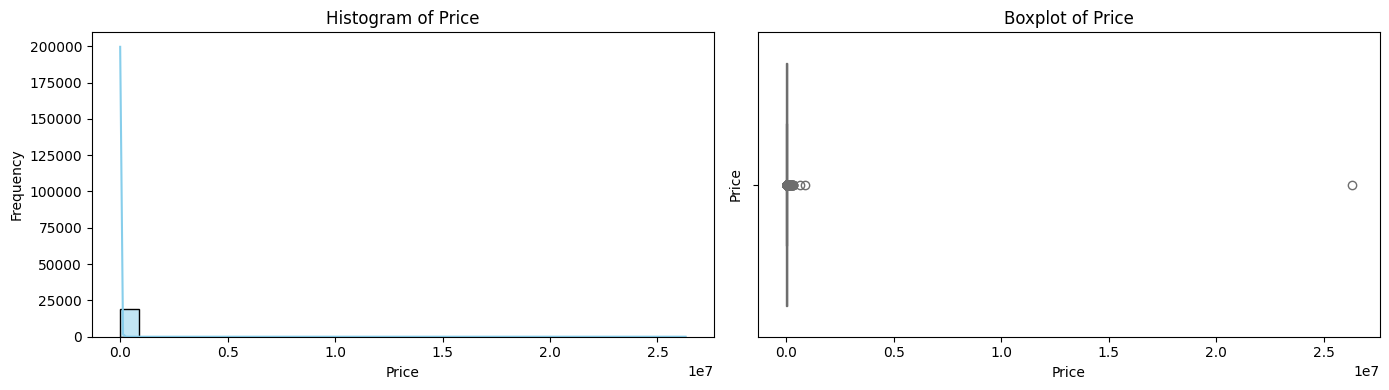

In [183]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(target, bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=target, color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Price')
axes[1].set_ylabel('Price')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [184]:
# Remove outliers of price from the DataFrame
outliers_price = calculate_outliers_Q1_Q3(target_copy_outliers,target)



New Number of outliers: 1073
New Number of outliers stands for: 5.577792795134377 % of the dataset
********
Lower Bound : -19785.0
Upper Bound : 47191.0


---
We can see there are 1073 outliers if we use the IQR Method. However we decided to adapt the positive threshold since the underlying distribution of price is not gaussian (as we will see it later), the method IQR highlights too many outliers (5% of the dataset).

---

In [185]:
len(target_copy_outliers[target_copy_outliers>62000.0])

472

---
We choose to use 62000 as threshold

---

In [ ]:
# Our rules
our_outliers_price = (target < 0.0) | (target > 62000.0)

num_outliers_our = np.sum(our_outliers_price)
print(f'Number of outliers with our bound: {num_outliers_our}')
print(f'New Number of outliers stands for: {100*num_outliers_our/len(target_copy_outliers)} % of the initial dataset')

df = df[~our_outliers_price]
target = target[~our_outliers_price]

Number of outliers with our bound: 472
New Number of outliers stands for: 2.4536050319696416 % of the initial dataset


---
The number of outliers is now 2.5% of the dataset

---

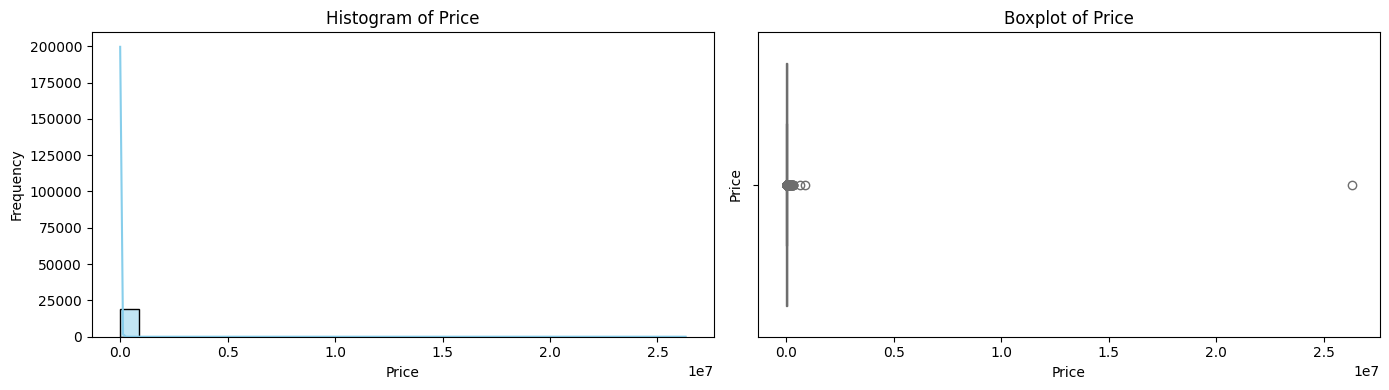

In [186]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(target, bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=target, color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Price')
axes[1].set_ylabel('Price')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---
The first we can notice is the bimodal distribution of price which has a positive skewness, very different from a gaussian distribution. On another we hesitated to remove the first bar whose number is very high. But we decided there were too many cars involved to consider them outliers or errors.


---

In [ ]:
len(target[target<=0])

0

---
No prices are negative which is great.

---

In [ ]:
len(target[target<=500])

1665

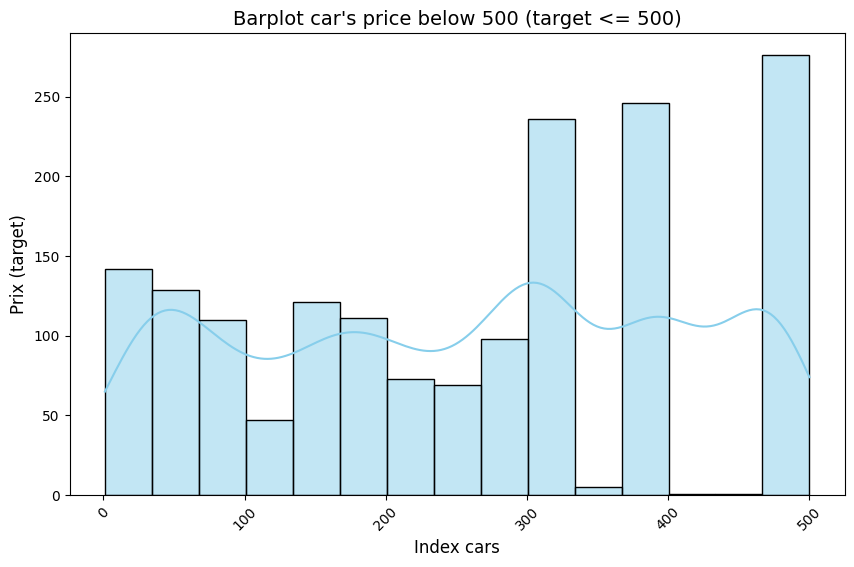

In [187]:
# Filtrer les voitures dont le prix (target) est <= 300
filtered_df = df[target <= 500]
filtered_target = target[target <= 500]

# Barplot pour les prix
plt.figure(figsize=(10, 6))
sns.histplot(filtered_target, bins=15, kde=True, color='skyblue')
plt.title("Barplot car's price below 500 (target <= 500)", fontsize=14)
plt.xlabel('Index cars', fontsize=12)
plt.ylabel('Prix (target)', fontsize=12)
plt.xticks(rotation=45)  # Rotation des labels pour une meilleure lisibilité si nécessaire
plt.show()

# Scatter plot pour le prix en fonction de Mileage
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x=filtered_df['Mileage'], y=filtered_target, color='blue', s=100)
#plt.title('Scatter plot : Prix en fonction de Mileage (target <= 500)', fontsize=14)
#plt.xlabel('Mileage', fontsize=12)
#plt.ylabel('Prix (target)', fontsize=12)
#plt.grid(True)
#plt.show()

In [ ]:
#df = df[target >= 500]
#target = target[target >= 500]

######**Engine**

Text(0.5, 0, 'Engine Volume')

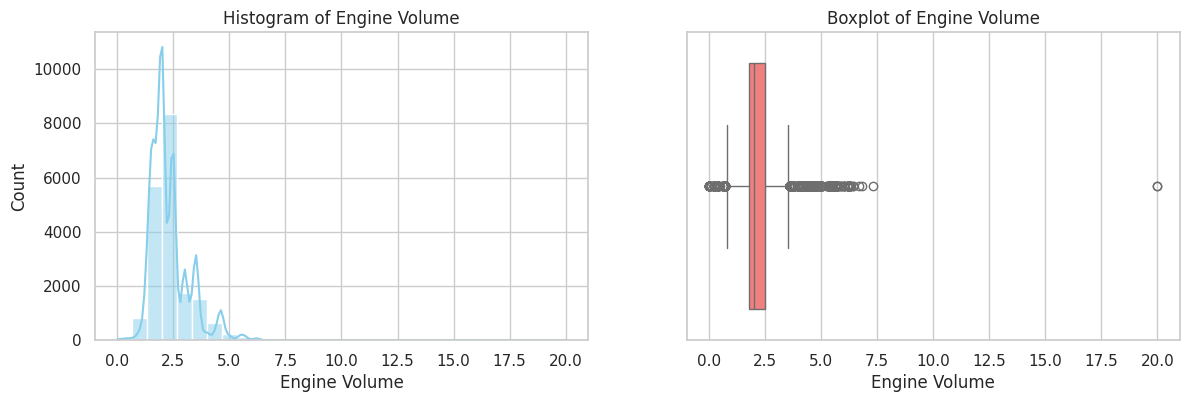

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Engine volume'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of Engine Volume')
ax[0].set_xlabel('Engine Volume')

sns.boxplot(x=df_copy_outliers['Engine volume'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of Engine Volume')
ax[1].set_xlabel('Engine Volume')





In [ ]:
# Remove outliers of price from the DataFrame
outliers_engine = calculate_outliers_Q1_Q3(df_copy_outliers['Engine volume'],df['Engine volume'])


New Number of outliers: 1259
New Number of outliers stands for: 6.544679523834278 % of the dataset
********
Lower Bound : 0.7500000000000002
Upper Bound : 3.55


---
We agree with the lower bound but we think it will be better to retain cars whose engine volume is at least 5 Liters after having consulted some articles on the subject.

---

In [ ]:
# Our rules
our_outliers_engine_volume = (df['Engine volume'] < 0.0) | (df['Engine volume'] > 5.0)

num_outliers_our = np.sum(our_outliers_engine_volume)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Engine volume'])} % of the initial dataset")

df = df[~our_outliers_engine_volume]
target = target[~our_outliers_engine_volume]

Number of outliers with our bound: 167
New Number of outliers stands for: 0.8681187295316317 % of the initial dataset


---
We dropped 167 outliers based on the Engine Volume

---

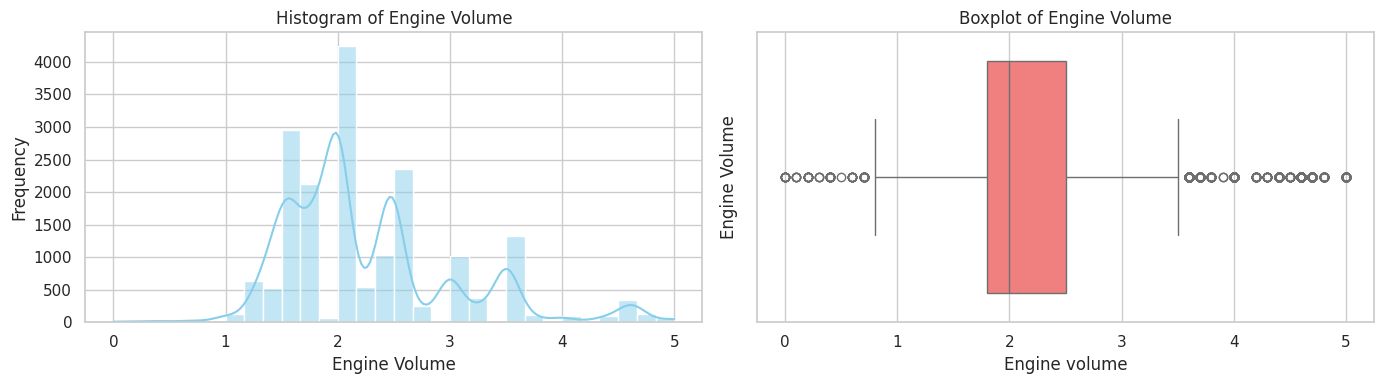

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Engine volume'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Engine Volume')
axes[0].set_xlabel('Engine Volume')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Engine volume'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Engine Volume')
axes[1].set_ylabel('Engine Volume')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---
The distribution is sparse in certain regions. This must be owing to the technology that exists on the market.

---

######**Age**

Text(0.5, 0, 'Age')

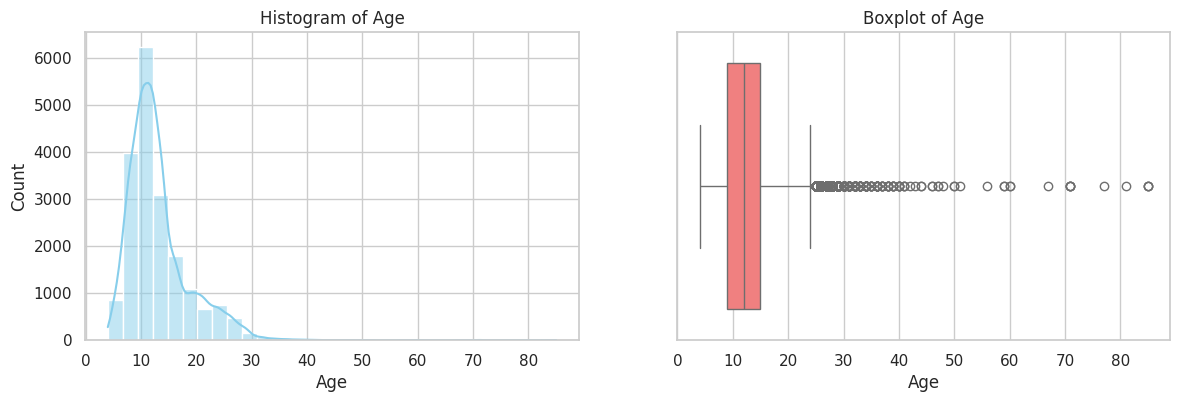

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Age'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of Age')
ax[0].set_xlabel('Age')

sns.boxplot(x=df_copy_outliers['Age'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of Age')
ax[1].set_xlabel('Age')

In [ ]:
# Remove outliers of price from the DataFrame
outliers_age = calculate_outliers_Q1_Q3(df_copy_outliers['Age'],df['Age'])


New Number of outliers: 970
New Number of outliers stands for: 5.042366273327442 % of the dataset
********
Lower Bound : 0.0
Upper Bound : 24.0


---

For the same reason as before, the distribution is not gaussian but has a postiive skewness. That means we decided to increase the upper bound to 30 years.

---

In [ ]:
# Our rules
our_outliers_age = (df['Age'] < 0.0) | (df['Age'] > 30)

num_outliers_our = np.sum(our_outliers_age)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Age'])} % of the initial dataset")

df = df[~our_outliers_age]
target = target[~our_outliers_age]

Number of outliers with our bound: 145
New Number of outliers stands for: 0.7537557831262671 % of the initial dataset


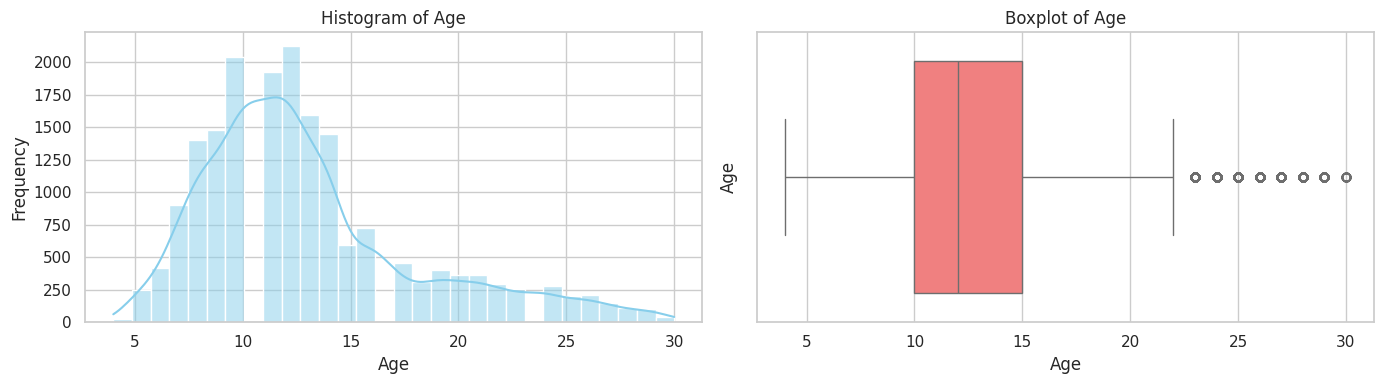

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Age'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Age'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Age')
axes[1].set_ylabel('Age')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---

The distribution looks great. The number of old cars is huge. The median is around 12 after dropping some outliers which is old for a car.

---

######**MileAge**

Text(0.5, 0, 'MileAge')

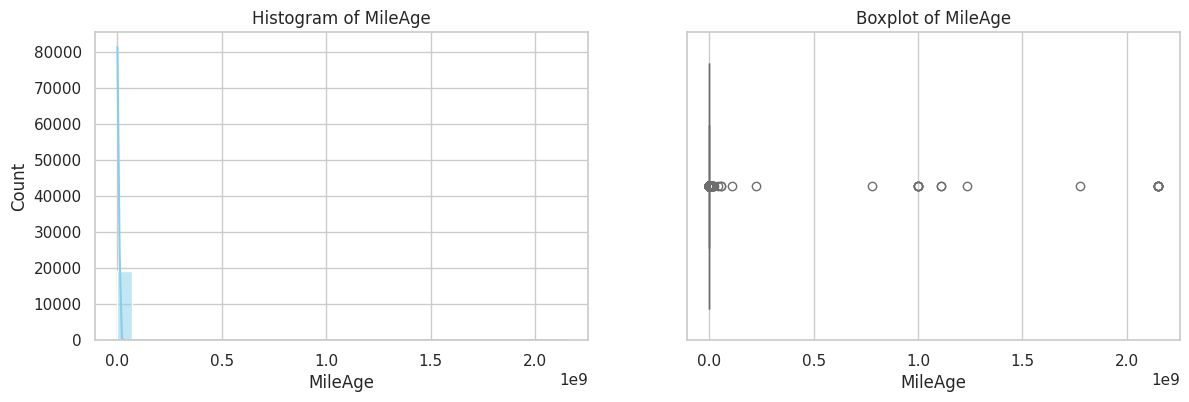

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Mileage'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of MileAge')
ax[0].set_xlabel('MileAge')

sns.boxplot(x=df_copy_outliers['Mileage'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of MileAge')
ax[1].set_xlabel('MileAge')

In [ ]:
# Remove outliers of price from the DataFrame
outliers_Mileage = calculate_outliers_Q1_Q3(df_copy_outliers['Mileage'],df['Mileage'])



New Number of outliers: 623
New Number of outliers stands for: 3.238550709570099 % of the dataset
********
Lower Bound : -107984.5
Upper Bound : 367011.5


In [ ]:
our_outliers_Mileage = outliers_Mileage #(df['Mileage'] < 0.0) | (df['Mileage'] > 367)

num_outliers_our = np.sum(our_outliers_Mileage)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Mileage'])} % of the initial dataset")

df = df[~our_outliers_Mileage]
target = target[~our_outliers_Mileage]

Number of outliers with our bound: 623
New Number of outliers stands for: 3.238550709570099 % of the initial dataset


---
We keep the same bounds as we consider it relevant regarding our experience with cars.

---

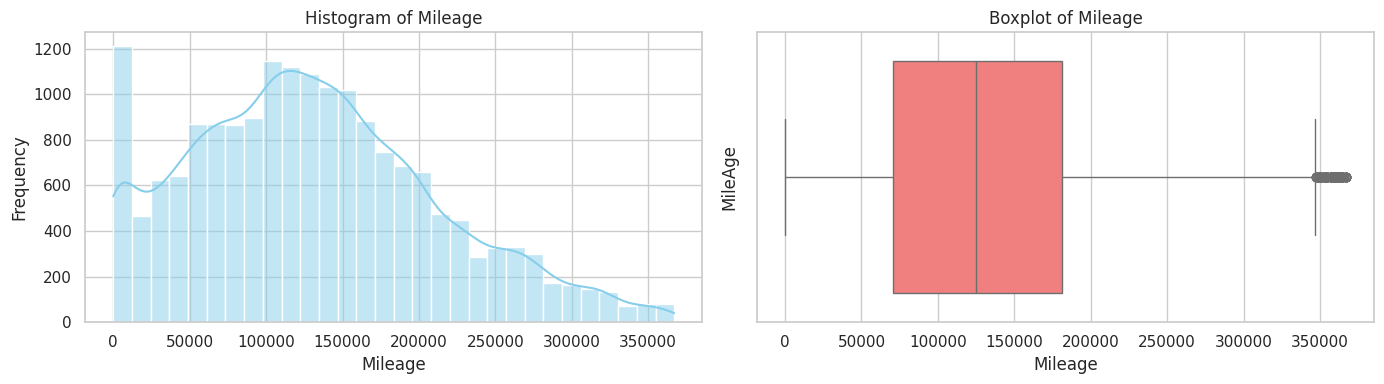

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Mileage'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Mileage')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Mileage'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Mileage')
axes[1].set_ylabel('MileAge')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---

We have mainly old cars so it is great to see the median for that feature is above 100,000 km. On the contrary there appear to be two segments of cars. The new car released on the market and the second-hand cars.

---

######**Age MileAge and Price**


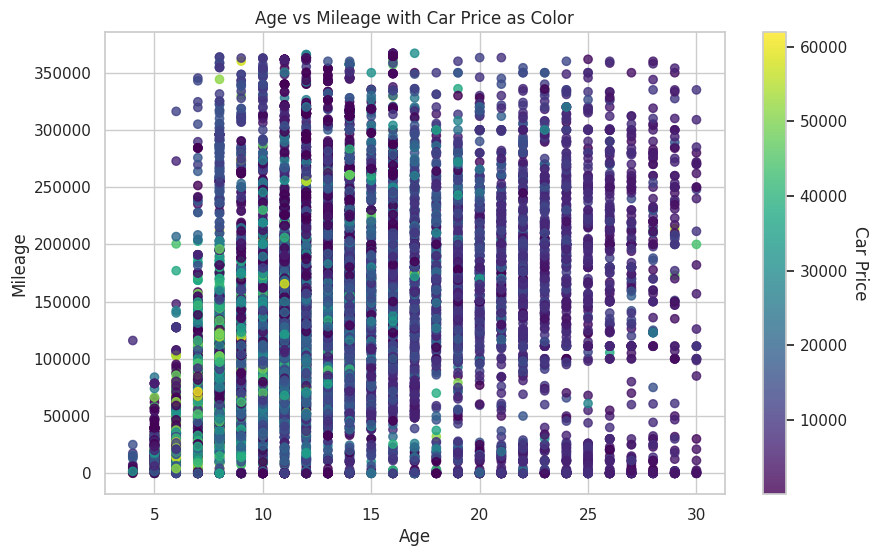

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Age'], df['Mileage'], c=target, cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Car Price', rotation=270, labelpad=15)

# Titres et axes
plt.title("Age vs Mileage with Car Price as Color")
plt.xlabel("Age")
plt.ylabel("Mileage")
plt.grid(True)
plt.show()

---

We will talk about correlations in more details later. But we can notice if the car is young it is likely it has little mileage, but later it depends on the driver's behaviour (how often it is used) explaining the homogeneity after 5 years. Besides we can see those pieces of information seem to be not sufficient enouhg to predict the prices of cars.

---

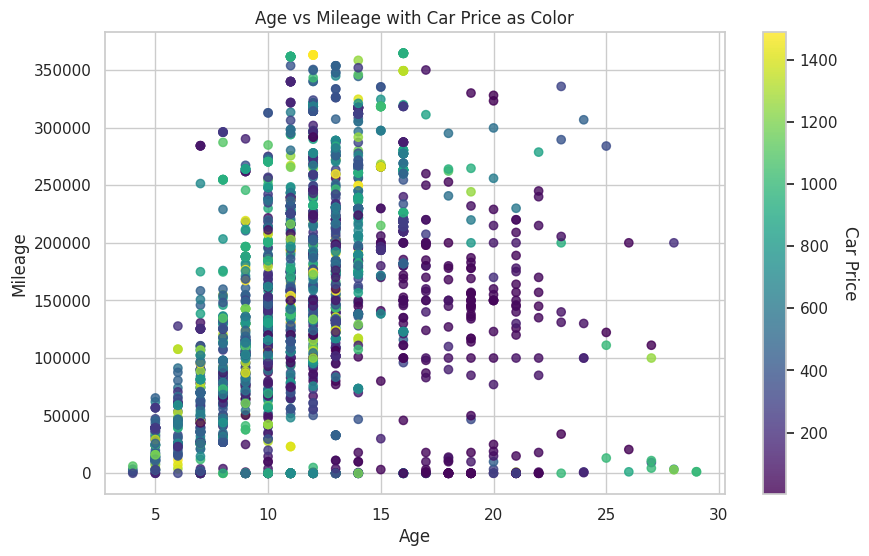

In [ ]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Age'][target<1500], df['Mileage'][target<1500], c=target[target<1500], cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Car Price', rotation=270, labelpad=15)

# Titres et axes
plt.title("Age vs Mileage with Car Price as Color")
plt.xlabel("Age")
plt.ylabel("Mileage")
plt.grid(True)
plt.show()

---
We will take a closer look at priced cars below 1500 whose Mileage and Age might be coherent with that price.

---

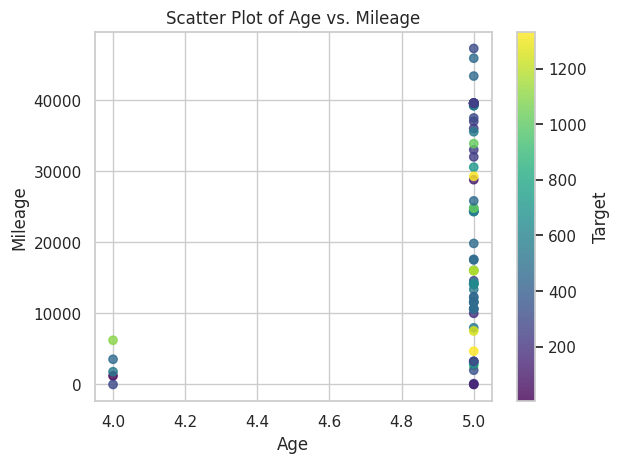

In [ ]:
mask = (target < 1500) & (df['Mileage'] < 50000) & (df['Age']<=5)
scatter = plt.scatter(
    df['Age'][mask],
    df['Mileage'][mask],
    c=target[mask],
    cmap='viridis',
    alpha=0.8
)

# Ajouter une barre de couleur
cbar = plt.colorbar(scatter)
cbar.set_label('Target')

# Ajouter des étiquettes aux axes
plt.xlabel('Age')
plt.ylabel('Mileage')
plt.title('Scatter Plot of Age vs. Mileage')

# Afficher le graphique
plt.show()

In [ ]:
len(df['Age'][mask])

77

In [ ]:
df[mask].head(n=20)

Levy Manufacturer               Model Category Leather interior  \
170   1077.0        MAZDA                1000     Jeep              Yes   
349   1077.0       TOYOTA                 CHR     Jeep              Yes   
481      0.0       TOYOTA  Land Cruiser Prado     Jeep              Yes   
890    607.0       TOYOTA               Camry    Sedan              Yes   
914    607.0       TOYOTA               Camry    Sedan              Yes   
1115   780.0    CHEVROLET               Cruze    Sedan              Yes   
1248  1077.0       TOYOTA                 CHR     Jeep              Yes   
1338  1077.0       TOYOTA                 CHR     Jeep              Yes   
1849   607.0        LEXUS              ES 300    Sedan              Yes   
2448   607.0       TOYOTA               Camry    Sedan              Yes   
2820   420.0      HYUNDAI              Accent    Sedan              Yes   
2877  1077.0       TOYOTA                 CHR     Jeep              Yes   
3096   780.0    CHEVROLET               Cruze    Sedan              Yes   
3249   607.0       TOYOTA               Camry    Sedan              Yes   
3501   607.0       TOYOTA               Camry    Sedan              Yes   
3556     0.0       TOYOTA  Land Cruiser Prado     Jeep               No   
4119     0.0       TOYOTA  Land Cruiser Prado     Jeep               No   
4354  1325.0       TOYOTA               Camry    Sedan              Yes   
4360   607.0       TOYOTA               Camry    Sedan              Yes   
4500   607.0       TOYOTA               Camry    Sedan              Yes   

     Fuel type  Engine volume  Mileage  Cylinders Gear box type Drive wheels  \
170     Petrol            2.0  11566.0        4.0     Automatic          4x4   
349     Petrol            2.0  24339.0        4.0     Automatic        Front   
481     Petrol            2.7    120.0        4.0     Automatic          4x4   
890     Hybrid            2.5  39552.0        4.0     Automatic        Front   
914     Hybrid            2.5  39552.0        4.0     Automatic        Front   
1115    Petrol            1.4  16042.0        4.0     Automatic        Front   
1248    Petrol            2.0  10003.0        4.0     Automatic        Front   
1338    Petrol            2.0  24339.0        4.0     Automatic        Front   
1849    Hybrid            2.5  13362.0        4.0     Automatic        Front   
2448    Hybrid            2.5  39552.0        4.0     Automatic        Front   
2820    Hybrid            1.6  14587.0        4.0     Automatic        Front   
2877    Petrol            2.0  24339.0        4.0     Automatic        Front   
3096    Petrol            1.4  14074.0        4.0     Automatic        Front   
3249    Hybrid            2.5  39552.0        4.0     Automatic        Front   
3501    Hybrid            2.5  39552.0        4.0     Automatic        Front   
3556    Diesel            3.0  33000.0        6.0     Automatic          4x4   
4119    Diesel            3.0  36000.0        6.0     Automatic          4x4   
4354    Petrol            2.5  35541.0        4.0     Automatic        Front   
4360    Hybrid            2.5  39552.0        4.0     Automatic        Front   
4500    Hybrid            2.5  39552.0        4.0     Automatic        Front   

           Wheel  Color  Airbags  Age  
170   Left wheel  Black       12    5  
349   Left wheel   Blue       12    5  
481   Left wheel  White       10    5  
890   Left wheel  Black       12    5  
914   Left wheel  Black       12    5  
1115  Left wheel  Black       12    5  
1248  Left wheel   Blue       12    5  
1338  Left wheel   Blue       12    5  
1849  Left wheel  Black       12    5  
2448  Left wheel  Black       12    5  
2820  Left wheel  Black       12    5  
2877  Left wheel   Blue       12    5  
3096  Left wheel   Grey       12    5  
3249  Left wheel  Black       12    5  
3501  Left wheel  Black       12    5  
3556  Left wheel  White       12    5  
4119  Left wheel   Grey       12    5  
4354  Left wheel  Black       1

---
We are not domain experts, but upon closer inspection, it seems possible to remove more of what could be considered errors in the dataset. Suprisingly, we can observe some cars priced below 1500, less than 5 years old, and with mileage under 50,000 km.

---

In [ ]:
df = df[~mask]
target = target[~mask]

######**Cylinder**

Text(0.5, 0, 'Cylinders')

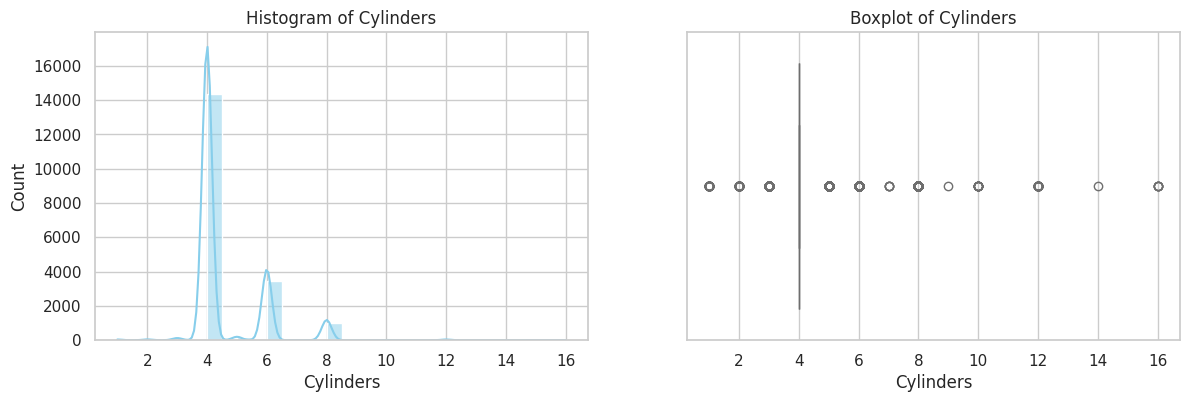

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Cylinders'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of Cylinders')
ax[0].set_xlabel('Cylinders')

sns.boxplot(x=df_copy_outliers['Cylinders'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of Cylinders')
ax[1].set_xlabel('Cylinders')

In [ ]:
# Remove outliers of price from the DataFrame
outliers_Cylinders = calculate_outliers_Q1_Q3(df_copy_outliers['Cylinders'],df['Cylinders'])



New Number of outliers: 4266
New Number of outliers stands for: 22.176014971149346 % of the dataset
********
Lower Bound : 4.0
Upper Bound : 4.0


---
Most of cars have 4 cylinders. This feature behaves like a categorcial feature but we let it numerical as it could be encoded via an ordinal encoder. We think the more a car have cylinders the more expensive it is.

---

In [ ]:
our_outliers_cylinders = (df['Cylinders'] < 4) | (df['Cylinders'] > 9)

num_outliers_our = np.sum(our_outliers_cylinders)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Cylinders'])} % of the initial dataset")

df = df[~our_outliers_cylinders]
target = target[~our_outliers_cylinders]

Number of outliers with our bound: 210
New Number of outliers stands for: 1.0916463065966626 % of the initial dataset


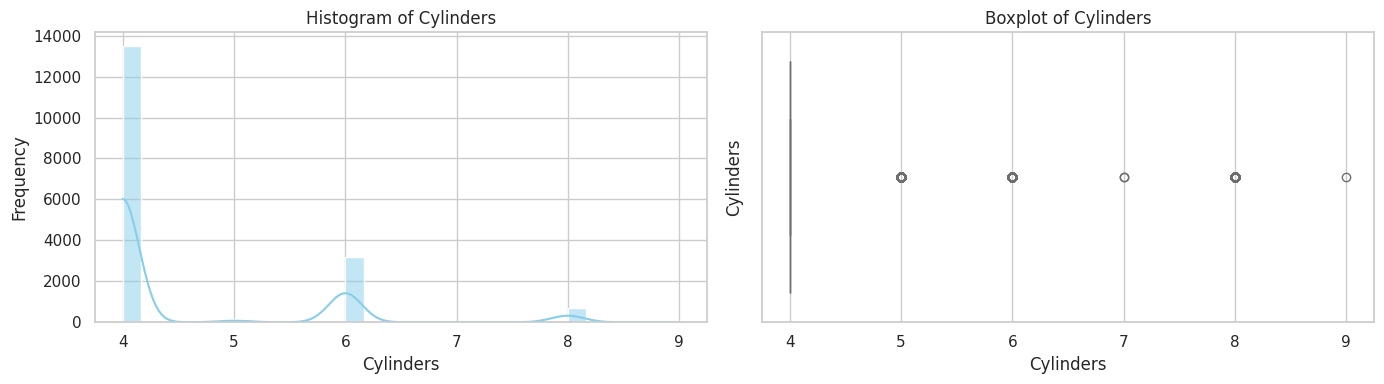

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Cylinders'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Cylinders')
axes[0].set_xlabel('Cylinders')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Cylinders'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Cylinders')
axes[1].set_ylabel('Cylinders')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
df['Cylinders'].unique()

array([6., 4., 8., 5., 9., 7.])

---

As opposed to Doors, the category are more frequent.

---

######**Airbag**

Text(0.5, 0, 'Airbags')

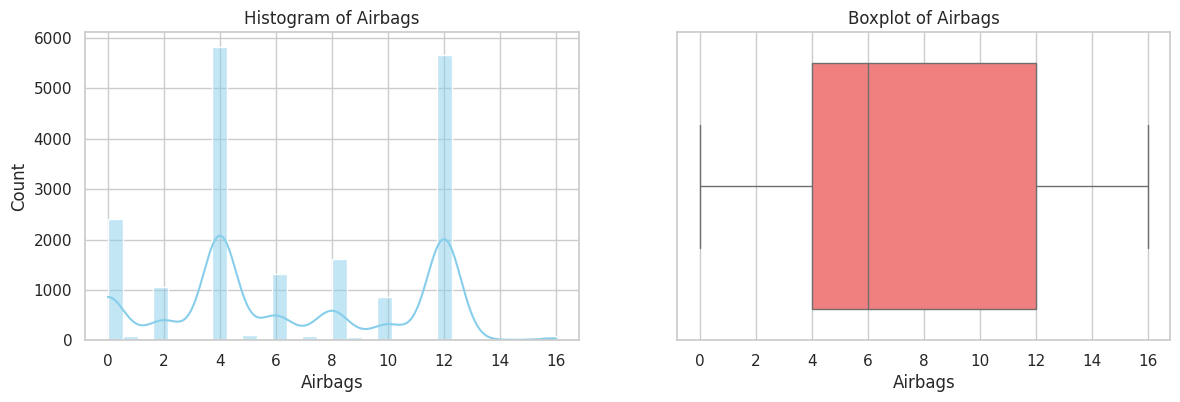

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Airbags'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of Airbags')
ax[0].set_xlabel('Airbags')

sns.boxplot(x=df_copy_outliers['Airbags'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of Airbags')
ax[1].set_xlabel('Airbags')

In [ ]:
# Remove outliers of price from the DataFrame
outliers_Airbags = calculate_outliers_Q1_Q3(df_copy_outliers['Airbags'],df['Airbags'])



New Number of outliers: 0
New Number of outliers stands for: 0.0 % of the dataset
********
Lower Bound : -8.0
Upper Bound : 24.0


In [ ]:
our_outliers_airbags = outliers_Airbags #(df['Mileage'] < 0.0) | (df['Mileage'] > 367)

num_outliers_our = np.sum(our_outliers_airbags)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Airbags'])} % of the initial dataset")

df = df[~our_outliers_airbags]
target = target[~our_outliers_airbags]

Number of outliers with our bound: 0
New Number of outliers stands for: 0.0 % of the initial dataset


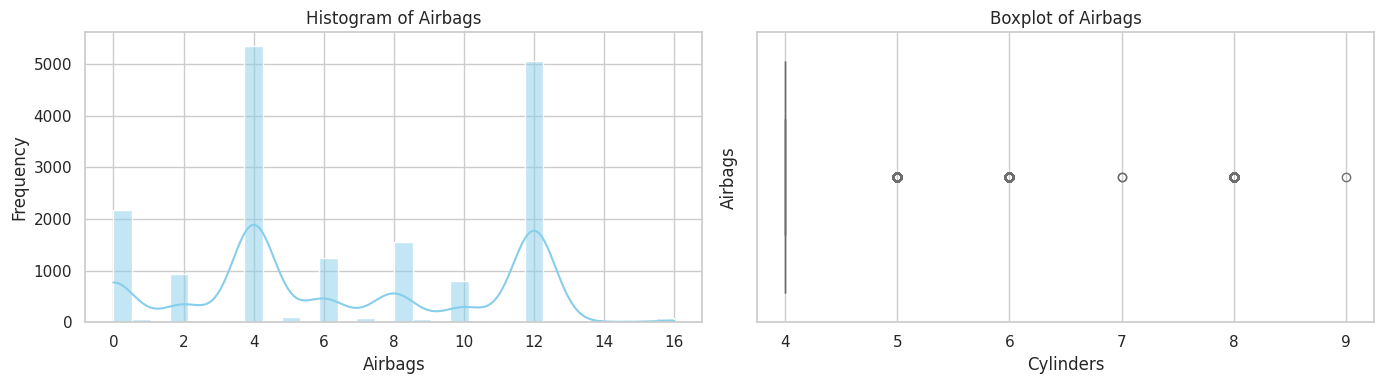

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Airbags'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Airbags')
axes[0].set_xlabel('Airbags')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Cylinders'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Airbags')
axes[1].set_ylabel('Airbags')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

######**Levy**

Text(0.5, 0, 'Levy')

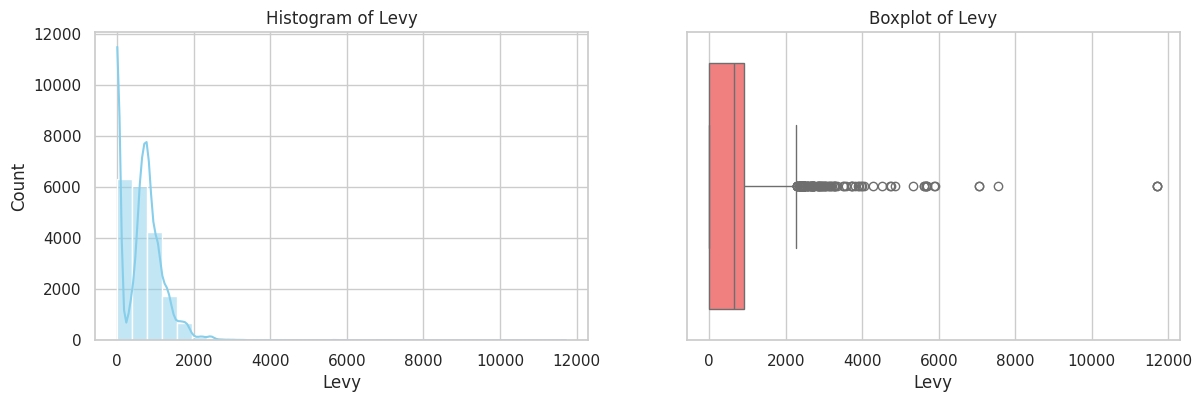

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(14,4))

sns.histplot(df_copy_outliers['Levy'],bins=30,kde=True,color='skyblue',ax=ax[0])
ax[0].set_title('Histogram of Levy')
ax[0].set_xlabel('Levy')

sns.boxplot(x=df_copy_outliers['Levy'],ax=ax[1],color='lightcoral',boxprops=dict(facecolor='lightcoral'))
ax[1].set_title('Boxplot of Levy')
ax[1].set_xlabel('Levy')

In [ ]:
# Remove outliers of price from the DataFrame
outliers_Levy = calculate_outliers_Q1_Q3(df_copy_outliers['Levy'],df['Levy'])



New Number of outliers: 90
New Number of outliers stands for: 0.4678484171128554 % of the dataset
********
Lower Bound : -1375.5
Upper Bound : 2292.5


In [ ]:
our_outliers_Levy = outliers_Levy #(df['Mileage'] < 0.0) | (df['Mileage'] > 367)

num_outliers_our = np.sum(our_outliers_Levy)
print(f"Number of outliers with our bound: {num_outliers_our}")
print(f"New Number of outliers stands for: {100*num_outliers_our/len(df_copy_outliers['Levy'])} % of the initial dataset")

df = df[~our_outliers_Levy]
target = target[~our_outliers_Levy]

Number of outliers with our bound: 90
New Number of outliers stands for: 0.4678484171128554 % of the initial dataset


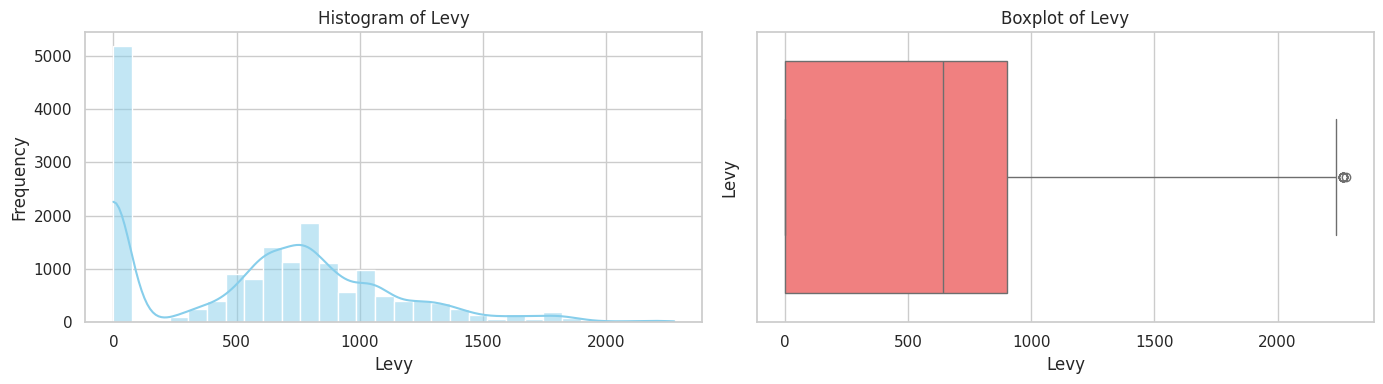

In [ ]:
# Set up a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

# Histogram
sns.histplot(df['Levy'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Histogram of Levy')
axes[0].set_xlabel('Levy')
axes[0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['Levy'], color='lightcoral', ax=axes[1], boxprops=dict(facecolor='lightcoral'))
axes[1].set_title('Boxplot of Levy')
axes[1].set_ylabel('Levy')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---
Our decision to set the levy for non-taxed cars to 0 remains a sound choice. Indeed, the levy appears to follow a bimodal distribution, with one mode representing the behavior of non-taxed cars centered around 0, and another mode reflecting a different behavior when the car is taxed

---

######**Numerical Correlation**

In [ ]:
df_with_target = df.copy()
df_with_target['target'] = target
num_features_with_target = numerical_features + ['target']
df_with_target_num = df_with_target[num_features_with_target]

**Scatter Plots**

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable h

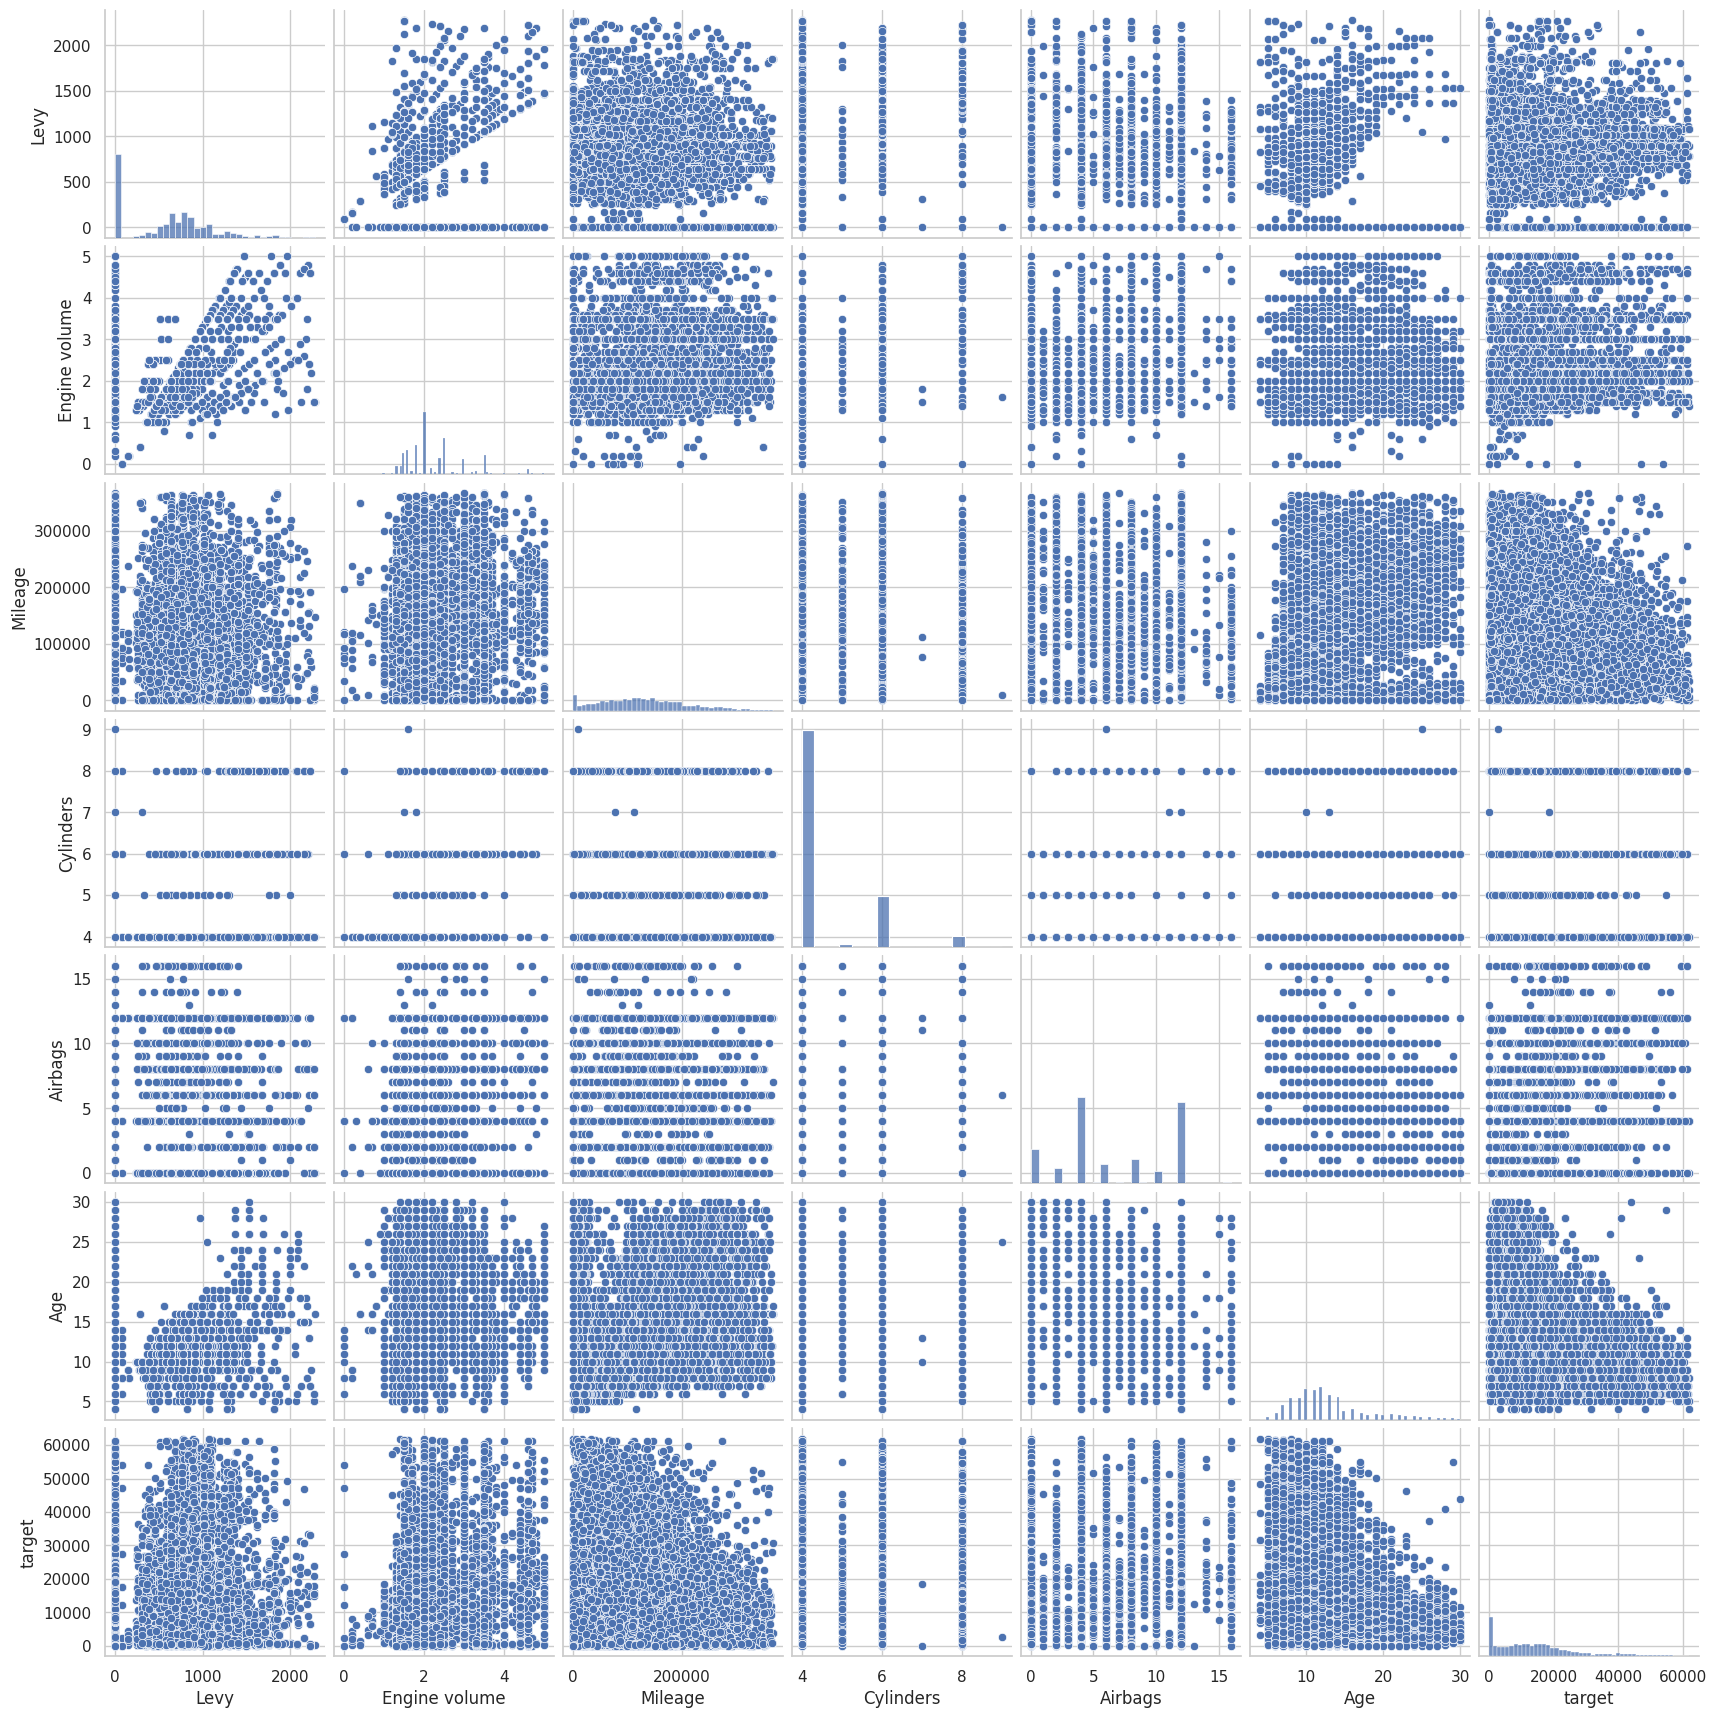

In [ ]:

sns.pairplot(
    df_with_target_num,
    diag_kind='hist',     # 'hist'
    hue=None,             # Pas de séparation par couleurs (ajustez si nécessaire) # target
    palette='viridis',    # Palette de couleurs pour le graphique
    kind = 'scatter'
    #height=3,             # Taille de chaque sous-graphe
    #aspect=1,             # Aspect ratio de chaque sous-graphe
)

# Afficher le graphique
plt.show()


**Pearson**

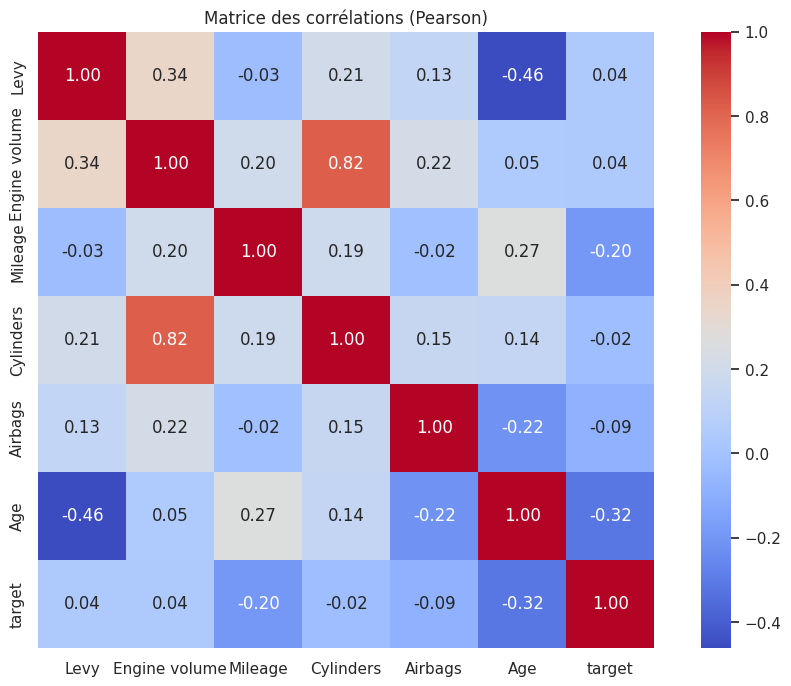

In [ ]:
corr_matrix = df_with_target_num.corr(method='pearson')

# Création du heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Matrice des corrélations (Pearson)")
plt.show()

**Spearman**

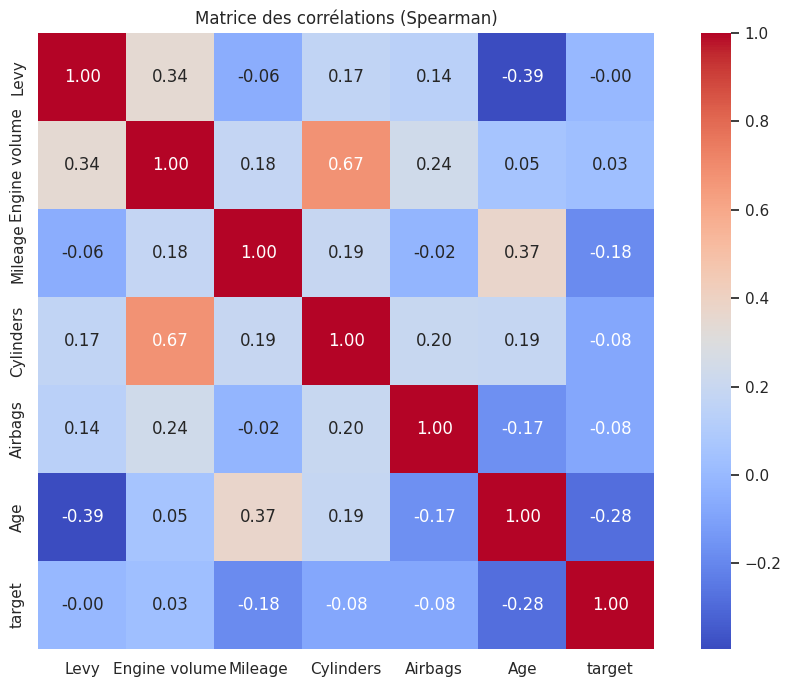

In [ ]:
# Calcul de la matrice des corrélations de Spearman
# df + target
corr_matrix = df_with_target_num.corr(method='spearman')

# Création du heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title("Matrice des corrélations (Spearman)")
plt.show()

----
As regards to the three figures above, we will investigate the relationships between the car's price and the numerical features. The Pearson coefficient shows how linear the relationship is, while the Spearman coefficient measures the strength and direction of a monotonic relationship between variables allowing non-linear interactions. On another hand the scatter plots gives us a visualization of those correlations if they exist.

- The last row of each plot is worth exploring further as it shows the correlation between the price and other features. There seems to be no relationship between the numerical features and the car's price, as shown in their one-dimensional scatter plots. Indeed . Only Mileage and age appears to be negatively collerated with prices which is good to see. The older the car is in terms of years of miles, the cheap it is. The sign of the correlation is confirmed both by the pearson and spearman but their value peaks at -0.2, which is relatively low.
  
  
- Besides we have good reason to think Levy is positevely correlated with the engine volume. The bigger the engine volume is the more it pollutes the higher the Levy tax should be. That is what we can observe in the scatter plot even if neither the spearman and pearson coefficients are only around 0.3. However it is interesting to note a relatively strong (0.8 for the pearson coefficient) between The engine Volume and the number of cylinders explaining why we find the same patterns between levy and the number of cylinders.

Overall, We find the numerical features are weakly correlated with the prices. We hope for a better results with the categorical features even if we should keep in mind those features can still be useful in a higher dimensional space to predict the prices.

(Maybe we can drop cylinders)

---

######**Total outliers removed so far**

In [ ]:
outliers_list = [our_outliers_price, our_outliers_Levy, our_outliers_age, our_outliers_Mileage, our_outliers_cylinders, our_outliers_airbags, our_outliers_engine_volume,mask]

c = 0
for out in outliers_list:
  c+=np.sum(out)

print(f"The number of removed outliers is {c} elements")
print(f"It stands for {round(100*c/len(target_copy_outliers),2)} % of the initial dataset")


The number of removed outliers is 1784 elements
It stands for 9.27 % of the initial dataset


#####**Categorical Features**

######**Color**


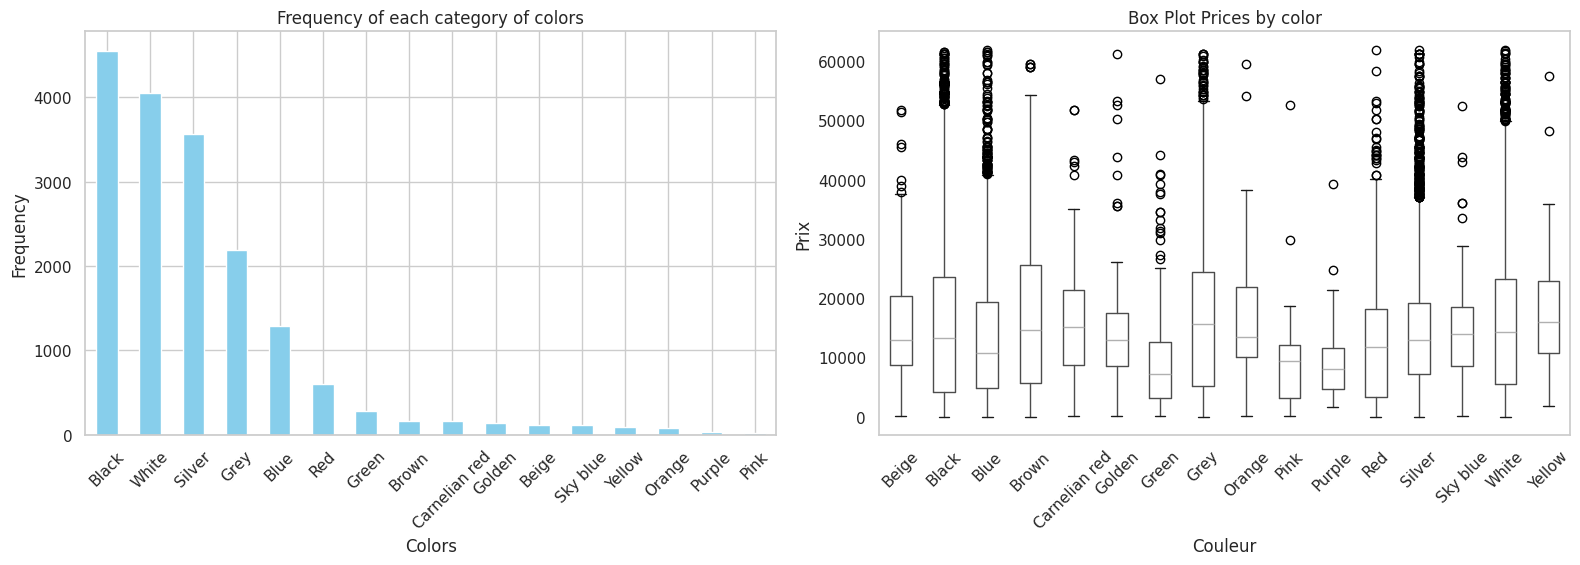

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df1=df.copy()
df1['Price'] = target
df1['Color'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Frequency of each category of colors")
axes[0].set_xlabel("Colors")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

df1.boxplot(column='Price', by='Color', grid=False, ax=axes[1])
axes[1].set_title("Box Plot Prices by color")
axes[1].set_xlabel("Couleur")
axes[1].set_ylabel("Prix")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("")
plt.tight_layout()
plt.show()

---

On the first plot we can see that Colors like Black, White, Silver, and Grey dominate the dataset, with significantly higher frequencies compared to other colors. Rare colors like Pink, Purple, and Yellow have very few instances. this imbalance in the features might bias the model towards the more frequent colors. We could therfore Group colors with fewer instances into a single category like "Other Colors." This is the strategy we have use for also the next categorical features. To finish the second boxplot of the price with the colors gives an indication of how easy it would be to determinate the price with the Color, here it would not be evident.

---

######**Fuel-Type**

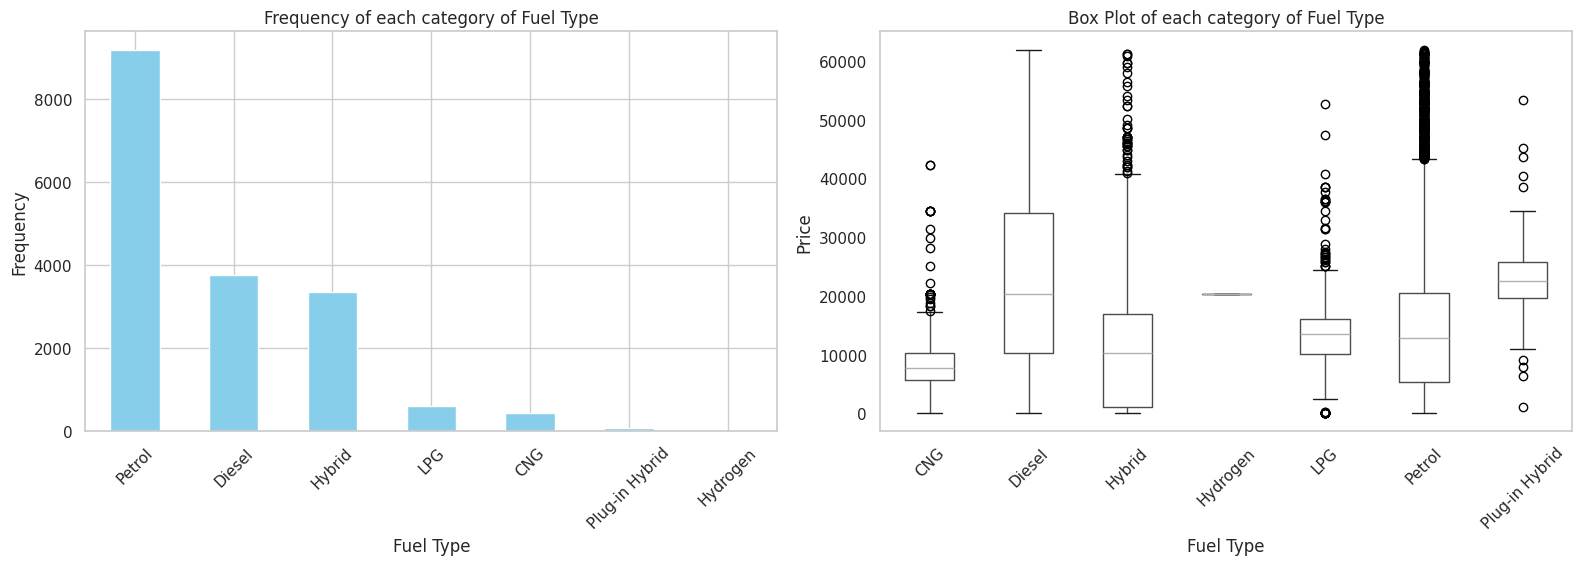

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df1=df.copy()
df1['Price'] = target
df1['Fuel type'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Frequency of each category of Fuel Type")
axes[0].set_xlabel("Fuel Type")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

df1.boxplot(column='Price', by='Fuel type', grid=False, ax=axes[1])
axes[1].set_title("Box Plot of each category of Fuel Type")
axes[1].set_xlabel("Fuel Type")
axes[1].set_ylabel("Price")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("")
plt.tight_layout()
plt.show()

######**Category**

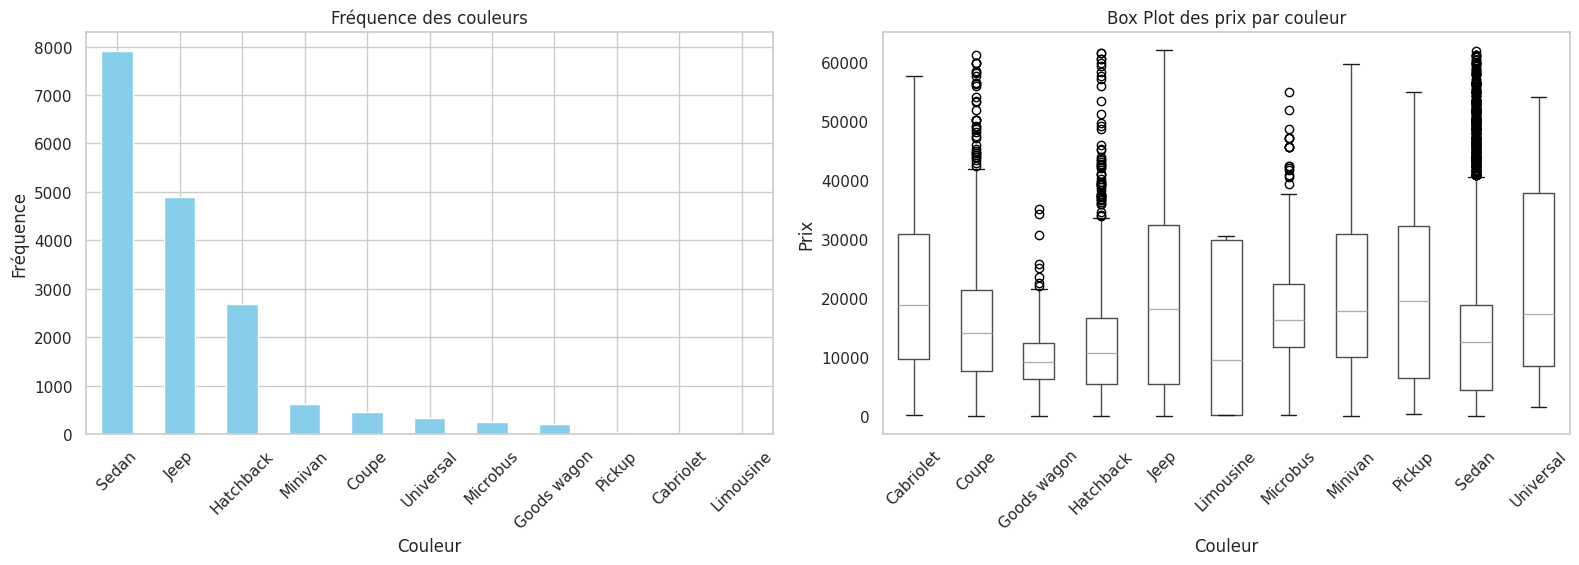

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df1=df.copy()
df1['Price'] = target
df1['Category'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Fréquence des Catégories")
axes[0].set_xlabel("Catégories")
axes[0].set_ylabel("Fréquence")
axes[0].tick_params(axis='x', rotation=45)

df1.boxplot(column='Price', by='Category', grid=False, ax=axes[1])
axes[1].set_title("Box Plot des prix par Catégories")
axes[1].set_xlabel("Catégories")
axes[1].set_ylabel("Prix")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("")
plt.tight_layout()
plt.show()

######**Manufacturer**

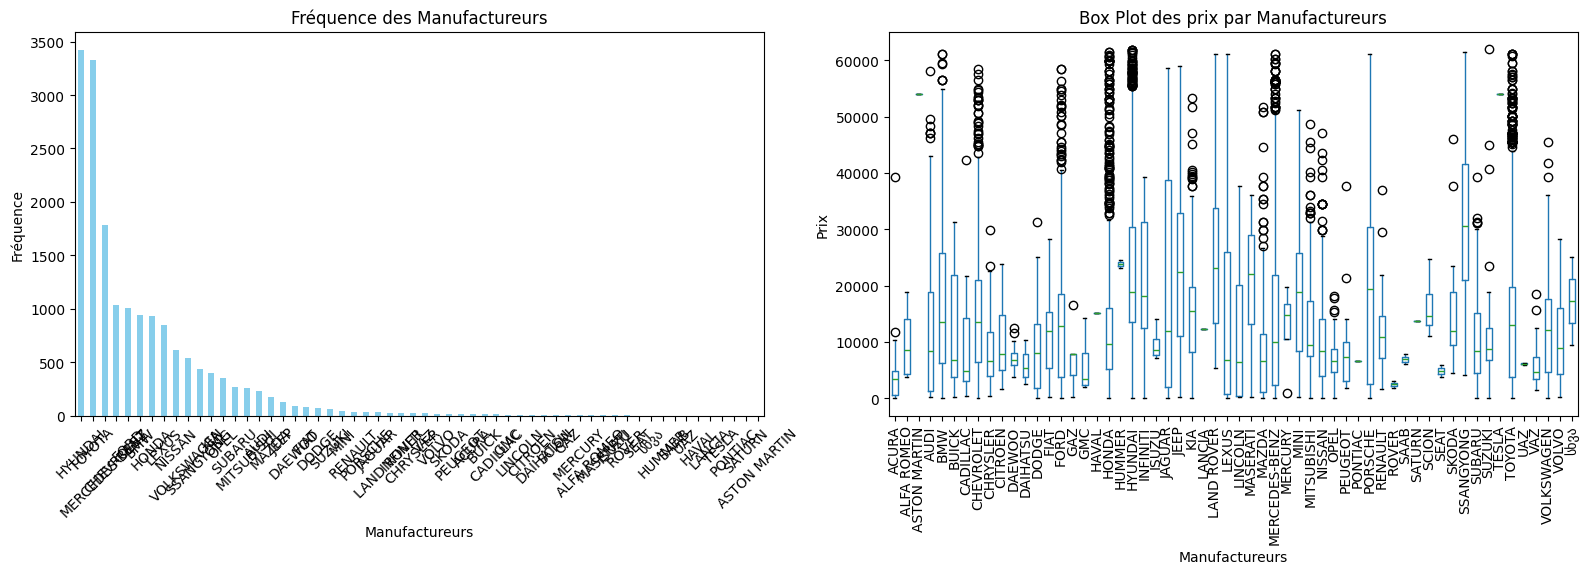

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df1=df.copy()
df1['Price'] = target
df1['Manufacturer'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Fréquence des Manufactureurs")
axes[0].set_xlabel("Manufactureurs")
axes[0].set_ylabel("Fréquence")
axes[0].tick_params(axis='x', rotation=45)

df1.boxplot(column='Price', by='Manufacturer', grid=False, ax=axes[1])
axes[1].set_title("Box Plot des prix par Manufactureurs")
axes[1].set_xlabel("Manufactureurs")
axes[1].set_ylabel("Prix")
axes[1].tick_params(axis='x', rotation=45)
plt.xticks(rotation=90)
plt.suptitle("")
plt.tight_layout()
plt.show()

---

Here the plot begin to be difficult to read, we reduce the number of Manufacturers

---

######**Model**

In [140]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression

df1 = df.copy()
df1['Price'] = target  # Assure que la cible est incluse dans le DataFrame

# Count the number of unique instances in 'Model'
unique_models_count = df['Model'].nunique()
print(f"Number of unique models in the dataset: {unique_models_count}")

# Limit to the 30 most frequent models and group the rest
top_30_models = df['Model'].value_counts().nlargest(30).index
df['Model_Grouped'] = df['Model'].apply(lambda x: x if x in top_30_models else 'Other Models')

# Encode the grouped 'Model' feature
df['Model_Encoded_Grouped'] = encoder.fit_transform(df[['Model_Grouped']])

# Display a summary of grouped models
grouped_model_counts = df['Model_Grouped'].value_counts()
print("\nNumber of Instances in Each Grouped Model:")
print(grouped_model_counts)







Number of unique models in the dataset: 1389

Number of Instances in Each Grouped Model:
Model_Grouped
Other Models    7483
Prius            998
Elantra          912
Camry            865
Sonata           801
Santa FE         489
E 350            488
FIT              434
H1               429
Tucson           424
Aqua             327
X5               325
Cruze            297
Fusion           295
Optima           229
ML 350           196
GX 460           195
Jetta            195
Highlander       190
Transit          189
Actyon           188
REXTON           174
Civic            168
RAV 4            164
RX 450           153
Escape           147
Volt             144
Juke             143
Captiva          139
Astra            137
CT 200h          135
Name: count, dtype: int64


---

There are 1389 differents Model, we reduce the numbers of differents Models

---

######**Correlation Matrix -Categorical Features**

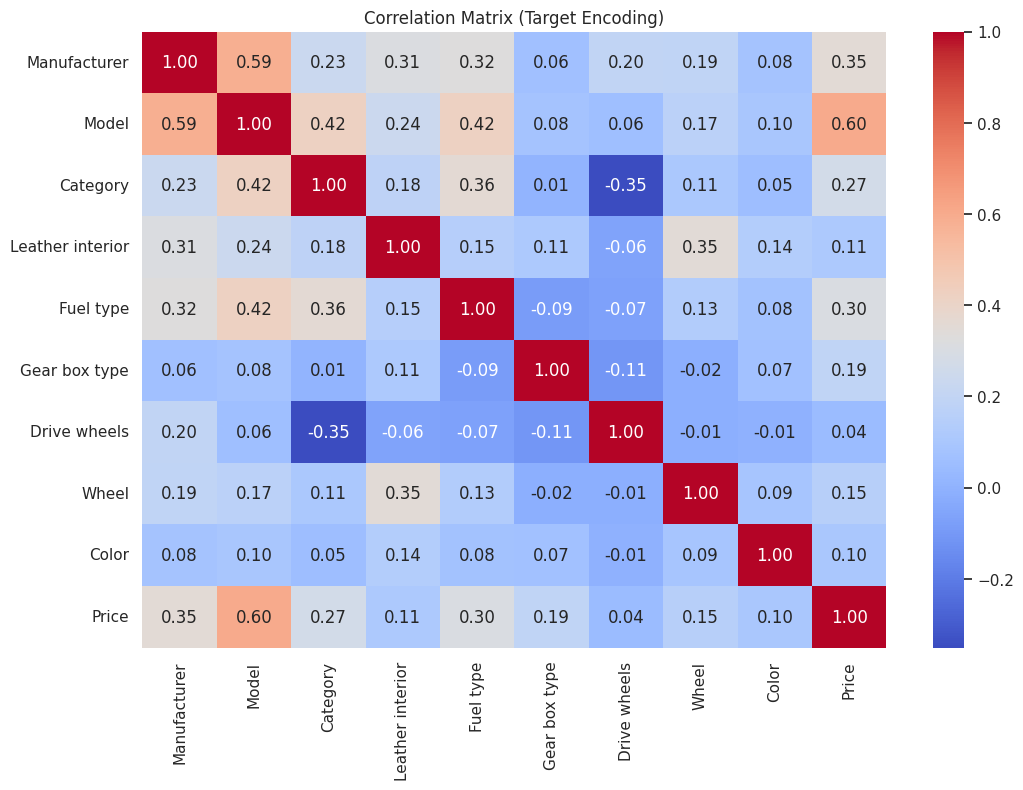

                  Manufacturer     Model  Category  Leather interior  \
Manufacturer          1.000000  0.587715  0.232683          0.312302   
Model                 0.587715  1.000000  0.420473          0.237174   
Category              0.232683  0.420473  1.000000          0.179851   
Leather interior      0.312302  0.237174  0.179851          1.000000   
Fuel type             0.324589  0.422278  0.358962          0.145385   
Gear box type         0.061057  0.081716  0.005679          0.109559   
Drive wheels          0.196520  0.059910 -0.350906         -0.062940   
Wheel                 0.187412  0.169587  0.105949          0.347805   
Color                 0.076636  0.095445  0.052985          0.138019   
Price                 0.352956  0.598969  0.269717          0.108774   

                  Fuel type  Gear box type  Drive wheels     Wheel     Color  \
Manufacturer       0.324589       0.061057      0.196520  0.187412  0.076636   
Model              0.422278       0.081716     

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical features
categorical_features = ['Manufacturer', 'Model', 'Category', 'Leather interior',
                        'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Create a copy of the DataFrame with categorical features
df_target_encoded = df1[categorical_features].copy()

# Apply Target Encoding: Replace each category with the mean of 'Price'
for col in categorical_features:
    df_target_encoded[col] = df1.groupby(col)['Price'].transform('mean')

# Add the target variable ('Price') to the encoded DataFrame
df_target_encoded['Price'] = df1['Price']

# Compute the correlation matrix
correlation_matrix = df_target_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Matrix (Target Encoding)")
plt.show()

# Display the correlation matrix
print(correlation_matrix)


---

This correlation matrix visualizes the linear relationships between the features and the target variable "Price" after applying target encoding to categorical variables.Model has the strongest correlation with Price (0.60), indicating that it is a key predictor for car prices. But also others features like Category and Manufacturer are significant. But weakly correlated features might still provide value through non-linear relationships this is why we will try to use mutual information to analyse further

---

######**Mututal Information**

            Feature  Mutual Information
1             Model            0.956682
0      Manufacturer            0.419011
4         Fuel type            0.208236
5     Gear box type            0.189002
2          Category            0.186415
3  Leather interior            0.151561
6      Drive wheels            0.123329
8             Color            0.106628
7             Wheel            0.075379


<ipython-input-178-5f8d8cbeaf83>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual Information', y='Feature', data=mi_results, palette='viridis')


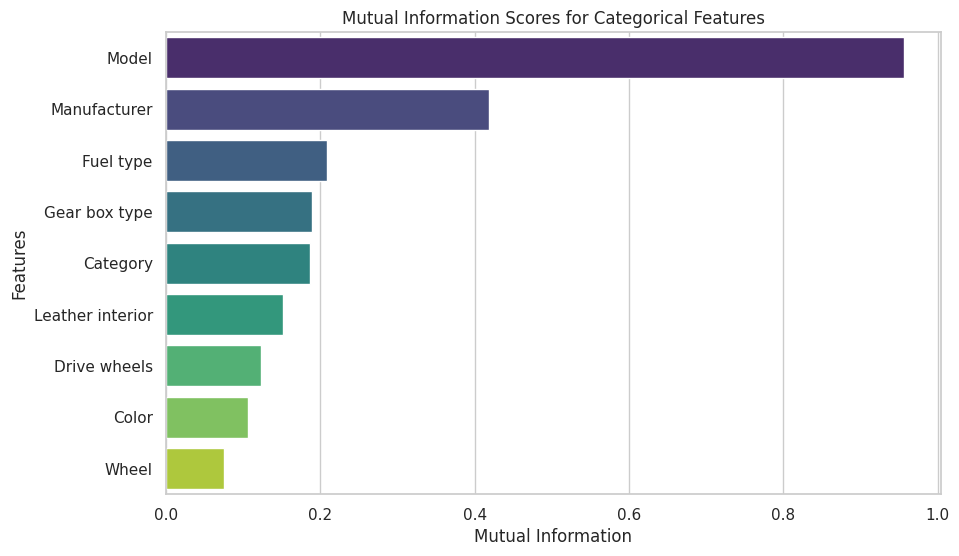

In [ ]:
from sklearn.feature_selection import mutual_info_regression

# List of categorical features
categorical_features = ['Manufacturer', 'Model', 'Category', 'Leather interior',
                        'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color']

# Encode categorical features using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
X_encoded = encoder.fit_transform(df1[categorical_features])

# Target variable
y = df1['Price']

# Compute Mutual Information
mi_scores = mutual_info_regression(X_encoded, y, discrete_features=True)

# Create a DataFrame for better visualization
mi_results = pd.DataFrame({
    'Feature': categorical_features,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)

# Display the Mutual Information Scores
print(mi_results)

# Plot Mutual Information Scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Mutual Information', y='Feature', data=mi_results, palette='viridis')
plt.title('Mutual Information Scores for Categorical Features')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.show()


---

This bar chart illustrates the mutual information (MI) scores, which measure the dependency between each feature and the target variable "Price". It captures both linear and non-linear relationships and is therfore interesting.
It reaffirmates "Model" strong relationship with Price , it is the features containing the most information about "Price" in the dataset.

Remark: Also we observed that by limiting the number of differents Models, it makes the mutual information decrease

---

---
We drop the duplicates

---

In [ ]:
df = df.drop_duplicates()
target = target[df.index]


#####**Unsupervised Learning PCA - GMM**

---
In this section, we aim to implement unsupervised learning techniques to identify and analyze clusters within the data. The ultimate goal is to group vehicles into distinct categories, such as entry-level, mid-range, or high-end cars, and progressively infer the value of a car based on its characteristics. These clusters may represent natural segments, such as:

Economy cars: small engine size, low mileage, and affordable price.
Luxury cars: large engine size, low mileage, and high price.
Old used cars: high mileage and reduced price.
By identifying these clusters, we aim to better understand the natural groupings and market positioning of different vehicles based on their attributes.



---

In [ ]:
df_PCA = df.copy()
target_PCA = target.copy()


*********
Variance totale conservée : 0.46
*********


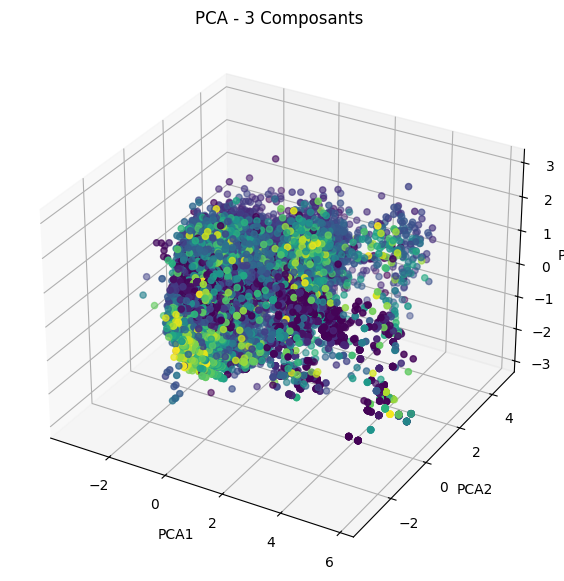

*********
Variance totale conservée : 0.37
*********


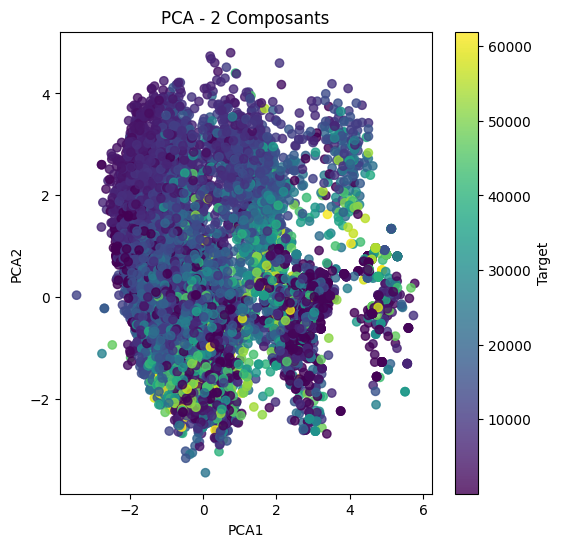

*********
Nombre de composants pour conserver 90% de la variance : 24
*********
Importance des Variables :


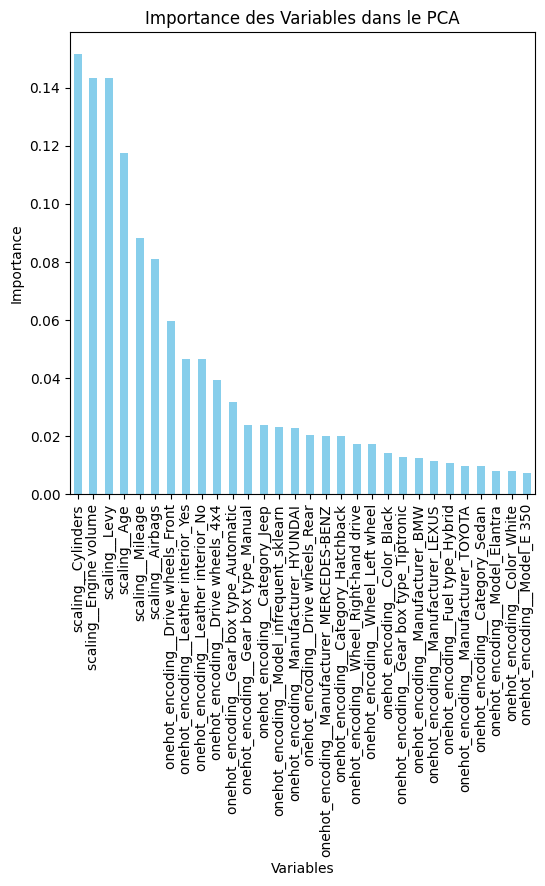

In [ ]:

# Appliquer le prétraitement sur X
X_processed = preprocessor_onehot_encoding.fit_transform(df_PCA)

# PCA avec 3 composants pour une visualisation en 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_processed)
print('*********')
print(f"Variance totale conservée : {sum(pca_3d.explained_variance_ratio_):.2f}")
print('*********')


# Visualisation en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=target_PCA, cmap='viridis')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title("PCA - 3 Composants")
plt.show()

# PCA avec 2 composants pour une visualisation en 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_processed)
print('*********')
print(f"Variance totale conservée : {sum(pca_2d.explained_variance_ratio_):.2f}")
print('*********')


# Visualisation en 2D
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=target_PCA, cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur pour la légende
cbar = plt.colorbar(scatter)
cbar.set_label('Target')

# Ajouter des étiquettes aux axes et un titre
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("PCA - 2 Composants")

# Afficher le graphique
plt.show()


# PCA qui conserve 95% de la variance
pca_95 = PCA(n_components=0.90, svd_solver='full')
X_processed2 = X_processed.toarray()
X_pca_95 = pca_95.fit_transform(X_processed2)

# Visualisation des résultats PCA à 95% de variance expliquée
print('*********')
print(f"Nombre de composants pour conserver 90% de la variance : {X_pca_95.shape[1]}")
print('*********')

# Récupérer les coefficients des composantes principales
loadings = pd.DataFrame(pca_2d.components_.T, columns=[f'PC{i+1}' for i in range(pca_2d.n_components_)], index=preprocessor_onehot_encoding.get_feature_names_out())

# Calculer l'importance globale des variables (charges * variance expliquée)
explained_variance = pca_2d.explained_variance_ratio_
importance = loadings.apply(lambda x: np.abs(x) * explained_variance, axis=1).sum(axis=1)

# Trier les variables par importance
importance_sorted = importance.sort_values(ascending=False)
print("Importance des Variables :")
#print(importance_sorted)

top_30_features = importance_sorted.head(30)


# Visualiser les variables les plus importantes
plt.figure(figsize=(6, 6))
top_30_features.plot(kind='bar', color='skyblue')
plt.title("Importance des Variables dans le PCA")
plt.ylabel("Importance")
plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.show()



---

This unsupervised learning method keeps only numerical features and we cannot preserve enough variance with all the dimensions using the categorical features. So we will try to identify segments only using the numerical features

---

*********
Variance totale conservée : 0.77
*********


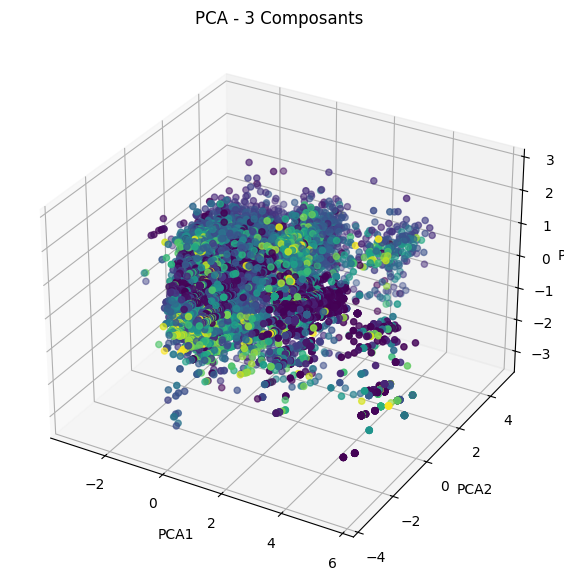

*********
Variance totale conservée : 0.62
*********


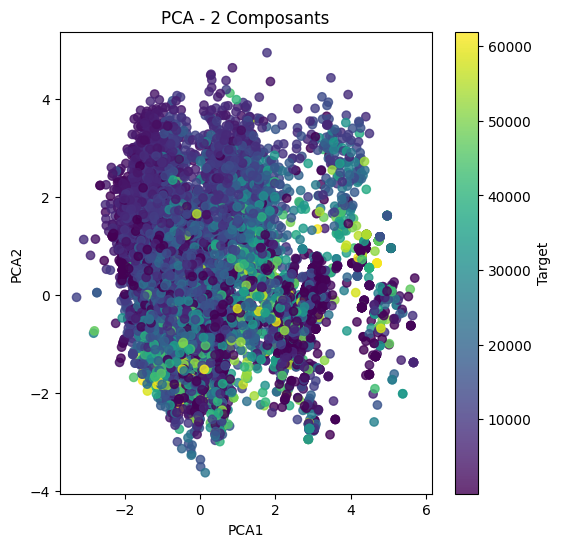

*********
Nombre de composants pour conserver 90% de la variance : 4
*********


In [ ]:

# Appliquer le prétraitement sur X
X_processed = StandardScaler().fit_transform(df_PCA[numerical_features])

# PCA avec 3 composants pour une visualisation en 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_processed)
print('*********')
print(f"Variance totale conservée : {sum(pca_3d.explained_variance_ratio_):.2f}")
print('*********')

# Visualisation en 3D
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=target_PCA, cmap='viridis')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title("PCA - 3 Composants")
plt.show()

# PCA avec 2 composants pour une visualisation en 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_processed)

# Variance cumulée
print('*********')
print(f"Variance totale conservée : {sum(pca_2d.explained_variance_ratio_):.2f}")
print('*********')

# Visualisation en 2D
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=target_PCA, cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur pour la légende
cbar = plt.colorbar(scatter)
cbar.set_label('Target')

# Ajouter des étiquettes aux axes et un titre
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("PCA - 2 Composants")

# Afficher le graphique
plt.show()


# PCA qui conserve 95% de la variance
pca_95 = PCA(n_components=0.90, svd_solver='full')
#X_processed2 = X_processed.toarray()
X_pca_95 = pca_95.fit_transform(X_processed)

# Visualisation des résultats PCA à 95% de variance expliquée
print('*********')
print(f"Nombre de composants pour conserver 90% de la variance : {X_pca_95.shape[1]}")
print('*********')



---

It is difficult to distinguish any clusters

---

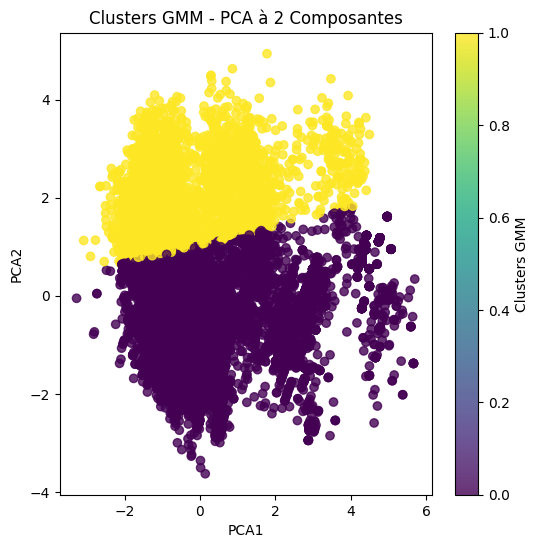

In [ ]:
n = 2
gmm = GaussianMixture(n_components=n, random_state=42,covariance_type="full")
gmm_labels = gmm.fit_predict(X_pca_2d)

# Visualisation des clusters résultants
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=gmm_labels, cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur pour la légende
cbar = plt.colorbar(scatter)
cbar.set_label('Clusters GMM')

# Ajouter des étiquettes aux axes et un titre
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title(f"Clusters GMM - PCA à {n} Composantes")

# Afficher le graphique
plt.show()

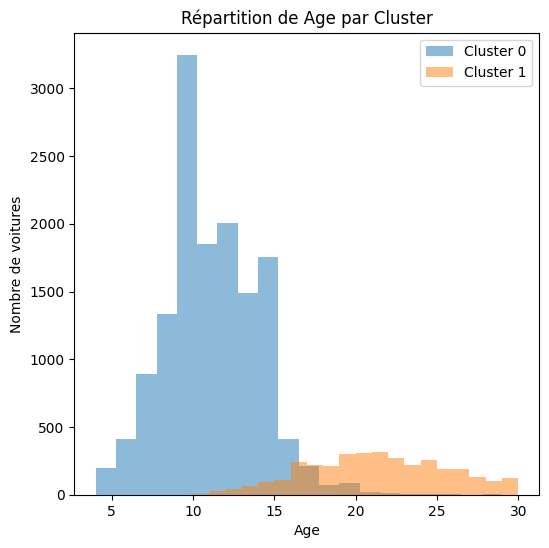

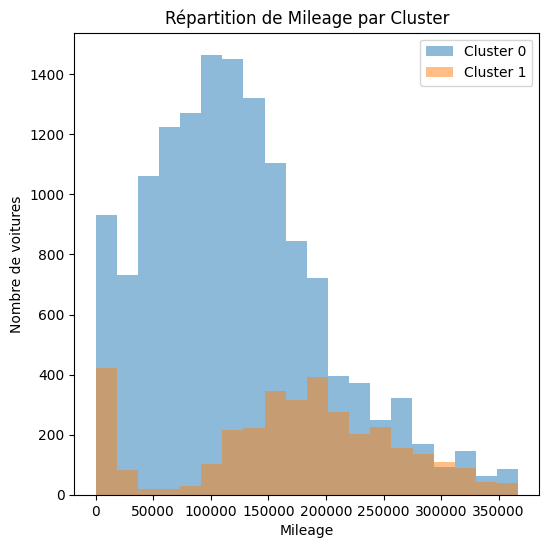

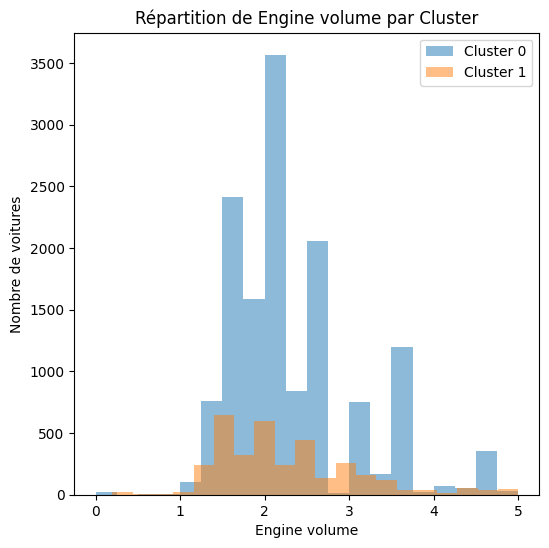

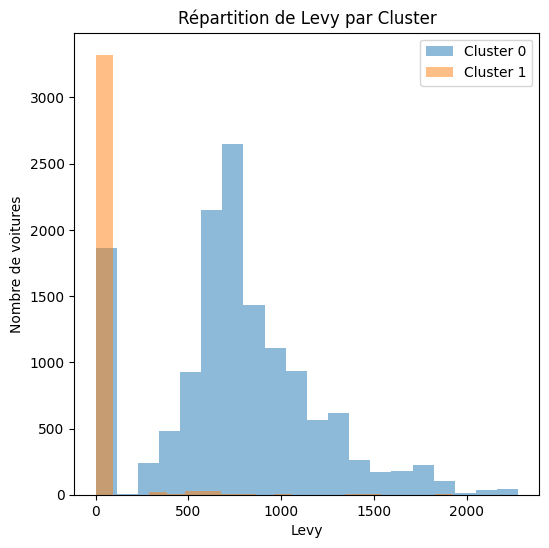

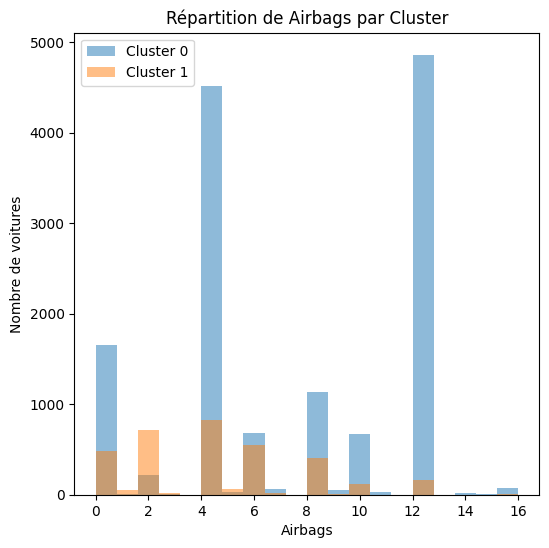

In [ ]:
# Ajouter les labels des clusters au DataFrame original
df_PCA['Cluster'] = gmm_labels
# Liste des caractéristiques à visualiser
features = ['Age', 'Mileage', 'Engine volume', 'Levy', 'Airbags']

# Analyser les statistiques descriptives pour chaque cluster
cluster_stats = df_PCA.groupby('Cluster')[features].describe()
#print(cluster_stats)


# Boucle pour tracer les histogrammes
for feature in features:
    plt.figure(figsize=(6, 6))
    for cluster in range(n):  # Nombre de clusters
        subset = df_PCA[df_PCA['Cluster'] == cluster]
        plt.hist(subset[feature], bins=20, alpha=0.5, label=f"Cluster {cluster}")
    plt.xlabel(feature)
    plt.ylabel('Nombre de voitures')
    plt.title(f"Répartition de {feature} par Cluster")
    plt.legend()
    plt.show()


---
It is interesting to note the two clusters identified by GMM allows us to distinguish young cars from old ones. However we cannot say anything concerning the other features. Let's try to use AIC and BIC to determine the number of clusters

---

Importance des Variables :
Cylinders        0.265388
Engine volume    0.252370
Levy             0.251060
Age              0.202575
Mileage          0.180839
Airbags          0.163406
dtype: float64


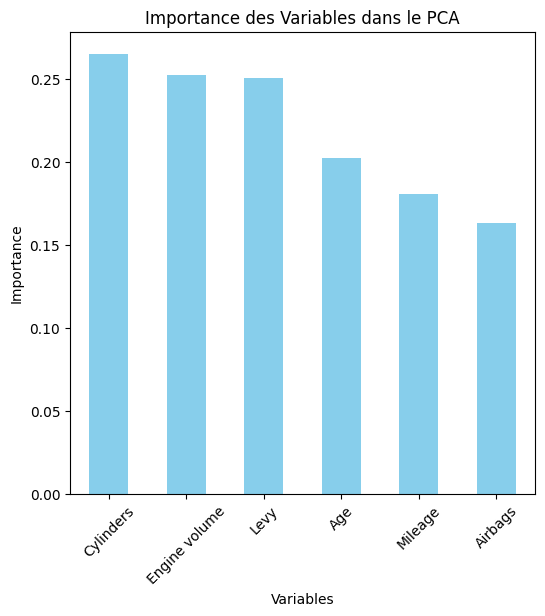

In [ ]:
# Récupérer les coefficients des composantes principales
loadings = pd.DataFrame(pca_2d.components_.T, columns=[f'PC{i+1}' for i in range(pca_2d.n_components_)], index=df[numerical_features].columns)

# Calculer l'importance globale des variables (charges * variance expliquée)
explained_variance = pca_2d.explained_variance_ratio_
importance = loadings.apply(lambda x: np.abs(x) * explained_variance, axis=1).sum(axis=1)

# Trier les variables par importance
importance_sorted = importance.sort_values(ascending=False)
print("Importance des Variables :")
print(importance_sorted)

# Visualiser les variables les plus importantes
plt.figure(figsize=(6, 6))
importance_sorted.plot(kind='bar', color='skyblue')
plt.title("Importance des Variables dans le PCA")
plt.ylabel("Importance")
plt.xlabel("Variables")
plt.xticks(rotation=45)
plt.show()

---
All the numerical features have been taken which is good

---

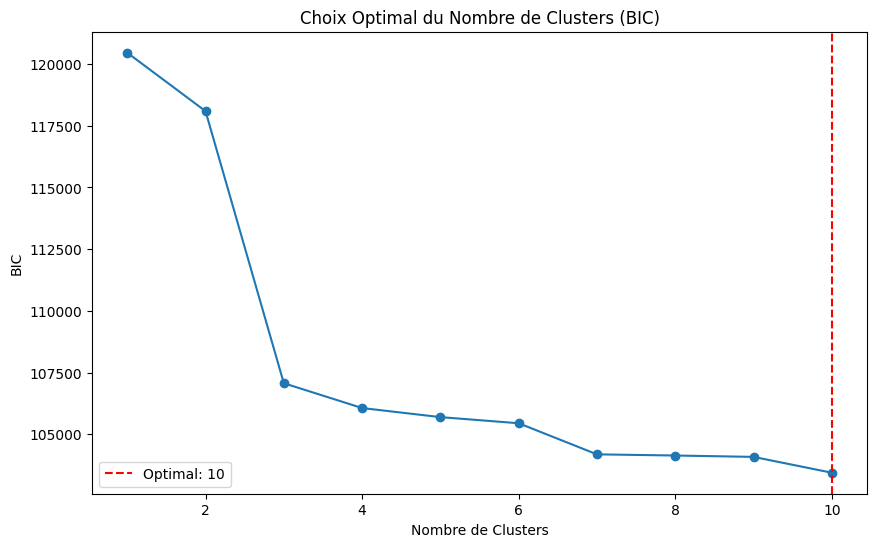

Nombre optimal de clusters selon le BIC: 10


In [ ]:
# Définir la plage des nombres de clusters à tester
n_components_range = range(1, 11)  # Tester de 1 à 10 clusters
bics = []  # Liste pour stocker les valeurs de BIC

# Calculer le BIC pour chaque nombre de clusters
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca_2d)
    bics.append(gmm.bic(X_pca_2d))

# Trouver le nombre optimal de clusters
optimal_n_components = n_components_range[np.argmin(bics)]

# Visualiser le BIC en fonction de n_components
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bics, marker='o')
plt.xlabel('Nombre de Clusters')
plt.ylabel('BIC')
plt.title('Choix Optimal du Nombre de Clusters (BIC)')
plt.axvline(optimal_n_components, color='red', linestyle='--', label=f'Optimal: {optimal_n_components}')
plt.legend()
plt.show()

print(f"Nombre optimal de clusters selon le BIC: {optimal_n_components}")

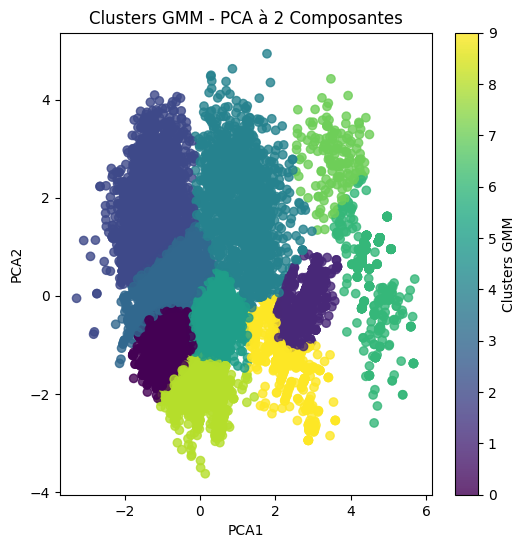

In [ ]:
gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_labels = gmm.fit_predict(X_pca_2d)

# Visualisation des clusters résultants
plt.figure(figsize=(6, 6))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=gmm_labels, cmap='viridis', alpha=0.8)

# Ajouter une barre de couleur pour la légende
cbar = plt.colorbar(scatter)
cbar.set_label('Clusters GMM')

# Ajouter des étiquettes aux axes et un titre
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title("Clusters GMM - PCA à 2 Composantes")

# Afficher le graphique
plt.show()

---

Intuitively we think it is relevant to consider too many segments which are not natural. Then we won't train our models on different segments.

---

#Models

---
Independent test set: Provides a completely honest and unbiased assessment. The model has never seen this set during training or cross-validation.

---

In [189]:
split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
df = df.reset_index(drop=True)
target = target.reset_index(drop=True)

# Diviser les données
for train_index, test_index in split.split(df):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]
    target_train = target.loc[train_index]
    target_test = target.loc[test_index]

---
Cross Validation Method - KFold and scoring Method

---


In [190]:
# Common Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2','MAE': 'neg_mean_absolute_error'}


####**In this section we only train our models with numerical features.**

In [191]:
#  Numerical Training
# ---------------------

# Numerical Features
df_num = df_train[numerical_features]

# Pipelines
pipeline_LinearRegression = make_pipeline(StandardScaler(), LinearRegression())
pipeline_elastic_Net = make_pipeline(StandardScaler(), ElasticNet())
pipeline_polynomial_regression = make_pipeline(PolynomialFeatures(), StandardScaler(), LinearRegression())
pipeline_RandomForest = make_pipeline(RandomForestRegressor(random_state=42))
pipeline_SVM = make_pipeline(StandardScaler(), SVR())
pipeline_AdaBoost = make_pipeline(AdaBoostRegressor(random_state=42))
pipeline_GradientBoosting = make_pipeline( GradientBoostingRegressor(random_state=42))
pipeline_XGBoost = make_pipeline(XGBRegressor(objective='reg:squarederror', random_state=42))
pipeline_KNN = make_pipeline(StandardScaler(), KNeighborsRegressor())

######**Hyperparameters Tuning: an attempt on subspaces with GridSearchCV**

---
We try some parameters directly with Gridsearch because we want to test some vital parameters like the depth of a tree.

---

In [ ]:

# Définir les grilles de paramètres
param_grid_LinearRegression = {}  # Pas d'hyperparamètres à optimiser ici
param_grid_elastic_Net = {
    'elasticnet__alpha': [0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
}
param_grid_polynomial_regression = {
    'polynomialfeatures__degree': [2, 3,4,5,6],
    'linearregression__fit_intercept': [True, False]
}

param_grid_SVM = {
    'svr__C': [0.1, 1.0, 10.0],
    'svr__kernel': ['linear', 'rbf', 'poly']
}

param_grid_RandomForest = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': [None,5, 10, 30, 50]
}

param_grid_AdaBoost = {
    'adaboostregressor__n_estimators': [50, 100],
    'adaboostregressor__learning_rate': [0.05, 0.1, 0.5, 1.0]
}
param_grid_GradientBoosting = {
    'gradientboostingregressor__n_estimators': [50],
    'gradientboostingregressor__learning_rate': [0.1],
    'gradientboostingregressor__max_depth': [None,5, 10, 30, 50]
}

param_grid_XGBoost = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__learning_rate': [0.05, 0.1,0.5, 1],
    'xgbregressor__max_depth': [None,5, 10, 30, 50]
}

param_grid_KNN = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 13 , 15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2]  # 1 pour Manhattan, 2 pour Euclidean
}

# Créer les GridSearchCV pour chaque modèle en utilisant le même KFold
gs_LinearRegression = GridSearchCV(pipeline_LinearRegression, param_grid_LinearRegression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_elastic_Net = GridSearchCV(pipeline_elastic_Net, param_grid_elastic_Net, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_polynomial_regression = GridSearchCV(pipeline_polynomial_regression, param_grid_polynomial_regression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_RandomForest = GridSearchCV(pipeline_RandomForest, param_grid_RandomForest, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_SVM = GridSearchCV(pipeline_SVM, param_grid_SVM, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_AdaBoost = GridSearchCV(pipeline_AdaBoost, param_grid_AdaBoost, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_GradientBoosting = GridSearchCV(pipeline_GradientBoosting, param_grid_GradientBoosting, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_XGBoost = GridSearchCV(pipeline_XGBoost,param_grid_XGBoost,cv=kf,scoring=scoring,refit='RMSE',n_jobs=-1)
gs_KNN = GridSearchCV(pipeline_KNN, param_grid_KNN, cv=kf, scoring=scoring, refit='RMSE',n_jobs=-1)




# Ajuster les modèles
gs_LinearRegression.fit(df_num, target_train)
print('Linear Done')
gs_elastic_Net.fit(df_num, target_train)
print('Elastic Net Done')
gs_polynomial_regression.fit(df_num, target_train)
print('Polynomial Done')
gs_RandomForest.fit(df_num, target_train)
print('RandomForest Done')
gs_SVM.fit(df_num, target_train)
print('SVM Done')
gs_AdaBoost.fit(df_num, target_train)
print('AdaBoost Done')
gs_GradientBoosting.fit(df_num, target_train)
print('Gradient Boosting Done')
gs_XGBoost.fit(df_num, target_train)
print('XGBoost Done')
gs_KNN.fit(df_num, target_train)
print('KNN Done')



Linear Done
Elastic Net Done
Polynomial Done
RandomForest Done


Linear Regression: RMSE = 12015.0059, R2 = 0.1788, MAE = 9048.7807
Elastic Net: RMSE = 12017.6283, R2 = 0.1785, MAE = 9045.8536
Polynomial Regression: RMSE = 9466.3148, R2 = 0.4903, MAE = 6786.7265
Random Forest: RMSE = 8121.0996, R2 = 0.6248, MAE = 4981.7119
SVM: RMSE = 12236.4783, R2 = 0.1484, MAE = 9005.9018
AdaBoost: RMSE = 11061.4571, R2 = 0.3038, MAE = 8623.6814
Gradient Boosting: RMSE = 8107.4037, R2 = 0.6260, MAE = 5295.2708
XGBoost: RMSE = 8111.4907, R2 = 0.6256, MAE = 5313.1901
KNN: RMSE = 8220.5126, R2 = 0.6153, MAE = 4856.5794


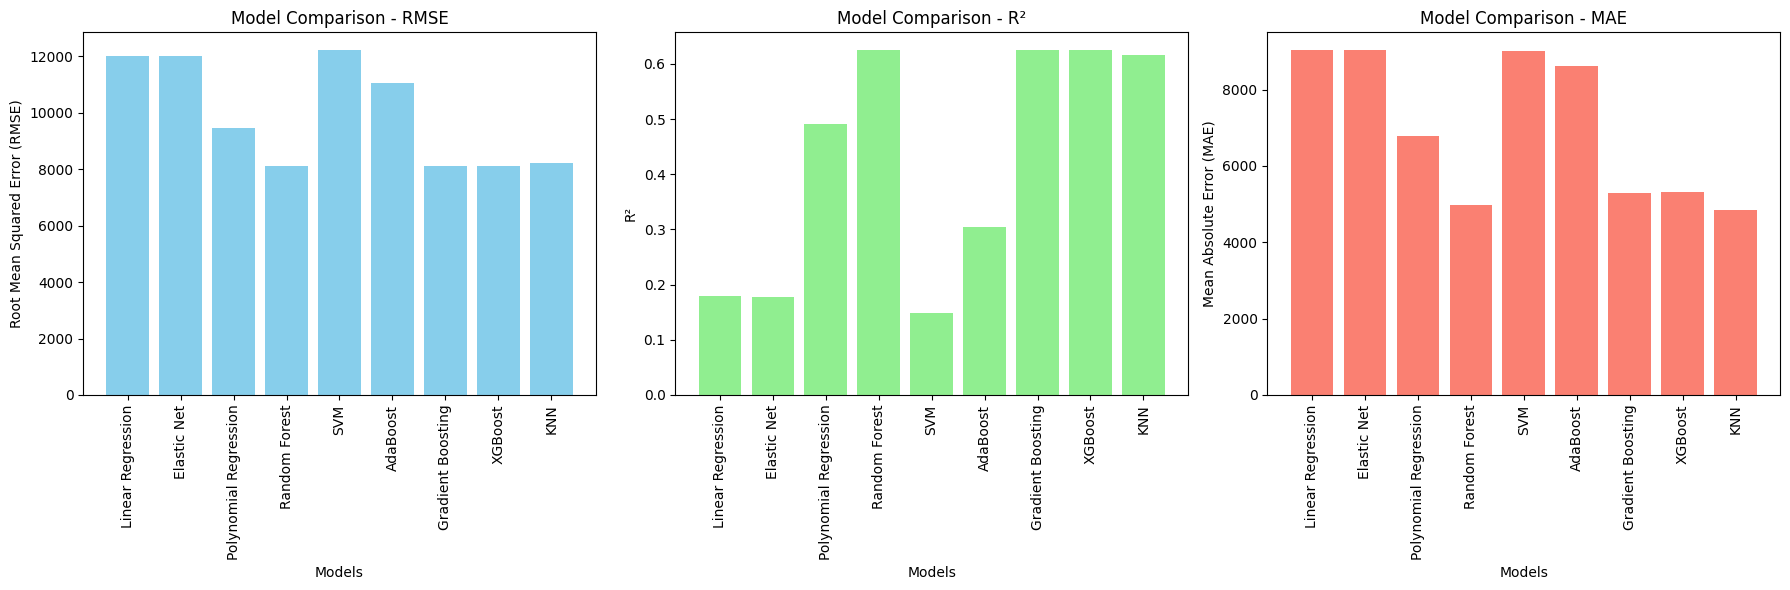

In [ ]:
results = {
    "Linear Regression": {
        "RMSE": -gs_LinearRegression.best_score_,
        "R2": gs_LinearRegression.cv_results_['mean_test_R2'][gs_LinearRegression.best_index_],
        "MAE": -gs_LinearRegression.cv_results_['mean_test_MAE'][gs_LinearRegression.best_index_]
    },
    "Elastic Net": {
        "RMSE": -gs_elastic_Net.best_score_,
        "R2": gs_elastic_Net.cv_results_['mean_test_R2'][gs_elastic_Net.best_index_],
        "MAE": -gs_elastic_Net.cv_results_['mean_test_MAE'][gs_elastic_Net.best_index_]
    },
    "Polynomial Regression": {
        "RMSE": -gs_polynomial_regression.best_score_,
        "R2": gs_polynomial_regression.cv_results_['mean_test_R2'][gs_polynomial_regression.best_index_],
        "MAE": -gs_polynomial_regression.cv_results_['mean_test_MAE'][gs_polynomial_regression.best_index_]
    },
    "Random Forest": {
        "RMSE": -gs_RandomForest.best_score_,
        "R2": gs_RandomForest.cv_results_['mean_test_R2'][gs_RandomForest.best_index_],
        "MAE": -gs_RandomForest.cv_results_['mean_test_MAE'][gs_RandomForest.best_index_]
    },
    "SVM": {
        "RMSE": -gs_SVM.best_score_,
        "R2": gs_SVM.cv_results_['mean_test_R2'][gs_SVM.best_index_],
        "MAE": -gs_SVM.cv_results_['mean_test_MAE'][gs_SVM.best_index_]
    },
    "AdaBoost": {
        "RMSE": -gs_AdaBoost.best_score_,
        "R2": gs_AdaBoost.cv_results_['mean_test_R2'][gs_AdaBoost.best_index_],
        "MAE": -gs_AdaBoost.cv_results_['mean_test_MAE'][gs_AdaBoost.best_index_]
    },
    "Gradient Boosting": {
        "RMSE": -gs_GradientBoosting.best_score_,
        "R2": gs_GradientBoosting.cv_results_['mean_test_R2'][gs_GradientBoosting.best_index_],
        "MAE": -gs_GradientBoosting.cv_results_['mean_test_MAE'][gs_GradientBoosting.best_index_]
    },
    "XGBoost": {
        "RMSE": -gs_XGBoost.best_score_,
        "R2": gs_XGBoost.cv_results_['mean_test_R2'][gs_XGBoost.best_index_],
        "MAE": -gs_XGBoost.cv_results_['mean_test_MAE'][gs_XGBoost.best_index_]
    },
    "KNN": {
        "RMSE": -gs_KNN.best_score_,
        "R2": gs_KNN.cv_results_['mean_test_R2'][gs_KNN.best_index_],
        "MAE": -gs_KNN.cv_results_['mean_test_MAE'][gs_KNN.best_index_]
    }
}

# Afficher les résultats
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R2 = {scores['R2']:.4f}, MAE = {scores['MAE']:.4f}")

# Comparaison graphique des métriques
plt.figure(figsize=(18, 6))

# RMSE
plt.subplot(1, 3, 1)
model_names = list(results.keys())
rmse_scores = [scores['RMSE'] for scores in results.values()]
plt.bar(model_names, rmse_scores, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=90)

# R2
plt.subplot(1, 3, 2)
r2_scores = [scores['R2'] for scores in results.values()]
plt.bar(model_names, r2_scores, color='lightgreen')
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model Comparison - R²")
plt.xticks(rotation=90)

# MAE
plt.subplot(1, 3, 3)
mae_scores = [scores['MAE'] for scores in results.values()]
plt.bar(model_names, mae_scores, color='salmon')
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


---
As regards to each score, it appears RandomForest and Xgboost are the best models. The best R2 is 0.60 which is low and the MAE shows the absolute error is on average 5000, which is high but somehow acceptable.

---

---
Details des meilleurs Paramètres:

---

In [ ]:
# Print the best parameters for each model based on the RMSE score
print("Best Parameters for RMSE:")
print(f"Linear Regression (RMSE): {gs_LinearRegression.best_params_}")
print(f"Elastic Net (RMSE): {gs_elastic_Net.best_params_}")
print(f"Polynomial Regression (RMSE): {gs_polynomial_regression.best_params_}")
print(f"Random Forest (RMSE): {gs_RandomForest.best_params_}")
print(f"SVM (RMSE): {gs_SVM.best_params_}")
print(f"AdaBoost (RMSE): {gs_AdaBoost.best_params_}")
print(f"Gradient Boosting (RMSE): {gs_GradientBoosting.best_params_}")
print(f"XGBoost (RMSE): {gs_XGBoost.best_params_}")
print(f"KNN (RMSE): {gs_KNN.best_params_}")



Best Parameters for RMSE:
Linear Regression (RMSE): {}
Elastic Net (RMSE): {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Polynomial Regression (RMSE): {'linearregression__fit_intercept': True, 'polynomialfeatures__degree': 4}
Random Forest (RMSE): {'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 100}
SVM (RMSE): {'svr__C': 10.0, 'svr__kernel': 'linear'}
AdaBoost (RMSE): {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 50}
Gradient Boosting (RMSE): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__n_estimators': 50}
XGBoost (RMSE): {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 50}
KNN (RMSE): {'kneighborsregressor__n_neighbors': 15, 'kneighborsregressor__p': 2, 'kneighborsregressor__weights': 'distance'}


---
We want to highlight some key parameters like maximum depth. As for Random Forest it is important to see the max_depth is 30 while GradientBoosting use only trees with a depth of 10. Unfortunately we cannot increase the number of estimators as it will take time to do so. We will see in another section how to tune those parameters

---

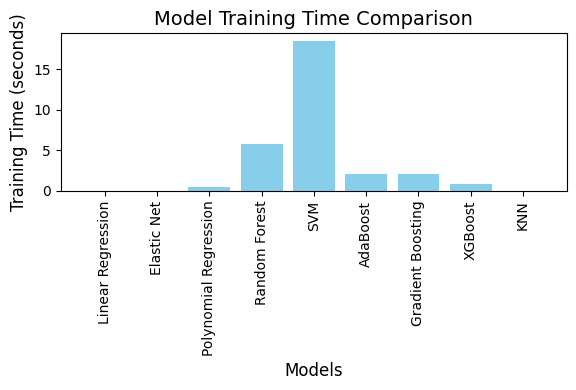

In [ ]:
# Liste pour stocker les noms des modèles et leurs temps d'entraînement
model_names = []
training_times = []

# Extraire les temps d'entraînement pour chaque GridSearchCV
def get_training_times_from_gridsearch(gs, model_name):
    model_names.append(model_name)
    # 'mean_fit_time' donne le temps moyen d'entraînement pour chaque paramètre testé dans le grid
    mean_fit_time = gs.cv_results_['mean_fit_time']
    # Prendre la valeur du temps moyen d'entraînement pour le meilleur modèle (indice du meilleur score)
    training_times.append(mean_fit_time[gs.best_index_])

# Extraire les temps d'entraînement pour chaque modèle GridSearchCV
get_training_times_from_gridsearch(gs_LinearRegression, 'Linear Regression')
get_training_times_from_gridsearch(gs_elastic_Net, 'Elastic Net')
get_training_times_from_gridsearch(gs_polynomial_regression, 'Polynomial Regression')
get_training_times_from_gridsearch(gs_RandomForest, 'Random Forest')
get_training_times_from_gridsearch(gs_SVM, 'SVM')
get_training_times_from_gridsearch(gs_AdaBoost, 'AdaBoost')
get_training_times_from_gridsearch(gs_GradientBoosting, 'Gradient Boosting')
get_training_times_from_gridsearch(gs_XGBoost, 'XGBoost')
get_training_times_from_gridsearch(gs_KNN, 'KNN')

# Tracer l'histogramme du temps d'entraînement
plt.figure(figsize=(6, 4))
plt.bar(model_names, training_times, color='skyblue')
plt.xlabel("Models", fontsize=12)
plt.ylabel("Training Time (seconds)", fontsize=12)
plt.title("Model Training Time Comparison", fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

---
SVM is the most time consuming but it strongly depends on how many parameters in the Grid seach CV. Besides We conclude we do not need to take a closer look to that model if we want to improve its performance on the numerical features

---

                   Model     Test RMSE   Test R2     Test MAE
6      Gradient Boosting   8182.478781  0.625130  5408.174875
3          Random Forest   8222.258166  0.621476  5007.594780
7                XGBoost   8319.016539  0.612515  5481.544165
8                    KNN   8490.756822  0.596351  4990.916441
2  Polynomial Regression   9822.955178  0.459749  6896.384145
5               AdaBoost  11223.675821  0.294688  8838.935648
0      Linear Regression  12004.768084  0.193102  9144.298510
1            Elastic Net  12015.680772  0.191634  9147.328928
4                    SVM  12271.119224  0.156899  9154.044428
***************


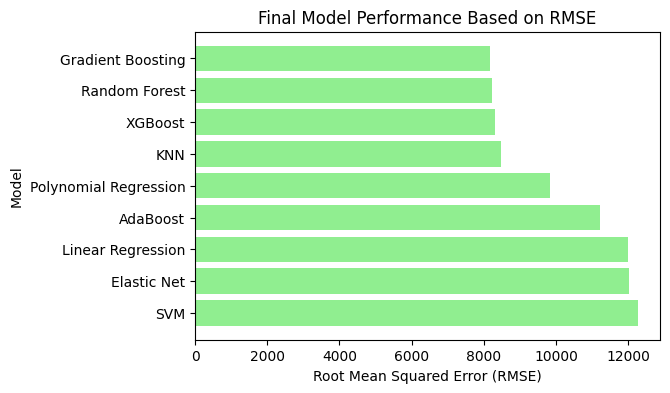

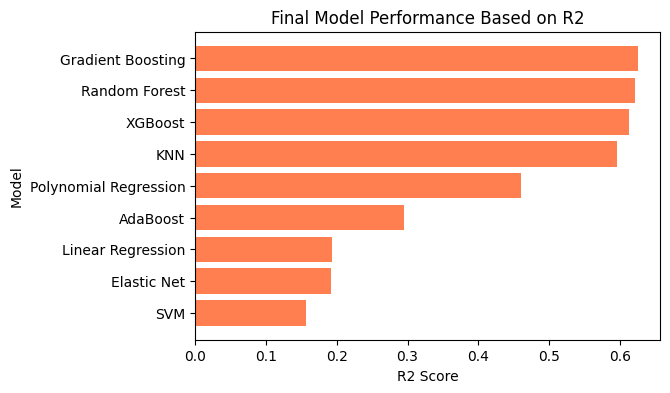

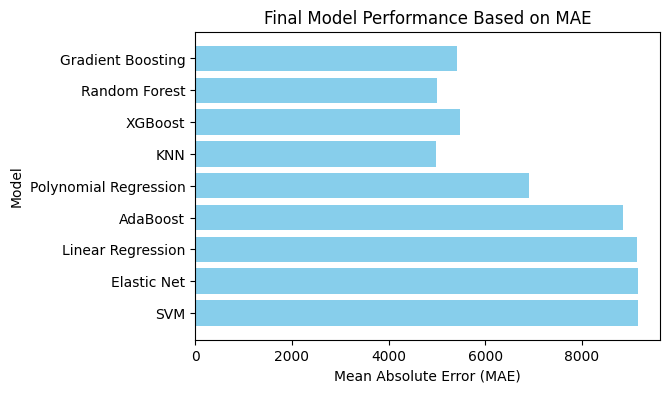

In [ ]:

# Préparer les données de test
X_test = df_test[numerical_features]  # Adapter pour correspondre à tes données
y_test = target_test  # Adapter pour correspondre à tes données
#X_test_prepared = preprocessor.fit_transform(X_test)

# Stocker les résultats finaux
final_results = []

models = {
    "Linear Regression": gs_LinearRegression,
    "Elastic Net": gs_elastic_Net,
    "Polynomial Regression": gs_polynomial_regression,
    "Random Forest": gs_RandomForest,
    "SVM": gs_SVM,
    "AdaBoost": gs_AdaBoost,
    "Gradient Boosting": gs_GradientBoosting,
    "XGBoost": gs_XGBoost,
    "KNN": gs_KNN
}

# Itérer sur les modèles pour récupérer les scores
for name, gs in models.items():
    # Récupérer le meilleur modèle
    final_model = gs.best_estimator_

    # Effectuer des prédictions sur le jeu de test
    final_predictions = final_model.predict(X_test)

    # Calculer les métriques
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    final_r2 = r2_score(y_test, final_predictions)
    final_mae = mean_absolute_error(y_test, final_predictions)

    # Ajouter les résultats
    final_results.append({
        "Model": name,
        "Test RMSE": final_rmse,
        "Test R2": final_r2,
        "Test MAE": final_mae
    })

# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Afficher les résultats triés par RMSE croissant
final_results_df = final_results_df.sort_values(by="Test RMSE", ascending=True)
print(final_results_df)
print('***************')
# Visualiser les résultats
plt.figure(figsize=(6, 4))

# Barplot des RMSE
plt.barh(final_results_df["Model"], final_results_df["Test RMSE"], color="lightgreen")
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on RMSE")
plt.gca().invert_yaxis()
#plt.savefig("RMSE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des R2
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test R2"], color="coral")
plt.xlabel("R2 Score")
plt.ylabel("Model")
plt.title("Final Model Performance Based on R2")
plt.gca().invert_yaxis()
#plt.savefig("R2_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des MAE
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test MAE"], color="skyblue")
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on MAE")
plt.gca().invert_yaxis()
#plt.savefig("MAE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()


Meilleurs modèles :
               Model   RMSE_Score  Test R2    MAE_Score
6  Gradient Boosting -8182.478781  0.62513 -5408.174875

Top 3 modèles :
               Model   RMSE_Score   Test R2    MAE_Score
6  Gradient Boosting -8182.478781  0.625130 -5408.174875
3      Random Forest -8222.258166  0.621476 -5007.594780
8                KNN -8490.756822  0.596351 -4990.916441
*************


<Figure size 600x600 with 0 Axes>

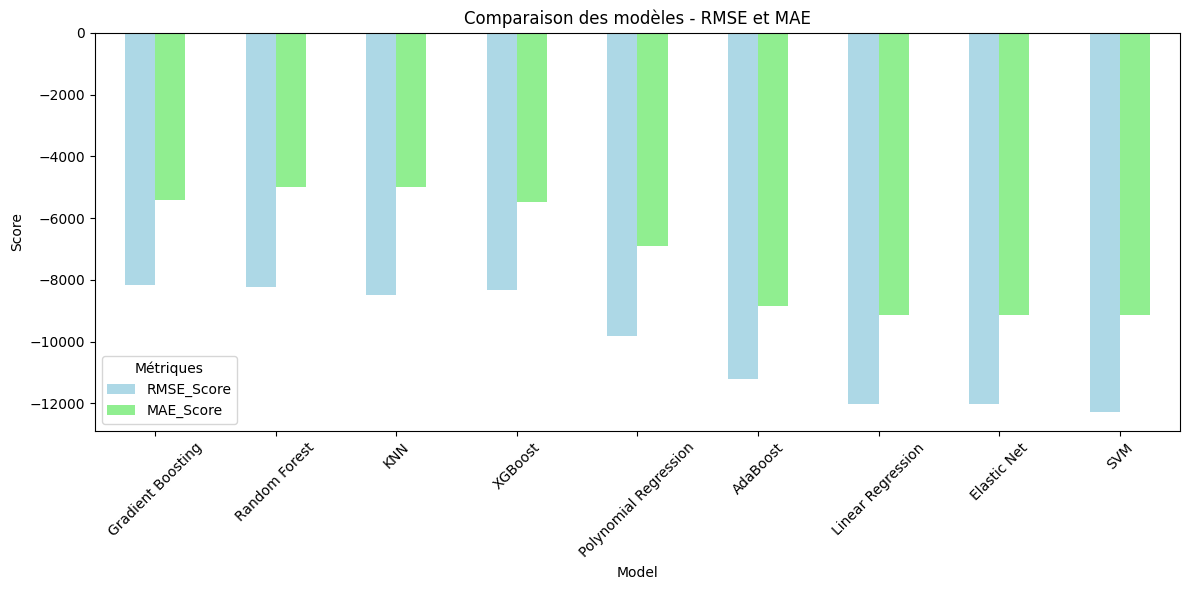

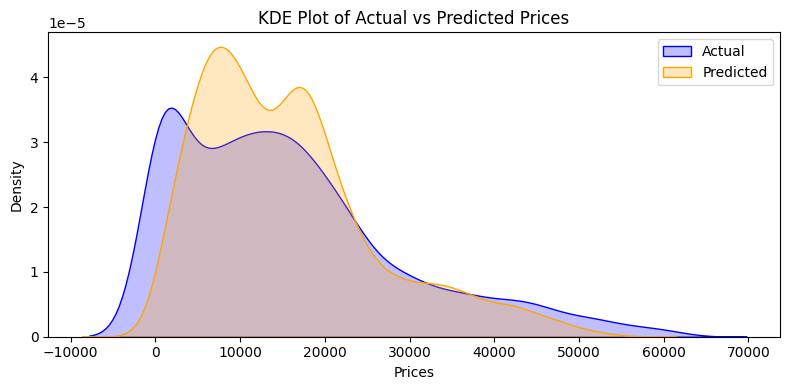

In [ ]:
# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Standardiser les scores pour le vote (inverse RMSE et MAE pour que les scores plus élevés soient meilleurs)
final_results_df['RMSE_Score'] = -final_results_df['Test RMSE']
final_results_df['MAE_Score'] = -final_results_df['Test MAE']

# Calculer le rang pour chaque métrique
final_results_df['Rank_RMSE'] = final_results_df['RMSE_Score'].rank(ascending=False)
final_results_df['Rank_R2'] = final_results_df['Test R2'].rank(ascending=False)
final_results_df['Rank_MAE'] = final_results_df['MAE_Score'].rank(ascending=False)

# Total des rangs
final_results_df['Total_Rank'] = final_results_df[['Rank_RMSE', 'Rank_R2', 'Rank_MAE']].sum(axis=1)

# Trier les résultats par rang total
final_results_df = final_results_df.sort_values(by='Total_Rank', ascending=True)

# Afficher le ou les meilleurs modèles
best_models = final_results_df[final_results_df['Total_Rank'] == final_results_df['Total_Rank'].min()]
print("Meilleurs modèles :")
print(best_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])

# Si plusieurs modèles ont le même rang, afficher les trois premiers
top_models = final_results_df.nsmallest(3, 'Total_Rank')
print("\nTop 3 modèles :")
print(top_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])
print('*************')
# Visualiser les performances
plt.figure(figsize=(6, 6))
final_results_df.set_index('Model')[['RMSE_Score', 'MAE_Score']].plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title("Comparaison des modèles - RMSE et MAE")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Métriques")
plt.tight_layout()
plt.show()

# KDE Plot - Meilleur modèle
best_model_name = best_models.iloc[0]['Model']
best_model = models[best_model_name].best_estimator_

# Prédictions du meilleur modèle
y_pred_best = best_model.predict(X_test)

# Créer un DataFrame pour la visualisation
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

# KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.kdeplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig("Kde_ActualvsPredicted_random_forest_vf_onehot.tiff", format="tiff", dpi=300)
plt.show()


---

We created a rank based on the three score and we have chosen the best model to see compare the real and the predicted distribution. The model which has beeen chosen is GradientBoosting. However we can see the model does not fit very well with the real distribution.

---

####**Numerical and Categorical Features**

---
We define the parameters to use in the Gridsearch

---

In [ ]:
# Définir les grilles de paramètres
param_grid_LinearRegression = {}  # Pas d'hyperparamètres à optimiser ici
param_grid_elastic_Net = {
    'elasticnet__alpha': [0.1, 1, 10], # 0.1 1 10
    'elasticnet__l1_ratio': [0.2, 0.5, 0.8] # 0.2 0.5 0.8
}
param_grid_polynomial_regression = {
    'preprocessor__num__polynomial_features__degree': [1,2,3,4,5,6], # 1 à 10
    'linearregression__fit_intercept': [True, False]
}

param_grid_SVM = {
    'svr__C': [0.1], #0.1 ,  1 & 10
    'svr__kernel': ['linear', 'rbf']
}

param_grid_RandomForest = {
    'randomforestregressor__n_estimators': [25],         # 50,100
    'randomforestregressor__max_depth': [None,5, 10, 20, 30, 50]
}

param_grid_AdaBoost = {
    'adaboostregressor__n_estimators': [25], # 50,100
    'adaboostregressor__learning_rate': [0.05, 0.1, 0.5]
}
param_grid_GradientBoosting = {
    'gradientboostingregressor__n_estimators': [25],  #50,100
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.5],
    'gradientboostingregressor__max_depth': [None,5, 10,20, 30, 50]
}

param_grid_XGBoost = {
    'xgbregressor__n_estimators': [25], # 50 100
    'xgbregressor__learning_rate': [0.05, 0.1, 0.5], # 0.05 0.1 1
    'xgbregressor__max_depth': [None,5, 10, 20, 30, 50]
}

param_grid_KNN = {
    'kneighborsregressor__n_neighbors': [3, 5, 7, 9, 11, 13,15],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2]  # 1 pour Manhattan, 2 pour Euclidean
}

#####**Only OneHotEncoding**

In [ ]:
#  Numerical & Categorical Training
# ---------------------

# Pipelines

preprocessor = preprocessor_onehot_encoding
# Pipelines pour chaque modèle avec le préprocesseur
pipeline_LinearRegression = Pipeline([
    ('preprocessor', preprocessor),
    ('linearregression', LinearRegression())
])

pipeline_elastic_Net = Pipeline([
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet())
])

pipeline_polynomial_regression = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', max_categories=30), categorical_features),
        ('num', Pipeline([
            ('scaler', StandardScaler()),  # Normalisation des données numériques
            ('polynomial_features', PolynomialFeatures())  # Ajout des termes polynomiaux
        ]), numerical_features)
    ])),
    ('linearregression', LinearRegression())  # Régression linéaire après transformation
])

pipeline_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])

pipeline_SVM = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour les SVM
    ('svr', SVR())
])

pipeline_AdaBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboostregressor', AdaBoostRegressor(random_state=42))
])

pipeline_GradientBoosting = Pipeline([
    ('preprocessor', preprocessor),
    ('gradientboostingregressor', GradientBoostingRegressor(random_state=42))
])

pipeline_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour KNN
    ('kneighborsregressor', KNeighborsRegressor())
])

# Liste de tous les pipelines
pipelines = {
    'Linear Regression': pipeline_LinearRegression,
    'Elastic Net': pipeline_elastic_Net,
    'Polynomial Regression': pipeline_polynomial_regression,
    'Random Forest': pipeline_RandomForest,
    'SVM': pipeline_SVM,
    'AdaBoost': pipeline_AdaBoost,
    'Gradient Boosting': pipeline_GradientBoosting,
    'XGBoost': pipeline_XGBoost,
    'KNN': pipeline_KNN
}


In [ ]:

# Créer les GridSearchCV pour chaque modèle en utilisant le même KFold
gs_LinearRegression = GridSearchCV(pipeline_LinearRegression, param_grid_LinearRegression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_elastic_Net = GridSearchCV(pipeline_elastic_Net, param_grid_elastic_Net, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_polynomial_regression = GridSearchCV(pipeline_polynomial_regression, param_grid_polynomial_regression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_RandomForest = GridSearchCV(pipeline_RandomForest, param_grid_RandomForest, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_SVM = GridSearchCV(pipeline_SVM, param_grid_SVM, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_AdaBoost = GridSearchCV(pipeline_AdaBoost, param_grid_AdaBoost, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_GradientBoosting = GridSearchCV(pipeline_GradientBoosting, param_grid_GradientBoosting, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_XGBoost = GridSearchCV(pipeline_XGBoost,param_grid_XGBoost,cv=kf,scoring=scoring,refit='RMSE',n_jobs=-1)
gs_KNN = GridSearchCV(pipeline_KNN, param_grid_KNN, cv=kf, scoring=scoring, refit='RMSE',n_jobs=-1)

# Ajuster les modèles
gs_LinearRegression.fit(df_train, target_train)
print('Linear Done')
gs_elastic_Net.fit(df_train, target_train)
print('Elastic Net Done')
gs_polynomial_regression.fit(df_train, target_train)
print('Polynomial Done')



Linear Done
Elastic Net Done
Polynomial Done


In [ ]:
gs_RandomForest.fit(df_train, target_train)
print('RandomForest Done')
gs_SVM.fit(df_train, target_train)
print('SVM Done')
gs_AdaBoost.fit(df_train, target_train)
print('AdaBoost Done')

gs_GradientBoosting.fit(df_train, target_train)
print('Gradient Boosting Done')
gs_XGBoost.fit(df_train, target_train)
print('XGBoost Done')
gs_KNN.fit(df_train, target_train)
print('KNN Done')

RandomForest Done
SVM Done
AdaBoost Done
Gradient Boosting Done
XGBoost Done


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNN Done


In [ ]:
# Print the best parameters for each model based on the RMSE score
print("Best Parameters for RMSE:")
print(f"Linear Regression (RMSE): {gs_LinearRegression.best_params_}")
print(f"Elastic Net (RMSE): {gs_elastic_Net.best_params_}")
print(f"Polynomial Regression (RMSE): {gs_polynomial_regression.best_params_}")
print(f"Random Forest (RMSE): {gs_RandomForest.best_params_}")
print(f"SVM (RMSE): {gs_SVM.best_params_}")
print(f"AdaBoost (RMSE): {gs_AdaBoost.best_params_}")
print(f"Gradient Boosting (RMSE): {gs_GradientBoosting.best_params_}")
print(f"XGBoost (RMSE): {gs_XGBoost.best_params_}")
print(f"KNN (RMSE): {gs_KNN.best_params_}")



Best Parameters for RMSE:
Linear Regression (RMSE): {}
Elastic Net (RMSE): {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Polynomial Regression (RMSE): {'linearregression__fit_intercept': True, 'preprocessor__num__polynomial_features__degree': 4}
Random Forest (RMSE): {'randomforestregressor__max_depth': 30, 'randomforestregressor__n_estimators': 25}
SVM (RMSE): {'svr__C': 0.1, 'svr__kernel': 'linear'}
AdaBoost (RMSE): {'adaboostregressor__learning_rate': 0.1, 'adaboostregressor__n_estimators': 25}
Gradient Boosting (RMSE): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__n_estimators': 25}
XGBoost (RMSE): {'xgbregressor__learning_rate': 0.5, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 25}
KNN (RMSE): {'kneighborsregressor__n_neighbors': 9, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'distance'}


Linear Regression: RMSE = 10014.3546, R2 = 0.4295, MAE = 7457.7356
Elastic Net: RMSE = 10247.9139, R2 = 0.4026, MAE = 7660.7649
Polynomial Regression: RMSE = 8561.1410, R2 = 0.5830, MAE = 6081.9556
Random Forest: RMSE = 6248.4711, R2 = 0.7775, MAE = 3657.2918
SVM: RMSE = 13258.8932, R2 = 0.0001, MAE = 9867.2115
AdaBoost: RMSE = 10608.7768, R2 = 0.3597, MAE = 8294.4970
Gradient Boosting: RMSE = 6549.7396, R2 = 0.7556, MAE = 4309.4269
XGBoost: RMSE = 6523.7581, R2 = 0.7576, MAE = 3977.2313
KNN: RMSE = 7080.1326, R2 = 0.7147, MAE = 4020.7342
****************


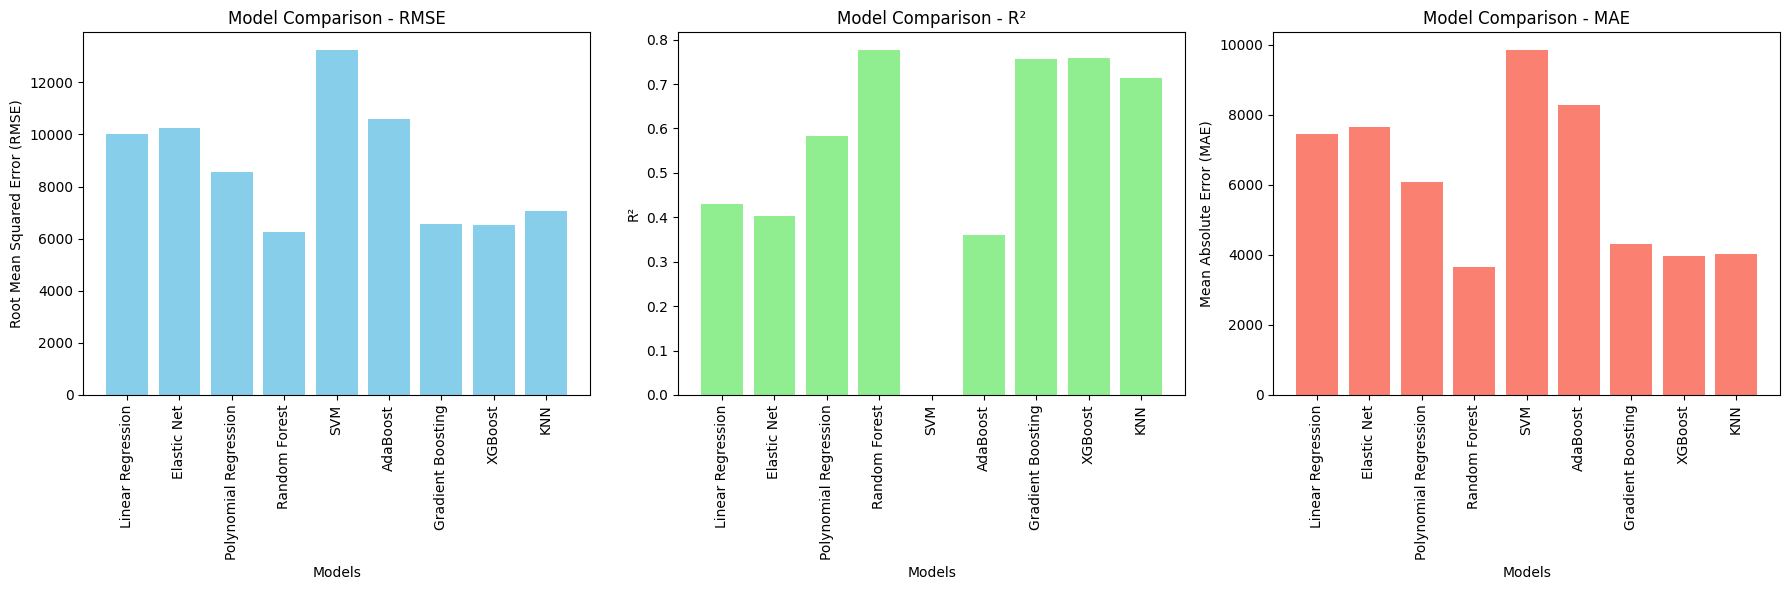

In [ ]:
results = {
    "Linear Regression": {
        "RMSE": -gs_LinearRegression.best_score_,
        "R2": gs_LinearRegression.cv_results_['mean_test_R2'][gs_LinearRegression.best_index_],
        "MAE": -gs_LinearRegression.cv_results_['mean_test_MAE'][gs_LinearRegression.best_index_]
    },
    "Elastic Net": {
        "RMSE": -gs_elastic_Net.best_score_,
        "R2": gs_elastic_Net.cv_results_['mean_test_R2'][gs_elastic_Net.best_index_],
        "MAE": -gs_elastic_Net.cv_results_['mean_test_MAE'][gs_elastic_Net.best_index_]
    },
    "Polynomial Regression": {
        "RMSE": -gs_polynomial_regression.best_score_,
        "R2": gs_polynomial_regression.cv_results_['mean_test_R2'][gs_polynomial_regression.best_index_],
        "MAE": -gs_polynomial_regression.cv_results_['mean_test_MAE'][gs_polynomial_regression.best_index_]
    },
    "Random Forest": {
        "RMSE": -gs_RandomForest.best_score_,
        "R2": gs_RandomForest.cv_results_['mean_test_R2'][gs_RandomForest.best_index_],
        "MAE": -gs_RandomForest.cv_results_['mean_test_MAE'][gs_RandomForest.best_index_]
    },
    "SVM": {
        "RMSE": -gs_SVM.best_score_,
        "R2": gs_SVM.cv_results_['mean_test_R2'][gs_SVM.best_index_],
        "MAE": -gs_SVM.cv_results_['mean_test_MAE'][gs_SVM.best_index_]
    },
    "AdaBoost": {
        "RMSE": -gs_AdaBoost.best_score_,
        "R2": gs_AdaBoost.cv_results_['mean_test_R2'][gs_AdaBoost.best_index_],
        "MAE": -gs_AdaBoost.cv_results_['mean_test_MAE'][gs_AdaBoost.best_index_]
    },
    "Gradient Boosting": {
        "RMSE": -gs_GradientBoosting.best_score_,
        "R2": gs_GradientBoosting.cv_results_['mean_test_R2'][gs_GradientBoosting.best_index_],
        "MAE": -gs_GradientBoosting.cv_results_['mean_test_MAE'][gs_GradientBoosting.best_index_]
    },
    "XGBoost": {
        "RMSE": -gs_XGBoost.best_score_,
        "R2": gs_XGBoost.cv_results_['mean_test_R2'][gs_XGBoost.best_index_],
        "MAE": -gs_XGBoost.cv_results_['mean_test_MAE'][gs_XGBoost.best_index_]
    },
    "KNN": {
        "RMSE": -gs_KNN.best_score_,
        "R2": gs_KNN.cv_results_['mean_test_R2'][gs_KNN.best_index_],
        "MAE": -gs_KNN.cv_results_['mean_test_MAE'][gs_KNN.best_index_]
    }
}

# Afficher les résultats
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R2 = {scores['R2']:.4f}, MAE = {scores['MAE']:.4f}")
print('****************')
# Comparaison graphique des métriques
plt.figure(figsize=(18, 6))

# RMSE
plt.subplot(1, 3, 1)
model_names = list(results.keys())
rmse_scores = [scores['RMSE'] for scores in results.values()]
plt.bar(model_names, rmse_scores, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=90)

# R2
plt.subplot(1, 3, 2)
r2_scores = [scores['R2'] for scores in results.values()]
plt.bar(model_names, r2_scores, color='lightgreen')
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model Comparison - R²")
plt.xticks(rotation=90)

# MAE
plt.subplot(1, 3, 3)
mae_scores = [scores['MAE'] for scores in results.values()]
plt.bar(model_names, mae_scores, color='salmon')
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


---

Using Onehot Encoding alone to encode the categorical features, Random Forest wins the battle. We can conclude it is better to use the categorcial features as the best R2 score is close to 0.8. On average, the absolute error is worth under 4000, which is better.

---

                   Model     Test RMSE   Test R2      Test MAE
3          Random Forest   6283.237771  0.778956   3641.801773
6      Gradient Boosting   6688.908989  0.749492   4421.003154
7                XGBoost   6753.291984  0.744646   4108.834927
8                    KNN   7013.495181  0.724590   4014.534279
2  Polynomial Regression   8802.882134  0.566129   6131.406925
0      Linear Regression  10135.492221  0.424824   7563.243619
1            Elastic Net  10303.005809  0.405655   7724.955186
5               AdaBoost  10613.581704  0.369282   8326.506458
4                    SVM  13314.769775  0.007391  10036.688820
***************


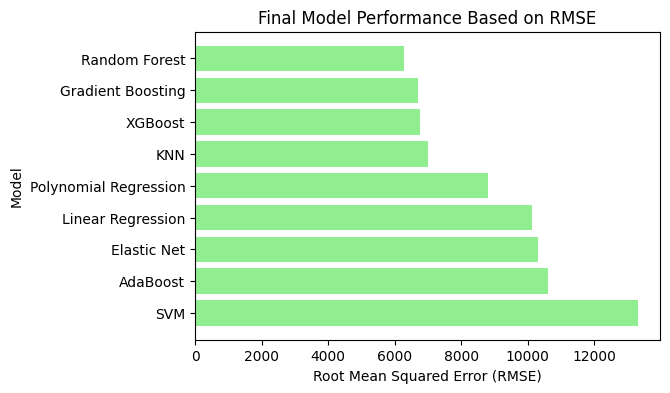

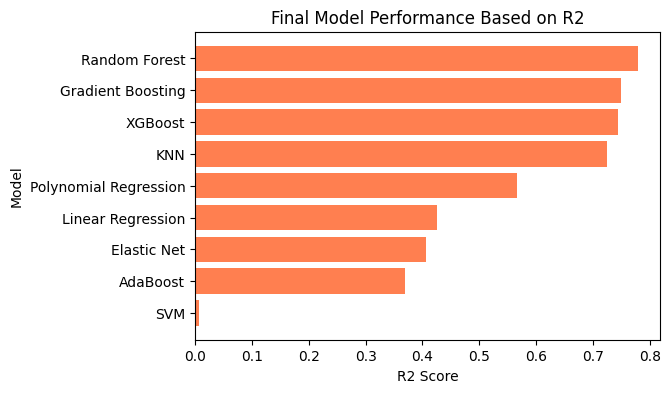

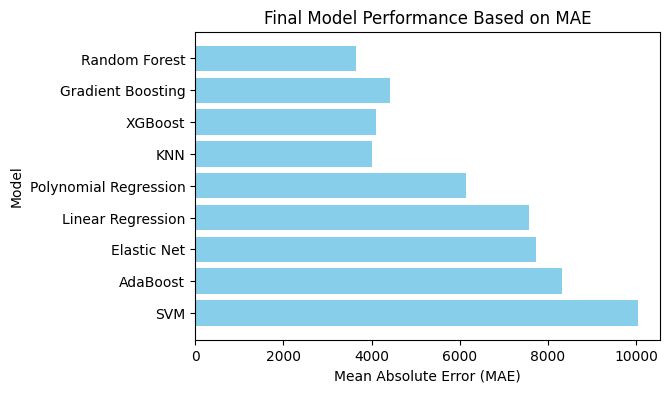

In [ ]:

# Préparer les données de test
X_test = df_test  # Adapter pour correspondre à tes données
y_test = target_test  # Adapter pour correspondre à tes données
#X_test_prepared = preprocessor.fit_transform(X_test)

# Stocker les résultats finaux
final_results = []

models = {
    "Linear Regression": gs_LinearRegression,
    "Elastic Net": gs_elastic_Net,
    "Polynomial Regression": gs_polynomial_regression,
    "Random Forest": gs_RandomForest,
    "SVM": gs_SVM,
    "AdaBoost": gs_AdaBoost,
    "Gradient Boosting": gs_GradientBoosting,
    "XGBoost": gs_XGBoost,
    "KNN": gs_KNN
}

# Itérer sur les modèles pour récupérer les scores
for name, gs in models.items():
    # Récupérer le meilleur modèle
    final_model = gs.best_estimator_

    # Effectuer des prédictions sur le jeu de test
    final_predictions = final_model.predict(X_test)

    # Calculer les métriques
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    final_r2 = r2_score(y_test, final_predictions)
    final_mae = mean_absolute_error(y_test, final_predictions)

    # Ajouter les résultats
    final_results.append({
        "Model": name,
        "Test RMSE": final_rmse,
        "Test R2": final_r2,
        "Test MAE": final_mae
    })

# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Afficher les résultats triés par RMSE croissant
final_results_df = final_results_df.sort_values(by="Test RMSE", ascending=True)
print(final_results_df)
print('***************')
# Visualiser les résultats
plt.figure(figsize=(6, 4))

# Barplot des RMSE
plt.barh(final_results_df["Model"], final_results_df["Test RMSE"], color="lightgreen")
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on RMSE")
plt.gca().invert_yaxis()
#plt.savefig("RMSE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des R2
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test R2"], color="coral")
plt.xlabel("R2 Score")
plt.ylabel("Model")
plt.title("Final Model Performance Based on R2")
plt.gca().invert_yaxis()
#plt.savefig("R2_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des MAE
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test MAE"], color="skyblue")
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on MAE")
plt.gca().invert_yaxis()
#plt.savefig("MAE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()


Meilleurs modèles :
           Model   RMSE_Score   Test R2    MAE_Score
3  Random Forest -6283.237771  0.778956 -3641.801773

Top 3 modèles :
               Model   RMSE_Score   Test R2    MAE_Score
3      Random Forest -6283.237771  0.778956 -3641.801773
6  Gradient Boosting -6688.908989  0.749492 -4421.003154
7            XGBoost -6753.291984  0.744646 -4108.834927
*************


<Figure size 600x600 with 0 Axes>

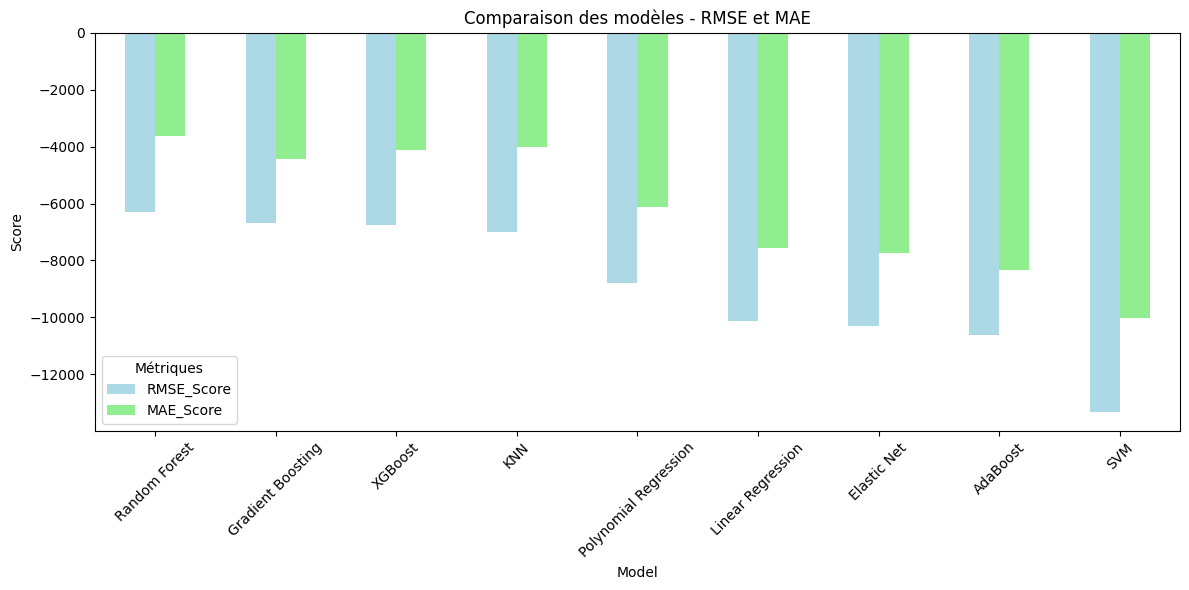

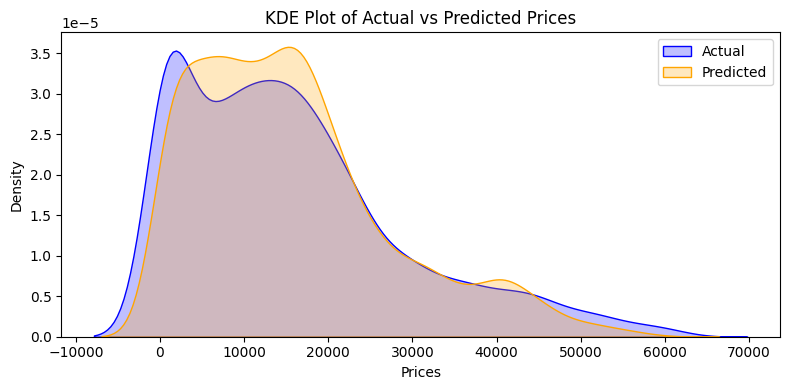

In [ ]:
# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Standardiser les scores pour le vote (inverse RMSE et MAE pour que les scores plus élevés soient meilleurs)
final_results_df['RMSE_Score'] = -final_results_df['Test RMSE']
final_results_df['MAE_Score'] = -final_results_df['Test MAE']

# Calculer le rang pour chaque métrique
final_results_df['Rank_RMSE'] = final_results_df['RMSE_Score'].rank(ascending=False)
final_results_df['Rank_R2'] = final_results_df['Test R2'].rank(ascending=False)
final_results_df['Rank_MAE'] = final_results_df['MAE_Score'].rank(ascending=False)

# Total des rangs
final_results_df['Total_Rank'] = final_results_df[['Rank_RMSE', 'Rank_R2', 'Rank_MAE']].sum(axis=1)

# Trier les résultats par rang total
final_results_df = final_results_df.sort_values(by='Total_Rank', ascending=True)

# Afficher le ou les meilleurs modèles
best_models = final_results_df[final_results_df['Total_Rank'] == final_results_df['Total_Rank'].min()]
print("Meilleurs modèles :")
print(best_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])

# Si plusieurs modèles ont le même rang, afficher les trois premiers
top_models = final_results_df.nsmallest(3, 'Total_Rank')
print("\nTop 3 modèles :")
print(top_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])
print('*************')
# Visualiser les performances
plt.figure(figsize=(6, 6))
final_results_df.set_index('Model')[['RMSE_Score', 'MAE_Score']].plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title("Comparaison des modèles - RMSE et MAE")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Métriques")
plt.tight_layout()
plt.show()

# KDE Plot - Meilleur modèle
best_model_name = best_models.iloc[0]['Model']
best_model = models[best_model_name].best_estimator_

# Prédictions du meilleur modèle
y_pred_best = best_model.predict(X_test)

# Créer un DataFrame pour la visualisation
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

# KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.kdeplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
x_min = min(plot_data['Actual'].min(), plot_data['Predicted'].min())
x_max = max(plot_data['Actual'].max(), plot_data['Predicted'].max())
plt.xlim(x_min, x_max + 5)  # Ajouter une marge de 5 unités
plt.savefig("Kde_ActualvsPredicted_random_forest_vf_onehot.tiff", format="tiff", dpi=300)
plt.show()


---

The KDE plot fits better than using only the numerical features.

---

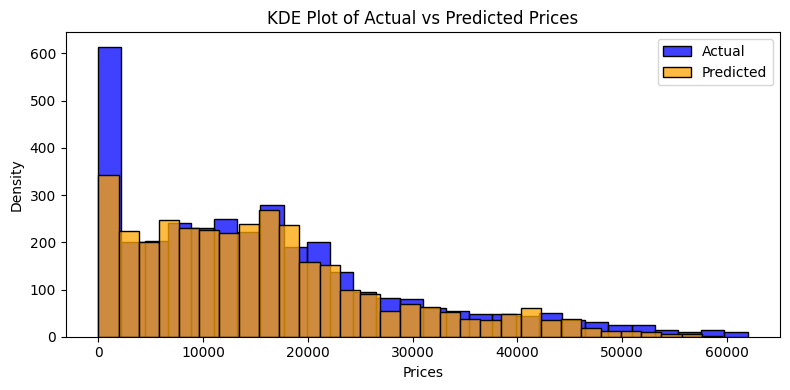

In [ ]:
# KDE plot
plt.figure(figsize=(8, 4))
sns.histplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.histplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
#plt.savefig("Hist_ActualvsPredicted_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

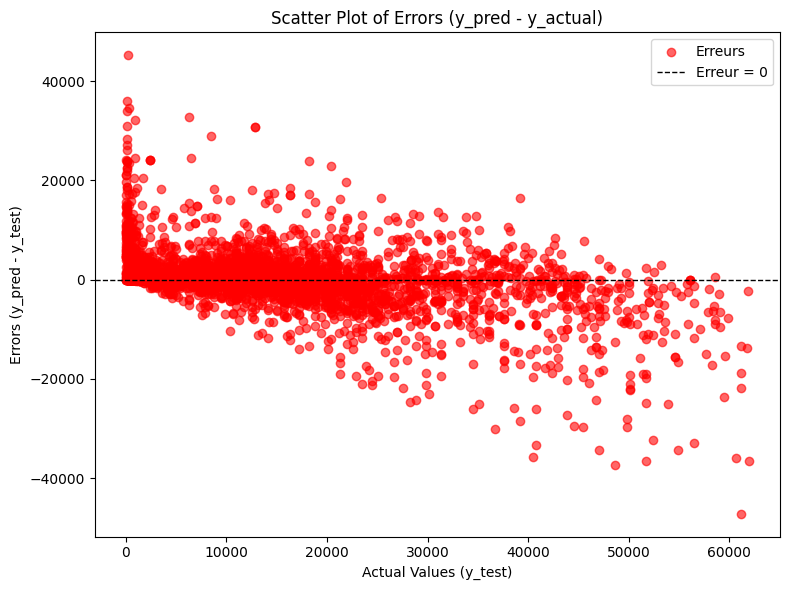

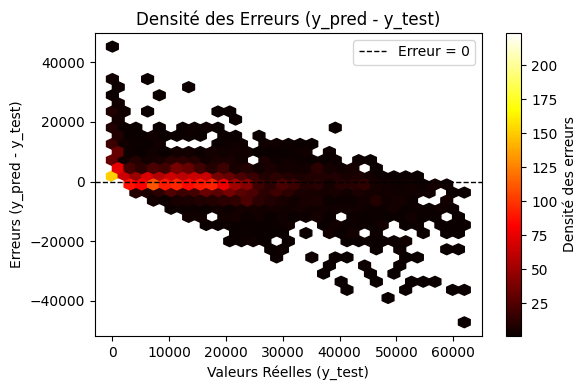

In [ ]:
# Calculate the errors
errors = y_pred_best - y_test

# Créer un scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, errors, alpha=0.6, color='red', label='Erreurs')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')
plt.title('Scatter Plot of Errors (y_pred - y_actual)')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Errors (y_pred - y_test)')
plt.legend()
plt.tight_layout()
#plt.savefig("Scatter_error_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()



# Créer un hexbin plot pour les erreurs
plt.figure(figsize=(6, 4))
plt.hexbin(y_test, errors, gridsize=30, cmap='hot', mincnt=1)  # gridsize ajuste la taille des hexagones
plt.colorbar(label='Densité des erreurs')

# Ajouter une ligne pour l'erreur nulle
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')

# Ajouter des labels et un titre
plt.title('Densité des Erreurs (y_pred - y_test)')
plt.xlabel('Valeurs Réelles (y_test)')
plt.ylabel('Erreurs (y_pred - y_test)')
plt.legend()
plt.tight_layout()
plt.show()

---
We observe a negative correlation between the error and the actual target. Indeed the low prices are overestimated while the high prices are underestimated. Overall the Lion's share of errors are close to zero.

---

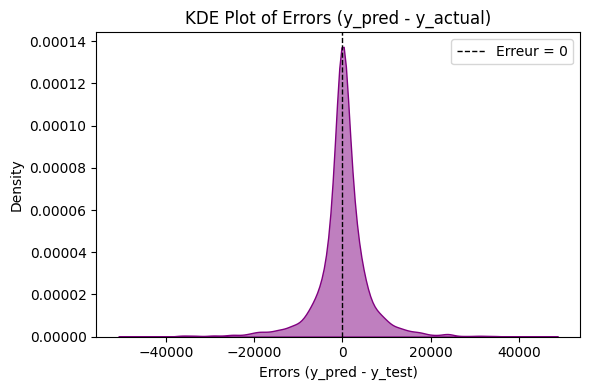

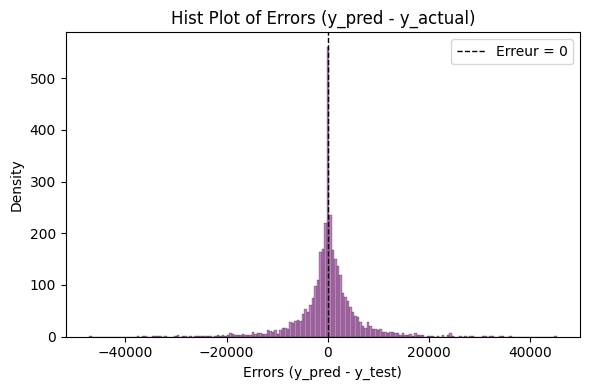

In [ ]:
# KDE plot des erreurs
plt.figure(figsize=(6, 4))
sns.kdeplot(errors, fill=True, color='purple', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')
plt.title('KDE Plot of Errors (y_pred - y_actual)')
plt.xlabel('Errors (y_pred - y_test)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
#plt.savefig("kde_plot_error_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Hist plot des erreurs
plt.figure(figsize=(6, 4))
sns.histplot(errors, fill=True, color='purple', alpha=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')
plt.title('Hist Plot of Errors (y_pred - y_actual)')
plt.xlabel('Errors (y_pred - y_test)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
#plt.savefig("histogram_error_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()



---

The distribution has long, wide tails; however, it appears to be centered around 0 with a very narrow peak.

---

#####**With Target Encoding**

In [ ]:
preprocessor = preprocessor_target_encoding

######**Same code as before**

In [ ]:
#  Numerical & Categorical Training
# ---------------------

# Pipelines

# Pipelines pour chaque modèle avec le préprocesseur
pipeline_LinearRegression = Pipeline([
    ('preprocessor', preprocessor),
    ('linearregression', LinearRegression())
])

pipeline_elastic_Net = Pipeline([
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet())
])

pipeline_polynomial_regression = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', TargetEncoder(cv=3,target_type='continuous'),categorical_features),
        ('num', Pipeline([
            ('scaler', StandardScaler()),  # Normalisation des données numériques
            ('polynomial_features', PolynomialFeatures())  # Ajout des termes polynomiaux
        ]), numerical_features)
    ])),
    ('linearregression', LinearRegression())  # Régression linéaire après transformation
])

pipeline_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])

pipeline_SVM = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour les SVM
    ('svr', SVR())
])

pipeline_AdaBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboostregressor', AdaBoostRegressor(random_state=42))
])

pipeline_GradientBoosting = Pipeline([
    ('preprocessor', preprocessor),
    ('gradientboostingregressor', GradientBoostingRegressor(random_state=42))
])

pipeline_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour KNN
    ('kneighborsregressor', KNeighborsRegressor())
])

# Liste de tous les pipelines
pipelines = {
    'Linear Regression': pipeline_LinearRegression,
    'Elastic Net': pipeline_elastic_Net,
    'Polynomial Regression': pipeline_polynomial_regression,
    'Random Forest': pipeline_RandomForest,
    'SVM': pipeline_SVM,
    'AdaBoost': pipeline_AdaBoost,
    'Gradient Boosting': pipeline_GradientBoosting,
    'XGBoost': pipeline_XGBoost,
    'KNN': pipeline_KNN
}


# Créer les GridSearchCV pour chaque modèle en utilisant le même KFold
gs_LinearRegression = GridSearchCV(pipeline_LinearRegression, param_grid_LinearRegression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_elastic_Net = GridSearchCV(pipeline_elastic_Net, param_grid_elastic_Net, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_polynomial_regression = GridSearchCV(pipeline_polynomial_regression, param_grid_polynomial_regression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_RandomForest = GridSearchCV(pipeline_RandomForest, param_grid_RandomForest, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_SVM = GridSearchCV(pipeline_SVM, param_grid_SVM, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_AdaBoost = GridSearchCV(pipeline_AdaBoost, param_grid_AdaBoost, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_GradientBoosting = GridSearchCV(pipeline_GradientBoosting, param_grid_GradientBoosting, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_XGBoost = GridSearchCV(pipeline_XGBoost,param_grid_XGBoost,cv=kf,scoring=scoring,refit='RMSE',n_jobs=-1)
gs_KNN = GridSearchCV(pipeline_KNN, param_grid_KNN, cv=kf, scoring=scoring, refit='RMSE',n_jobs=-1)

# Ajuster les modèles
gs_LinearRegression.fit(df_train, target_train)
print('Linear Done')
gs_elastic_Net.fit(df_train, target_train)
print('Elastic Net Done')
gs_polynomial_regression.fit(df_train, target_train)
print('Polynomial Done')

gs_RandomForest.fit(df_train, target_train)
print('RandomForest Done')
gs_SVM.fit(df_train, target_train)
print('SVM Done')
gs_AdaBoost.fit(df_train, target_train)
print('AdaBoost Done')

gs_GradientBoosting.fit(df_train, target_train)
print('Gradient Boosting Done')
gs_XGBoost.fit(df_train, target_train)
print('XGBoost Done')
gs_KNN.fit(df_train, target_train)
print('KNN Done')

results = {
    "Linear Regression": {
        "RMSE": -gs_LinearRegression.best_score_,
        "R2": gs_LinearRegression.cv_results_['mean_test_R2'][gs_LinearRegression.best_index_],
        "MAE": -gs_LinearRegression.cv_results_['mean_test_MAE'][gs_LinearRegression.best_index_]
    },
    "Elastic Net": {
        "RMSE": -gs_elastic_Net.best_score_,
        "R2": gs_elastic_Net.cv_results_['mean_test_R2'][gs_elastic_Net.best_index_],
        "MAE": -gs_elastic_Net.cv_results_['mean_test_MAE'][gs_elastic_Net.best_index_]
    },
    "Polynomial Regression": {
        "RMSE": -gs_polynomial_regression.best_score_,
        "R2": gs_polynomial_regression.cv_results_['mean_test_R2'][gs_polynomial_regression.best_index_],
        "MAE": -gs_polynomial_regression.cv_results_['mean_test_MAE'][gs_polynomial_regression.best_index_]
    },
    "Random Forest": {
        "RMSE": -gs_RandomForest.best_score_,
        "R2": gs_RandomForest.cv_results_['mean_test_R2'][gs_RandomForest.best_index_],
        "MAE": -gs_RandomForest.cv_results_['mean_test_MAE'][gs_RandomForest.best_index_]
    },
    "SVM": {
        "RMSE": -gs_SVM.best_score_,
        "R2": gs_SVM.cv_results_['mean_test_R2'][gs_SVM.best_index_],
        "MAE": -gs_SVM.cv_results_['mean_test_MAE'][gs_SVM.best_index_]
    },
    "AdaBoost": {
        "RMSE": -gs_AdaBoost.best_score_,
        "R2": gs_AdaBoost.cv_results_['mean_test_R2'][gs_AdaBoost.best_index_],
        "MAE": -gs_AdaBoost.cv_results_['mean_test_MAE'][gs_AdaBoost.best_index_]
    },
    "Gradient Boosting": {
        "RMSE": -gs_GradientBoosting.best_score_,
        "R2": gs_GradientBoosting.cv_results_['mean_test_R2'][gs_GradientBoosting.best_index_],
        "MAE": -gs_GradientBoosting.cv_results_['mean_test_MAE'][gs_GradientBoosting.best_index_]
    },
    "XGBoost": {
        "RMSE": -gs_XGBoost.best_score_,
        "R2": gs_XGBoost.cv_results_['mean_test_R2'][gs_XGBoost.best_index_],
        "MAE": -gs_XGBoost.cv_results_['mean_test_MAE'][gs_XGBoost.best_index_]
    },
    "KNN": {
        "RMSE": -gs_KNN.best_score_,
        "R2": gs_KNN.cv_results_['mean_test_R2'][gs_KNN.best_index_],
        "MAE": -gs_KNN.cv_results_['mean_test_MAE'][gs_KNN.best_index_]
    }
}



Linear Done
Elastic Net Done
Polynomial Done
RandomForest Done
SVM Done
AdaBoost Done
Gradient Boosting Done
XGBoost Done
KNN Done


######**Results**

In [ ]:
# Print the best parameters for each model based on the RMSE score
print("Best Parameters for RMSE:")
print(f"Linear Regression (RMSE): {gs_LinearRegression.best_params_}")
print(f"Elastic Net (RMSE): {gs_elastic_Net.best_params_}")
print(f"Polynomial Regression (RMSE): {gs_polynomial_regression.best_params_}")
print(f"Random Forest (RMSE): {gs_RandomForest.best_params_}")
print(f"SVM (RMSE): {gs_SVM.best_params_}")
print(f"AdaBoost (RMSE): {gs_AdaBoost.best_params_}")
print(f"Gradient Boosting (RMSE): {gs_GradientBoosting.best_params_}")
print(f"XGBoost (RMSE): {gs_XGBoost.best_params_}")
print(f"KNN (RMSE): {gs_KNN.best_params_}")



Best Parameters for RMSE:
Linear Regression (RMSE): {}
Elastic Net (RMSE): {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Polynomial Regression (RMSE): {'linearregression__fit_intercept': False, 'preprocessor__num__polynomial_features__degree': 4}
Random Forest (RMSE): {'randomforestregressor__max_depth': None, 'randomforestregressor__n_estimators': 25}
SVM (RMSE): {'svr__C': 0.1, 'svr__kernel': 'linear'}
AdaBoost (RMSE): {'adaboostregressor__learning_rate': 0.5, 'adaboostregressor__n_estimators': 25}
Gradient Boosting (RMSE): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__n_estimators': 25}
XGBoost (RMSE): {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 25}
KNN (RMSE): {'kneighborsregressor__n_neighbors': 5, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'uniform'}


Linear Regression: RMSE = 10264.3284, R2 = 0.4008, MAE = 7634.9150
Elastic Net: RMSE = 10264.0520, R2 = 0.4008, MAE = 7629.1094
Polynomial Regression: RMSE = 8842.6976, R2 = 0.5552, MAE = 6312.0271
Random Forest: RMSE = 6557.5513, R2 = 0.7553, MAE = 4064.4242
SVM: RMSE = 10881.7700, R2 = 0.3266, MAE = 7898.4015
AdaBoost: RMSE = 10087.7931, R2 = 0.4211, MAE = 7826.3196
Gradient Boosting: RMSE = 6865.9193, R2 = 0.7316, MAE = 4608.3729
XGBoost: RMSE = 6989.3854, R2 = 0.7220, MAE = 4689.8616
KNN: RMSE = 9603.2579, R2 = 0.4752, MAE = 6522.6452
****************


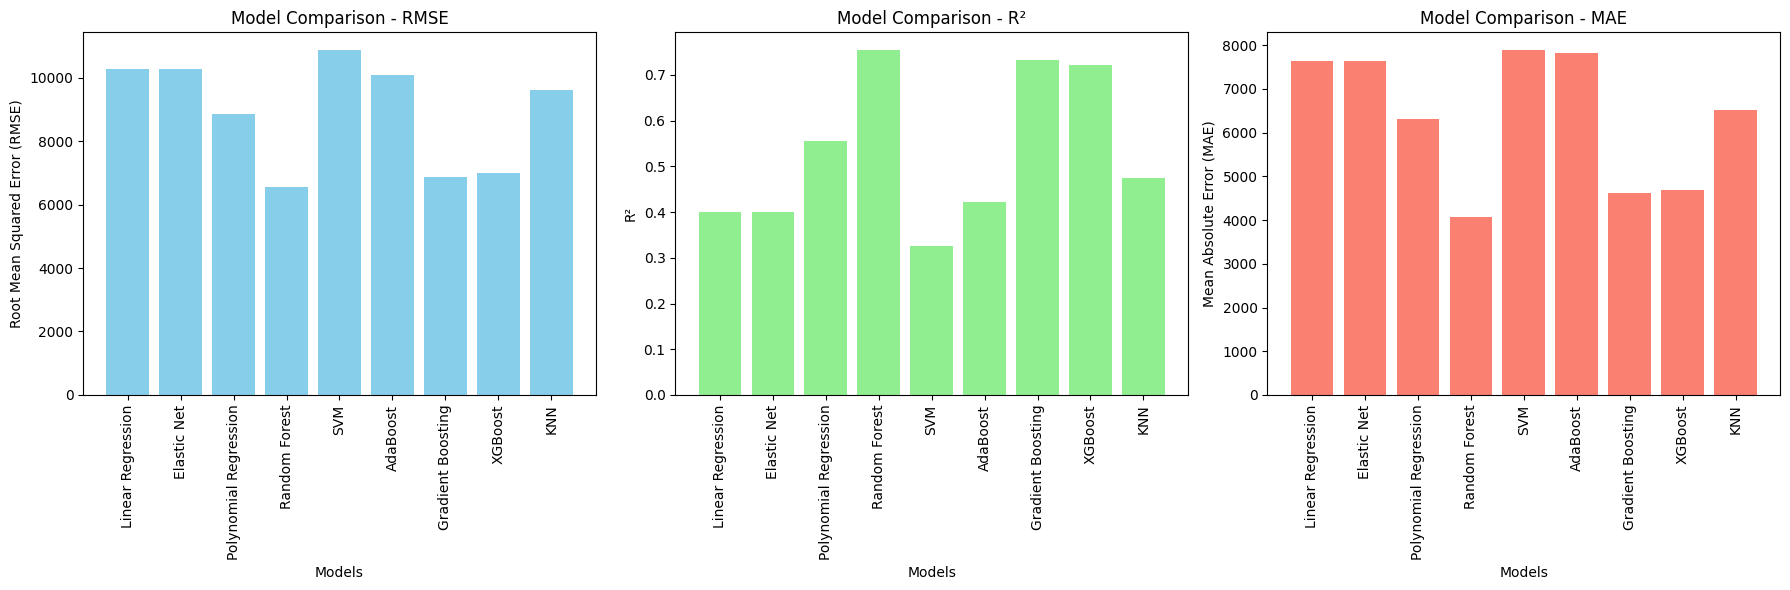

In [ ]:
# Afficher les résultats
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R2 = {scores['R2']:.4f}, MAE = {scores['MAE']:.4f}")
print('****************')
# Comparaison graphique des métriques
plt.figure(figsize=(18, 6))

# RMSE
plt.subplot(1, 3, 1)
model_names = list(results.keys())
rmse_scores = [scores['RMSE'] for scores in results.values()]
plt.bar(model_names, rmse_scores, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=90)

# R2
plt.subplot(1, 3, 2)
r2_scores = [scores['R2'] for scores in results.values()]
plt.bar(model_names, r2_scores, color='lightgreen')
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model Comparison - R²")
plt.xticks(rotation=90)

# MAE
plt.subplot(1, 3, 3)
mae_scores = [scores['MAE'] for scores in results.values()]
plt.bar(model_names, mae_scores, color='salmon')
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


                   Model     Test RMSE   Test R2     Test MAE
3          Random Forest   6571.796197  0.758187  3987.548850
7                XGBoost   6970.607437  0.727948  4647.931313
6      Gradient Boosting   7031.253893  0.723193  4638.601870
2  Polynomial Regression   9255.221528  0.520394  6496.422907
8                    KNN  10202.503835  0.417193  6768.136179
5               AdaBoost  10267.738184  0.409717  8029.115398
0      Linear Regression  10410.693939  0.393165  7772.624977
1            Elastic Net  10411.263907  0.393099  7763.323865
4                    SVM  11077.206626  0.312977  8061.833792
***************


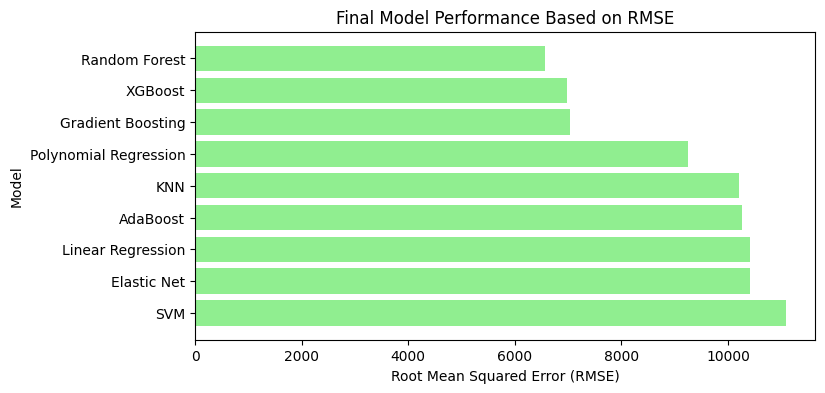

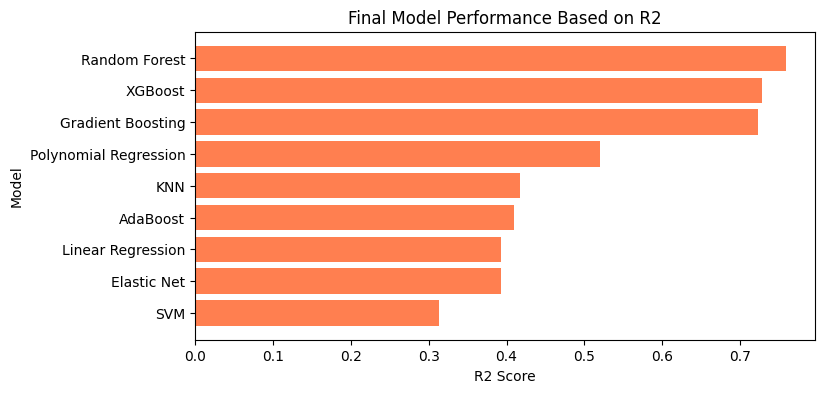

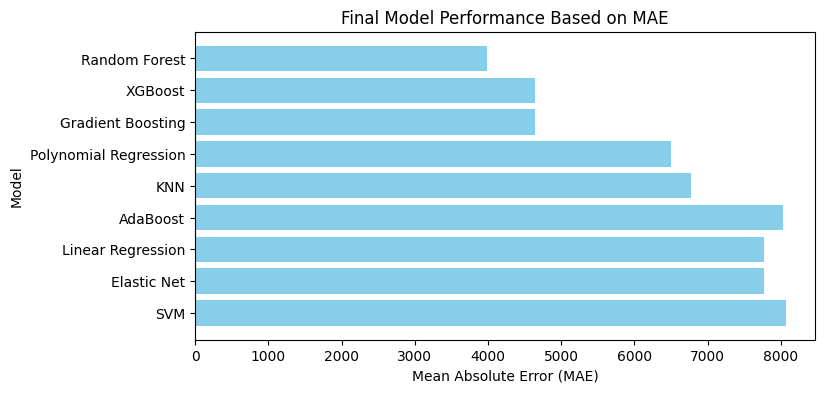

In [ ]:

# Préparer les données de test
X_test = df_test  # Adapter pour correspondre à tes données
y_test = target_test  # Adapter pour correspondre à tes données
#X_test_prepared = preprocessor.fit_transform(X_test)

# Stocker les résultats finaux
final_results = []

models = {
    "Linear Regression": gs_LinearRegression,
    "Elastic Net": gs_elastic_Net,
    "Polynomial Regression": gs_polynomial_regression,
    "Random Forest": gs_RandomForest,
    "SVM": gs_SVM,
    "AdaBoost": gs_AdaBoost,
    "Gradient Boosting": gs_GradientBoosting,
    "XGBoost": gs_XGBoost,
    "KNN": gs_KNN
}

# Itérer sur les modèles pour récupérer les scores
for name, gs in models.items():
    # Récupérer le meilleur modèle
    final_model = gs.best_estimator_

    # Effectuer des prédictions sur le jeu de test
    final_predictions = final_model.predict(X_test)

    # Calculer les métriques
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    final_r2 = r2_score(y_test, final_predictions)
    final_mae = mean_absolute_error(y_test, final_predictions)

    # Ajouter les résultats
    final_results.append({
        "Model": name,
        "Test RMSE": final_rmse,
        "Test R2": final_r2,
        "Test MAE": final_mae
    })

# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Afficher les résultats triés par RMSE croissant
final_results_df = final_results_df.sort_values(by="Test RMSE", ascending=True)
print(final_results_df)
print('***************')
# Visualiser les résultats
plt.figure(figsize=(8, 4))

# Barplot des RMSE
plt.barh(final_results_df["Model"], final_results_df["Test RMSE"], color="lightgreen")
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on RMSE")
plt.gca().invert_yaxis()
#plt.savefig("RMSE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des R2
plt.figure(figsize=(8, 4))
plt.barh(final_results_df["Model"], final_results_df["Test R2"], color="coral")
plt.xlabel("R2 Score")
plt.ylabel("Model")
plt.title("Final Model Performance Based on R2")
plt.gca().invert_yaxis()
#plt.savefig("R2_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des MAE
plt.figure(figsize=(8, 4))
plt.barh(final_results_df["Model"], final_results_df["Test MAE"], color="skyblue")
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on MAE")
plt.gca().invert_yaxis()
#plt.savefig("MAE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()


Meilleurs modèles :
           Model   RMSE_Score   Test R2   MAE_Score
3  Random Forest -6571.796197  0.758187 -3987.54885

Top 3 modèles :
               Model   RMSE_Score   Test R2    MAE_Score
3      Random Forest -6571.796197  0.758187 -3987.548850
7            XGBoost -6970.607437  0.727948 -4647.931313
6  Gradient Boosting -7031.253893  0.723193 -4638.601870
*************


<Figure size 600x600 with 0 Axes>

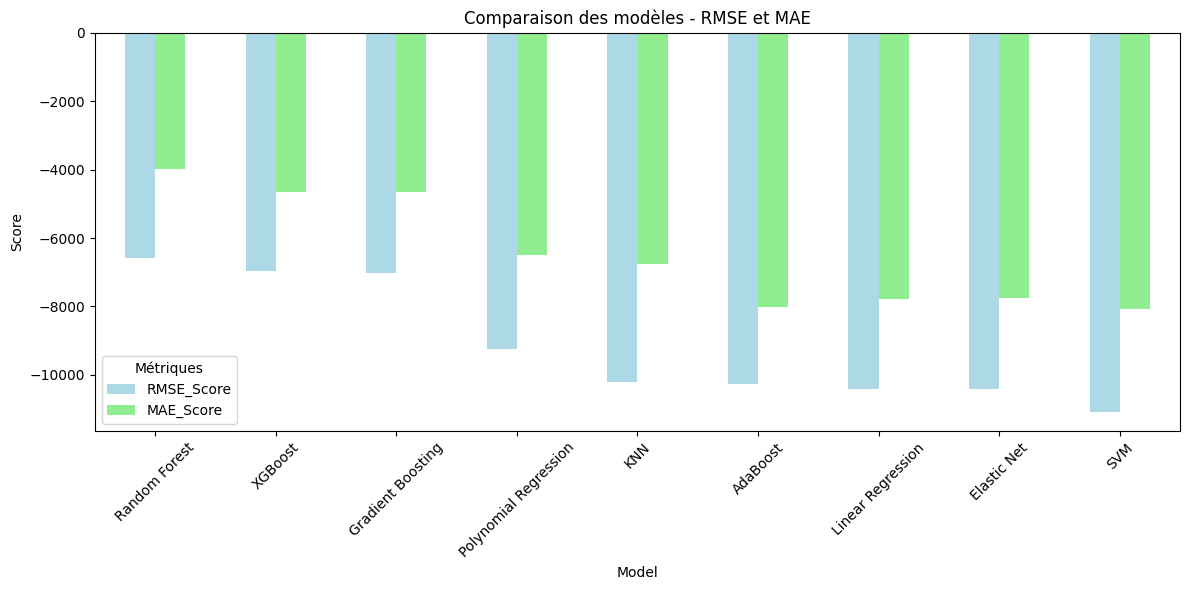

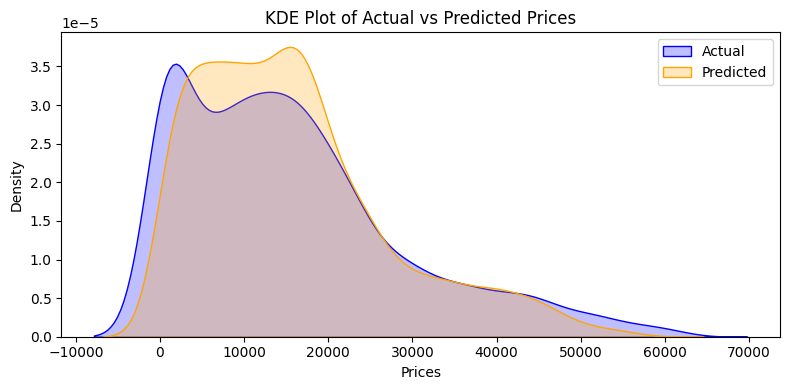

In [ ]:
# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Standardiser les scores pour le vote (inverse RMSE et MAE pour que les scores plus élevés soient meilleurs)
final_results_df['RMSE_Score'] = -final_results_df['Test RMSE']
final_results_df['MAE_Score'] = -final_results_df['Test MAE']

# Calculer le rang pour chaque métrique
final_results_df['Rank_RMSE'] = final_results_df['RMSE_Score'].rank(ascending=False)
final_results_df['Rank_R2'] = final_results_df['Test R2'].rank(ascending=False)
final_results_df['Rank_MAE'] = final_results_df['MAE_Score'].rank(ascending=False)

# Total des rangs
final_results_df['Total_Rank'] = final_results_df[['Rank_RMSE', 'Rank_R2', 'Rank_MAE']].sum(axis=1)

# Trier les résultats par rang total
final_results_df = final_results_df.sort_values(by='Total_Rank', ascending=True)

# Afficher le ou les meilleurs modèles
best_models = final_results_df[final_results_df['Total_Rank'] == final_results_df['Total_Rank'].min()]
print("Meilleurs modèles :")
print(best_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])

# Si plusieurs modèles ont le même rang, afficher les trois premiers
top_models = final_results_df.nsmallest(3, 'Total_Rank')
print("\nTop 3 modèles :")
print(top_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])
print('*************')
# Visualiser les performances
plt.figure(figsize=(6, 6))
final_results_df.set_index('Model')[['RMSE_Score', 'MAE_Score']].plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title("Comparaison des modèles - RMSE et MAE")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Métriques")
plt.tight_layout()
plt.show()

# KDE Plot - Meilleur modèle
best_model_name = best_models.iloc[0]['Model']
best_model = models[best_model_name].best_estimator_

# Prédictions du meilleur modèle
y_pred_best = best_model.predict(X_test)

# Créer un DataFrame pour la visualisation
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

# KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.kdeplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
x_min = min(plot_data['Actual'].min(), plot_data['Predicted'].min())
x_max = max(plot_data['Actual'].max(), plot_data['Predicted'].max())
plt.xlim(x_min, x_max + 5)  # Ajouter une marge de 5 unités
plt.savefig("Kde_ActualvsPredicted_random_forest_vf_target.tiff", format="tiff", dpi=300)
plt.show()


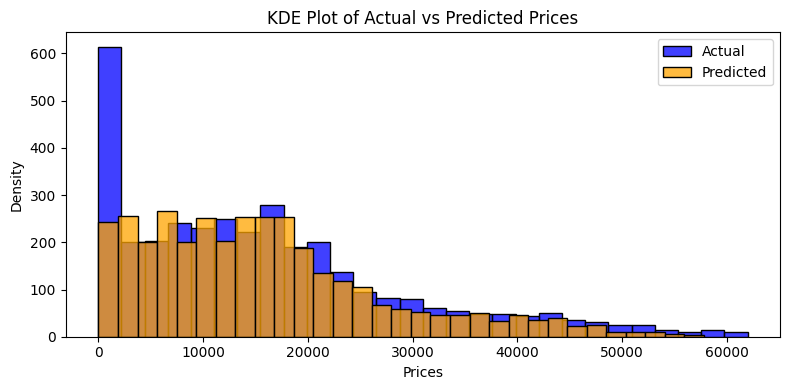

In [ ]:
# KDE plot
plt.figure(figsize=(8, 4))
sns.histplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.histplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
#plt.savefig("Hist_ActualvsPredicted_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

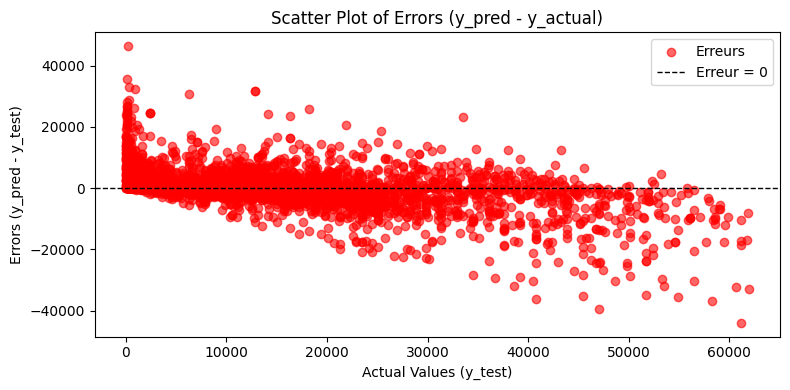

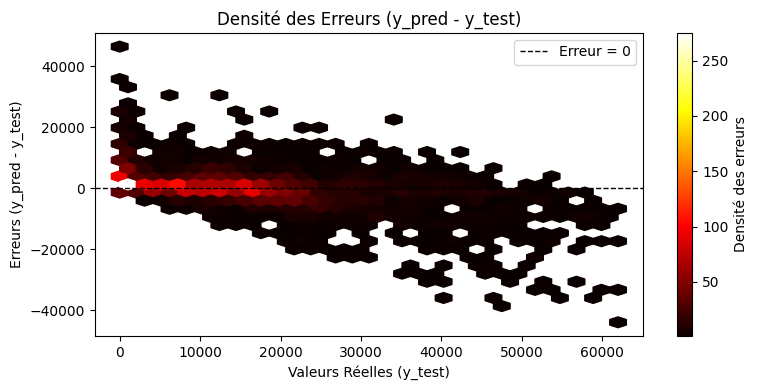

In [ ]:
# Calculer les erreurs
errors = y_pred_best - y_test

# Créer un scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(y_test, errors, alpha=0.6, color='red', label='Erreurs')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')
plt.title('Scatter Plot of Errors (y_pred - y_actual)')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Errors (y_pred - y_test)')
plt.legend()
plt.tight_layout()
#plt.savefig("Scatter_error_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()



# Créer un hexbin plot pour les erreurs
plt.figure(figsize=(8, 4))
plt.hexbin(y_test, errors, gridsize=30, cmap='hot', mincnt=1)  # gridsize ajuste la taille des hexagones
plt.colorbar(label='Densité des erreurs')

# Ajouter une ligne pour l'erreur nulle
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')

# Ajouter des labels et un titre
plt.title('Densité des Erreurs (y_pred - y_test)')
plt.xlabel('Valeurs Réelles (y_test)')
plt.ylabel('Erreurs (y_pred - y_test)')
plt.legend()
plt.tight_layout()
plt.show()

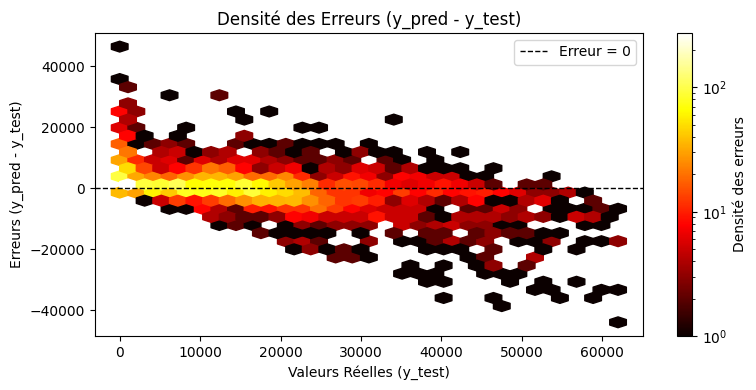

In [ ]:
# Créer un hexbin plot pour les erreurs
plt.figure(figsize=(8, 4))
plt.hexbin(y_test, errors, gridsize=30, cmap='hot', mincnt=1,bins='log')  # gridsize ajuste la taille des hexagones
plt.colorbar(label='Densité des erreurs')

# Ajouter une ligne pour l'erreur nulle
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')

# Ajouter des labels et un titre
plt.title('Densité des Erreurs (y_pred - y_test)')
plt.xlabel('Valeurs Réelles (y_test)')
plt.ylabel('Erreurs (y_pred - y_test)')
plt.legend()
plt.tight_layout()
plt.show()

#####**Mixing both Target Encoding and one Hot Encoding**

In [ ]:
preprocessor = preprocessor_mixed_onehot_target

######**Same code as before**

In [ ]:
#  Numerical & Categorical Training
# ---------------------

# Pipelines

# Pipelines pour chaque modèle avec le préprocesseur
pipeline_LinearRegression = Pipeline([
    ('preprocessor', preprocessor),
    ('linearregression', LinearRegression())
])

pipeline_elastic_Net = Pipeline([
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet())
])

pipeline_polynomial_regression = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('target_encoding', TargetEncoder(cv=3,target_type='continuous'), categorical_target_encoding),
        ('onehot_encoding', OneHotEncoder(handle_unknown='ignore', max_categories = 30), categorical_onehot_encoding),
        ('num', Pipeline([
            ('scaler', StandardScaler()),  # Normalisation des données numériques
            ('polynomial_features', PolynomialFeatures())  # Ajout des termes polynomiaux
        ]), numerical_features)
    ])),
    ('linearregression', LinearRegression())  # Régression linéaire après transformation
])

pipeline_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])

pipeline_SVM = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour les SVM
    ('svr', SVR())
])

pipeline_AdaBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('adaboostregressor', AdaBoostRegressor(random_state=42))
])

pipeline_GradientBoosting = Pipeline([
    ('preprocessor', preprocessor),
    ('gradientboostingregressor', GradientBoostingRegressor(random_state=42))
])

pipeline_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

pipeline_KNN = Pipeline([
    ('preprocessor', preprocessor),  # StandardScaler nécessaire pour KNN
    ('kneighborsregressor', KNeighborsRegressor())
])

# Liste de tous les pipelines
pipelines = {
    'Linear Regression': pipeline_LinearRegression,
    'Elastic Net': pipeline_elastic_Net,
    'Polynomial Regression': pipeline_polynomial_regression,
    'Random Forest': pipeline_RandomForest,
    'SVM': pipeline_SVM,
    'AdaBoost': pipeline_AdaBoost,
    'Gradient Boosting': pipeline_GradientBoosting,
    'XGBoost': pipeline_XGBoost,
    'KNN': pipeline_KNN
}


# Créer les GridSearchCV pour chaque modèle en utilisant le même KFold
gs_LinearRegression = GridSearchCV(pipeline_LinearRegression, param_grid_LinearRegression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_elastic_Net = GridSearchCV(pipeline_elastic_Net, param_grid_elastic_Net, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_polynomial_regression = GridSearchCV(pipeline_polynomial_regression, param_grid_polynomial_regression, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_RandomForest = GridSearchCV(pipeline_RandomForest, param_grid_RandomForest, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_SVM = GridSearchCV(pipeline_SVM, param_grid_SVM, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_AdaBoost = GridSearchCV(pipeline_AdaBoost, param_grid_AdaBoost, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_GradientBoosting = GridSearchCV(pipeline_GradientBoosting, param_grid_GradientBoosting, cv=kf, scoring=scoring,refit='RMSE',n_jobs=-1)
gs_XGBoost = GridSearchCV(pipeline_XGBoost,param_grid_XGBoost,cv=kf,scoring=scoring,refit='RMSE',n_jobs=-1)
gs_KNN = GridSearchCV(pipeline_KNN, param_grid_KNN, cv=kf, scoring=scoring, refit='RMSE',n_jobs=-1)

# Ajuster les modèles
gs_LinearRegression.fit(df_train, target_train)
print('Linear Done')
gs_elastic_Net.fit(df_train, target_train)
print('Elastic Net Done')
gs_polynomial_regression.fit(df_train, target_train)
print('Polynomial Done')

gs_RandomForest.fit(df_train, target_train)
print('RandomForest Done')
gs_SVM.fit(df_train, target_train)
print('SVM Done')
gs_AdaBoost.fit(df_train, target_train)
print('AdaBoost Done')

gs_GradientBoosting.fit(df_train, target_train)
print('Gradient Boosting Done')
gs_XGBoost.fit(df_train, target_train)
print('XGBoost Done')
gs_KNN.fit(df_train, target_train)
print('KNN Done')

results = {
    "Linear Regression": {
        "RMSE": -gs_LinearRegression.best_score_,
        "R2": gs_LinearRegression.cv_results_['mean_test_R2'][gs_LinearRegression.best_index_],
        "MAE": -gs_LinearRegression.cv_results_['mean_test_MAE'][gs_LinearRegression.best_index_]
    },
    "Elastic Net": {
        "RMSE": -gs_elastic_Net.best_score_,
        "R2": gs_elastic_Net.cv_results_['mean_test_R2'][gs_elastic_Net.best_index_],
        "MAE": -gs_elastic_Net.cv_results_['mean_test_MAE'][gs_elastic_Net.best_index_]
    },
    "Polynomial Regression": {
        "RMSE": -gs_polynomial_regression.best_score_,
        "R2": gs_polynomial_regression.cv_results_['mean_test_R2'][gs_polynomial_regression.best_index_],
        "MAE": -gs_polynomial_regression.cv_results_['mean_test_MAE'][gs_polynomial_regression.best_index_]
    },
    "Random Forest": {
        "RMSE": -gs_RandomForest.best_score_,
        "R2": gs_RandomForest.cv_results_['mean_test_R2'][gs_RandomForest.best_index_],
        "MAE": -gs_RandomForest.cv_results_['mean_test_MAE'][gs_RandomForest.best_index_]
    },
    "SVM": {
        "RMSE": -gs_SVM.best_score_,
        "R2": gs_SVM.cv_results_['mean_test_R2'][gs_SVM.best_index_],
        "MAE": -gs_SVM.cv_results_['mean_test_MAE'][gs_SVM.best_index_]
    },
    "AdaBoost": {
        "RMSE": -gs_AdaBoost.best_score_,
        "R2": gs_AdaBoost.cv_results_['mean_test_R2'][gs_AdaBoost.best_index_],
        "MAE": -gs_AdaBoost.cv_results_['mean_test_MAE'][gs_AdaBoost.best_index_]
    },
    "Gradient Boosting": {
        "RMSE": -gs_GradientBoosting.best_score_,
        "R2": gs_GradientBoosting.cv_results_['mean_test_R2'][gs_GradientBoosting.best_index_],
        "MAE": -gs_GradientBoosting.cv_results_['mean_test_MAE'][gs_GradientBoosting.best_index_]
    },
    "XGBoost": {
        "RMSE": -gs_XGBoost.best_score_,
        "R2": gs_XGBoost.cv_results_['mean_test_R2'][gs_XGBoost.best_index_],
        "MAE": -gs_XGBoost.cv_results_['mean_test_MAE'][gs_XGBoost.best_index_]
    },
    "KNN": {
        "RMSE": -gs_KNN.best_score_,
        "R2": gs_KNN.cv_results_['mean_test_R2'][gs_KNN.best_index_],
        "MAE": -gs_KNN.cv_results_['mean_test_MAE'][gs_KNN.best_index_]
    }
}



Linear Done
Elastic Net Done
Polynomial Done
RandomForest Done
SVM Done
AdaBoost Done
Gradient Boosting Done
XGBoost Done
KNN Done


######**Results**

In [ ]:
# Print the best parameters for each model based on the RMSE score
print("Best Parameters for RMSE:")
print(f"Linear Regression (RMSE): {gs_LinearRegression.best_params_}")
print(f"Elastic Net (RMSE): {gs_elastic_Net.best_params_}")
print(f"Polynomial Regression (RMSE): {gs_polynomial_regression.best_params_}")
print(f"Random Forest (RMSE): {gs_RandomForest.best_params_}")
print(f"SVM (RMSE): {gs_SVM.best_params_}")
print(f"AdaBoost (RMSE): {gs_AdaBoost.best_params_}")
print(f"Gradient Boosting (RMSE): {gs_GradientBoosting.best_params_}")
print(f"XGBoost (RMSE): {gs_XGBoost.best_params_}")
print(f"KNN (RMSE): {gs_KNN.best_params_}")

Best Parameters for RMSE:
Linear Regression (RMSE): {}
Elastic Net (RMSE): {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Polynomial Regression (RMSE): {'linearregression__fit_intercept': False, 'preprocessor__num__polynomial_features__degree': 4}
Random Forest (RMSE): {'randomforestregressor__max_depth': 50, 'randomforestregressor__n_estimators': 25}
SVM (RMSE): {'svr__C': 0.1, 'svr__kernel': 'linear'}
AdaBoost (RMSE): {'adaboostregressor__learning_rate': 0.5, 'adaboostregressor__n_estimators': 25}
Gradient Boosting (RMSE): {'gradientboostingregressor__learning_rate': 0.1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__n_estimators': 25}
XGBoost (RMSE): {'xgbregressor__learning_rate': 0.5, 'xgbregressor__max_depth': 10, 'xgbregressor__n_estimators': 25}
KNN (RMSE): {'kneighborsregressor__n_neighbors': 11, 'kneighborsregressor__p': 1, 'kneighborsregressor__weights': 'uniform'}


Linear Regression: RMSE = 10094.1415, R2 = 0.4205, MAE = 7533.2765
Elastic Net: RMSE = 10086.9661, R2 = 0.4213, MAE = 7489.9432
Polynomial Regression: RMSE = 8682.1218, R2 = 0.5712, MAE = 6181.4405
Random Forest: RMSE = 6489.9461, R2 = 0.7601, MAE = 3934.2781
SVM: RMSE = 11191.4288, R2 = 0.2877, MAE = 8192.7103
AdaBoost: RMSE = 10156.2043, R2 = 0.4133, MAE = 7927.1001
Gradient Boosting: RMSE = 6894.4792, R2 = 0.7294, MAE = 4599.6329
XGBoost: RMSE = 6876.9960, R2 = 0.7305, MAE = 4317.3526
KNN: RMSE = 10269.0053, R2 = 0.3997, MAE = 7407.4973
****************


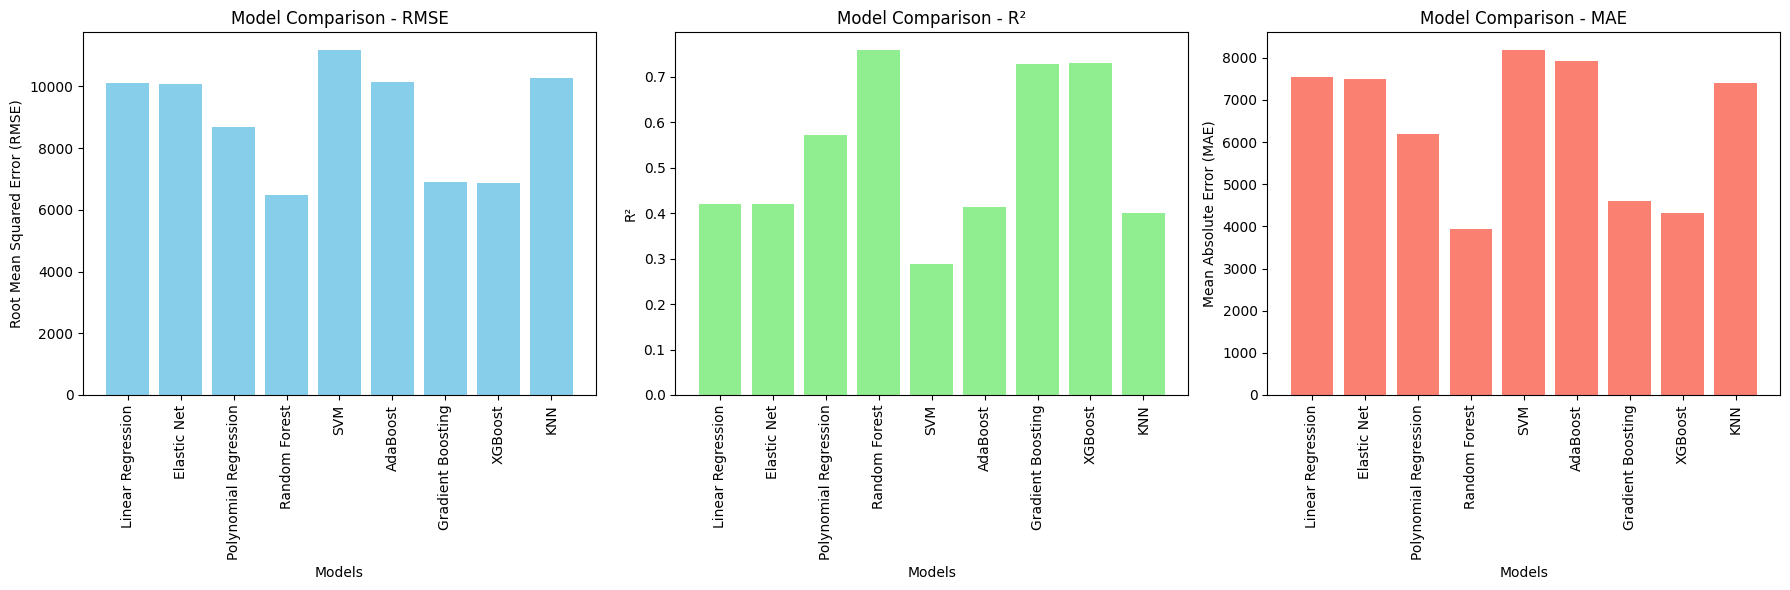

In [ ]:
# Afficher les résultats
for model, scores in results.items():
    print(f"{model}: RMSE = {scores['RMSE']:.4f}, R2 = {scores['R2']:.4f}, MAE = {scores['MAE']:.4f}")
print('****************')
# Comparaison graphique des métriques
plt.figure(figsize=(18, 6))

# RMSE
plt.subplot(1, 3, 1)
model_names = list(results.keys())
rmse_scores = [scores['RMSE'] for scores in results.values()]
plt.bar(model_names, rmse_scores, color='skyblue')
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Model Comparison - RMSE")
plt.xticks(rotation=90)

# R2
plt.subplot(1, 3, 2)
r2_scores = [scores['R2'] for scores in results.values()]
plt.bar(model_names, r2_scores, color='lightgreen')
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model Comparison - R²")
plt.xticks(rotation=90)

# MAE
plt.subplot(1, 3, 3)
mae_scores = [scores['MAE'] for scores in results.values()]
plt.bar(model_names, mae_scores, color='salmon')
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Model Comparison - MAE")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


                   Model     Test RMSE   Test R2     Test MAE
3          Random Forest   6559.912118  0.759061  3887.962561
6      Gradient Boosting   7044.969038  0.722112  4661.864008
7                XGBoost   7201.467924  0.709629  4553.436313
2  Polynomial Regression   9023.530170  0.544106  6285.464376
1            Elastic Net  10207.053137  0.416673  7594.946198
0      Linear Regression  10214.864413  0.415780  7634.291764
8                    KNN  10324.245558  0.403202  7446.907815
5               AdaBoost  10376.231183  0.397176  8191.310517
4                    SVM  11355.802009  0.277984  8349.465620
***************


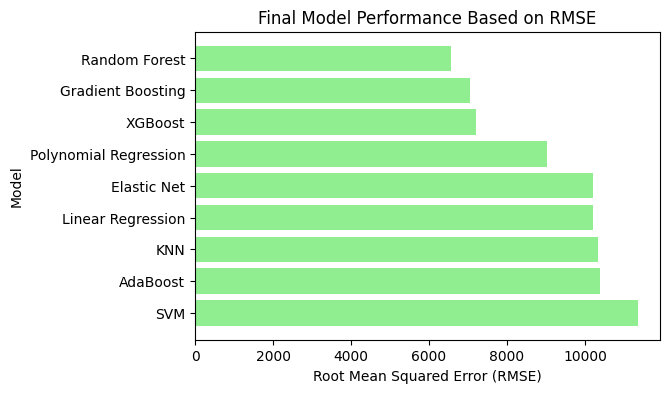

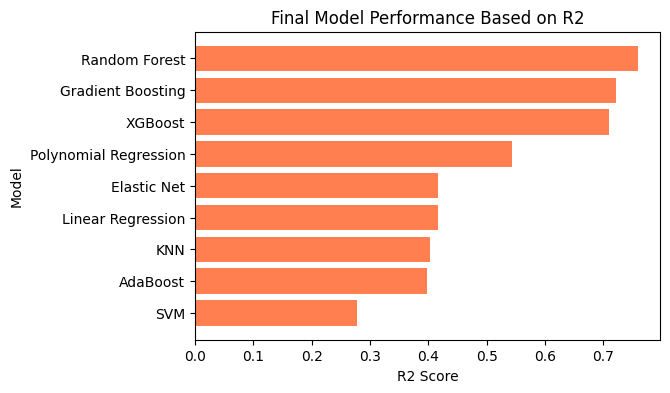

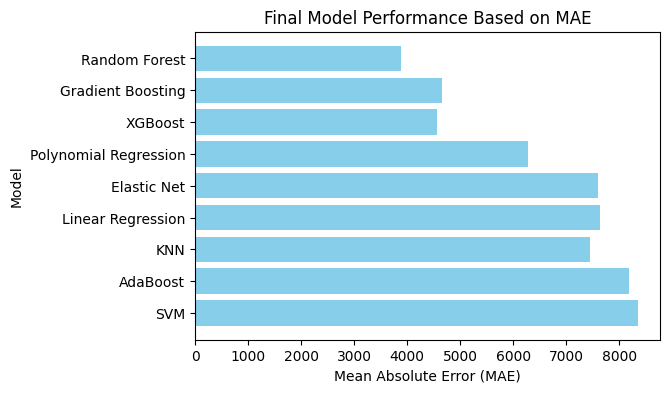

In [ ]:

# Préparer les données de test
X_test = df_test  # Adapter pour correspondre à tes données
y_test = target_test  # Adapter pour correspondre à tes données
#X_test_prepared = preprocessor.fit_transform(X_test)

# Stocker les résultats finaux
final_results = []

models = {
    "Linear Regression": gs_LinearRegression,
    "Elastic Net": gs_elastic_Net,
    "Polynomial Regression": gs_polynomial_regression,
    "Random Forest": gs_RandomForest,
    "SVM": gs_SVM,
    "AdaBoost": gs_AdaBoost,
    "Gradient Boosting": gs_GradientBoosting,
    "XGBoost": gs_XGBoost,
    "KNN": gs_KNN
}

# Itérer sur les modèles pour récupérer les scores
for name, gs in models.items():
    # Récupérer le meilleur modèle
    final_model = gs.best_estimator_

    # Effectuer des prédictions sur le jeu de test
    final_predictions = final_model.predict(X_test)

    # Calculer les métriques
    final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
    final_r2 = r2_score(y_test, final_predictions)
    final_mae = mean_absolute_error(y_test, final_predictions)

    # Ajouter les résultats
    final_results.append({
        "Model": name,
        "Test RMSE": final_rmse,
        "Test R2": final_r2,
        "Test MAE": final_mae
    })

# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Afficher les résultats triés par RMSE croissant
final_results_df = final_results_df.sort_values(by="Test RMSE", ascending=True)
print(final_results_df)
print('***************')
# Visualiser les résultats
plt.figure(figsize=(6, 4))

# Barplot des RMSE
plt.barh(final_results_df["Model"], final_results_df["Test RMSE"], color="lightgreen")
plt.xlabel("Root Mean Squared Error (RMSE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on RMSE")
plt.gca().invert_yaxis()
#plt.savefig("RMSE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des R2
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test R2"], color="coral")
plt.xlabel("R2 Score")
plt.ylabel("Model")
plt.title("Final Model Performance Based on R2")
plt.gca().invert_yaxis()
#plt.savefig("R2_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

# Barplot des MAE
plt.figure(figsize=(6, 4))
plt.barh(final_results_df["Model"], final_results_df["Test MAE"], color="skyblue")
plt.xlabel("Mean Absolute Error (MAE)")
plt.ylabel("Model")
plt.title("Final Model Performance Based on MAE")
plt.gca().invert_yaxis()
#plt.savefig("MAE_results_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()


Meilleurs modèles :
           Model   RMSE_Score   Test R2    MAE_Score
3  Random Forest -6559.912118  0.759061 -3887.962561

Top 3 modèles :
               Model   RMSE_Score   Test R2    MAE_Score
3      Random Forest -6559.912118  0.759061 -3887.962561
6  Gradient Boosting -7044.969038  0.722112 -4661.864008
7            XGBoost -7201.467924  0.709629 -4553.436313
*************


<Figure size 600x600 with 0 Axes>

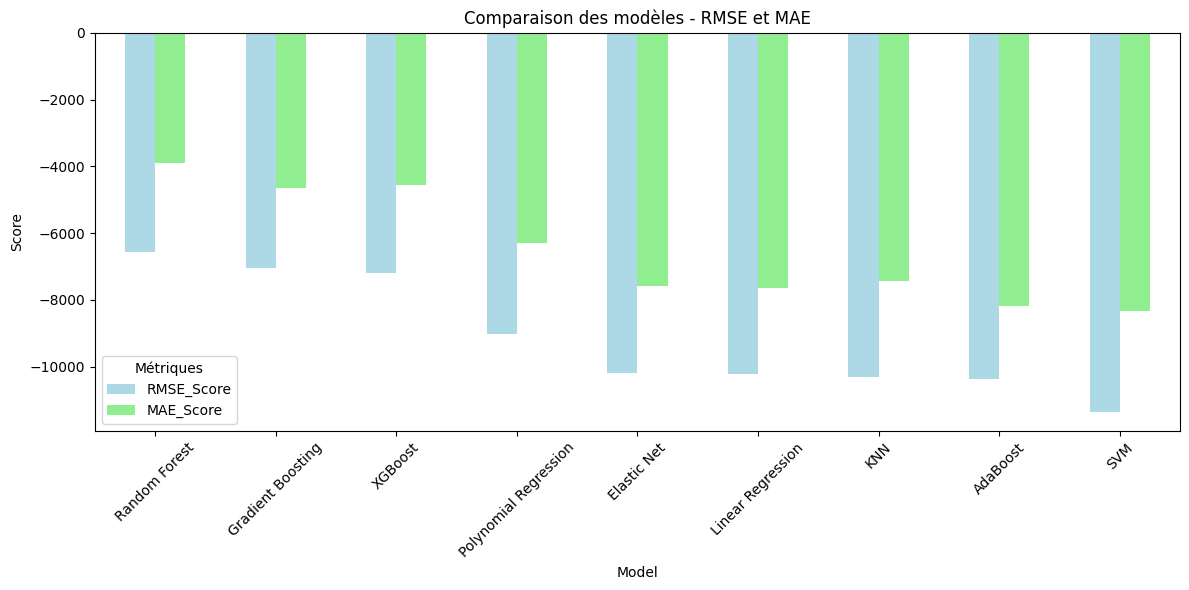

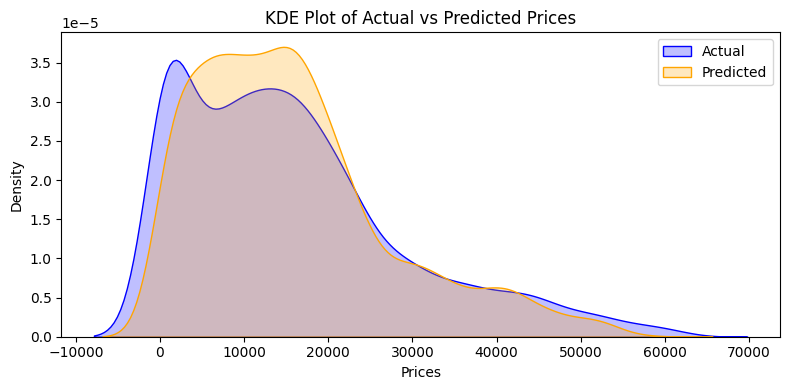

In [ ]:
# Convertir les résultats en DataFrame
final_results_df = pd.DataFrame(final_results)

# Standardiser les scores pour le vote (inverse RMSE et MAE pour que les scores plus élevés soient meilleurs)
final_results_df['RMSE_Score'] = -final_results_df['Test RMSE']
final_results_df['MAE_Score'] = -final_results_df['Test MAE']

# Calculer le rang pour chaque métrique
final_results_df['Rank_RMSE'] = final_results_df['RMSE_Score'].rank(ascending=False)
final_results_df['Rank_R2'] = final_results_df['Test R2'].rank(ascending=False)
final_results_df['Rank_MAE'] = final_results_df['MAE_Score'].rank(ascending=False)

# Total des rangs
final_results_df['Total_Rank'] = final_results_df[['Rank_RMSE', 'Rank_R2', 'Rank_MAE']].sum(axis=1)

# Trier les résultats par rang total
final_results_df = final_results_df.sort_values(by='Total_Rank', ascending=True)

# Afficher le ou les meilleurs modèles
best_models = final_results_df[final_results_df['Total_Rank'] == final_results_df['Total_Rank'].min()]
print("Meilleurs modèles :")
print(best_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])

# Si plusieurs modèles ont le même rang, afficher les trois premiers
top_models = final_results_df.nsmallest(3, 'Total_Rank')
print("\nTop 3 modèles :")
print(top_models[['Model', 'RMSE_Score', 'Test R2', 'MAE_Score']])
print('*************')
# Visualiser les performances
plt.figure(figsize=(6, 6))
final_results_df.set_index('Model')[['RMSE_Score', 'MAE_Score']].plot(kind='bar', figsize=(12, 6), color=['lightblue', 'lightgreen'])
plt.title("Comparaison des modèles - RMSE et MAE")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Métriques")
plt.tight_layout()
plt.show()

# KDE Plot - Meilleur modèle
best_model_name = best_models.iloc[0]['Model']
best_model = models[best_model_name].best_estimator_

# Prédictions du meilleur modèle
y_pred_best = best_model.predict(X_test)

# Créer un DataFrame pour la visualisation
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_best})

# KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.kdeplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
x_min = min(plot_data['Actual'].min(), plot_data['Predicted'].min())
x_max = max(plot_data['Actual'].max(), plot_data['Predicted'].max())
plt.xlim(x_min, x_max + 5)  # Ajouter une marge de 5 unités
plt.savefig("Kde_ActualvsPredicted_random_forest_vf_targetANDonehot.tiff", format="tiff", dpi=300)
plt.show()


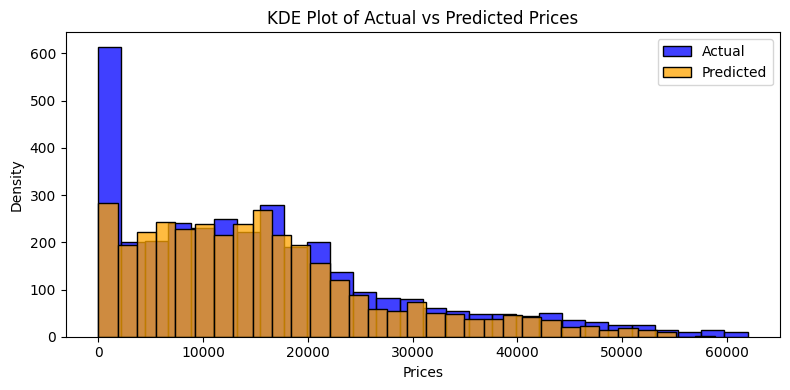

In [ ]:
# KDE plot
plt.figure(figsize=(8, 4))
sns.histplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.histplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
#plt.savefig("Hist_ActualvsPredicted_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()

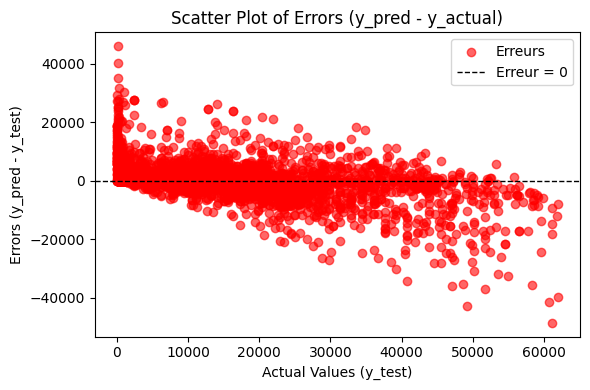

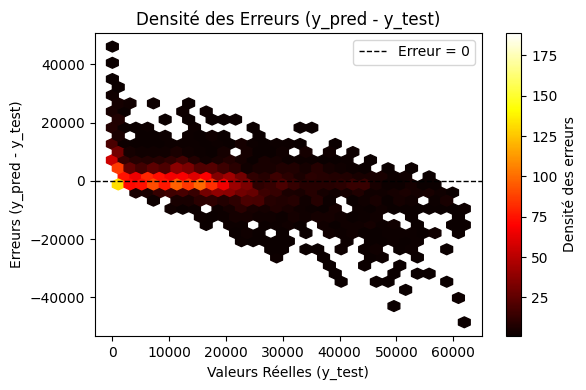

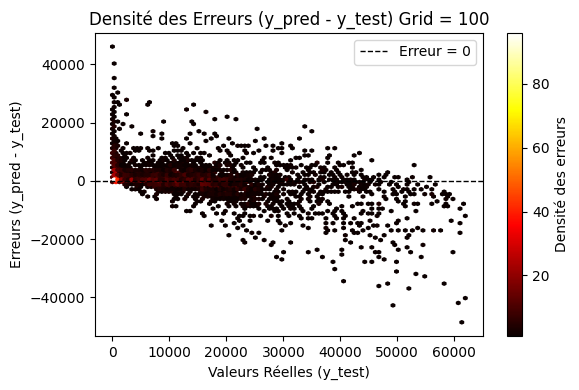

In [ ]:
# Calculer les erreurs
errors = y_pred_best - y_test

# Créer un scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, errors, alpha=0.6, color='red', label='Erreurs')
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')
plt.title('Scatter Plot of Errors (y_pred - y_actual)')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Errors (y_pred - y_test)')
plt.legend()
plt.tight_layout()
#plt.savefig("Scatter_error_random_forest_v1.tiff", format="tiff", dpi=300)
plt.show()



# Créer un hexbin plot pour les erreurs
plt.figure(figsize=(6, 4))
plt.hexbin(y_test, errors, gridsize=30, cmap='hot', mincnt=1)  # gridsize ajuste la taille des hexagones
plt.colorbar(label='Densité des erreurs')

# Ajouter une ligne pour l'erreur nulle
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Erreur = 0')

# Ajouter des labels et un titre
plt.title('Densité des Erreurs (y_pred - y_test)')
plt.xlabel('Valeurs Réelles (y_test)')
plt.ylabel('Erreurs (y_pred - y_test)')
plt.legend()
plt.tight_layout()
plt.show()


######**A short look over feature importance**

In [ ]:
#X_processed = preprocessor_mixed_onehot_target.fit_transform(df, target)
def get_transformed_feature_names(preprocessor, X_sample,y_sample):
    """
    Get the feature names created by the preprocessor after transformations.
    Parameters:
        preprocessor: The fitted preprocessor (ColumnTransformer).
        X_sample: A sample dataframe with the same structure as the training data.

    Returns:
        List of feature names after transformation.
    """
    # Fit the preprocessor on the sample
    preprocessor.fit_transform(X_sample,y_sample)

    feature_names = []

    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):  # For transformers like OneHotEncoder
            names = transformer.get_feature_names_out(columns)
            feature_names.extend(names)
        elif isinstance(transformer, TargetEncoder):  # For TargetEncoder (custom handling)
            feature_names.extend(columns)
        elif isinstance(transformer, StandardScaler):  # For StandardScaler
            feature_names.extend(columns)
        else:  # Other transformers (if any)
            feature_names.extend(columns)

    return feature_names

# Example usage:
# Assuming `X_train` is your training DataFrame
transformed_features = get_transformed_feature_names(preprocessor_mixed_onehot_target, df_train,target_train)


Top two features:
Age                        5037.374337
Gear box type_Automatic    4121.314352
dtype: float64
Top two features:
Age                        4682.168170
Gear box type_Automatic    3506.582909
dtype: float64
Top two features:
Model    0.305112
Age      0.170628
dtype: float64


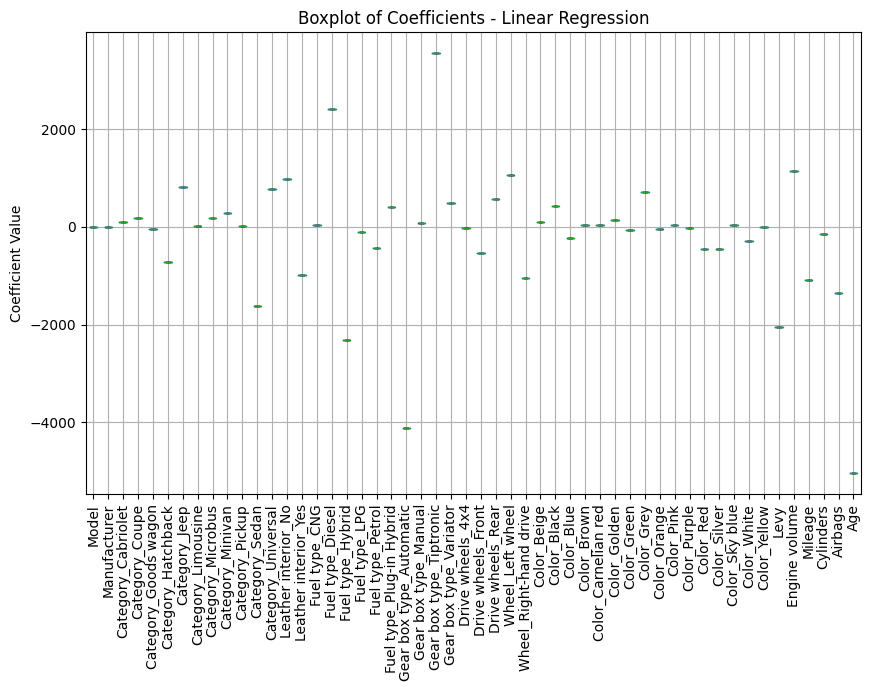

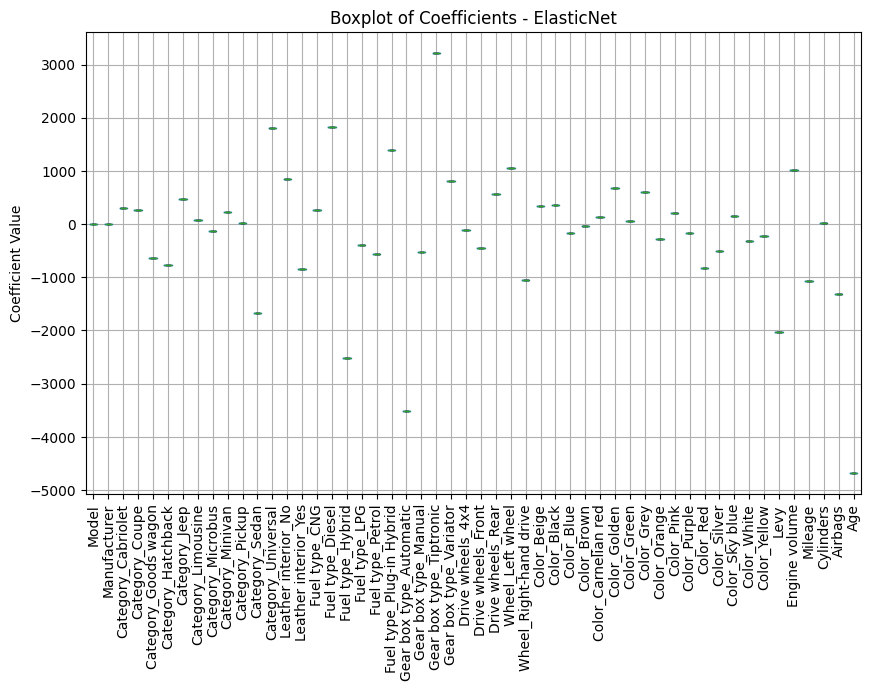

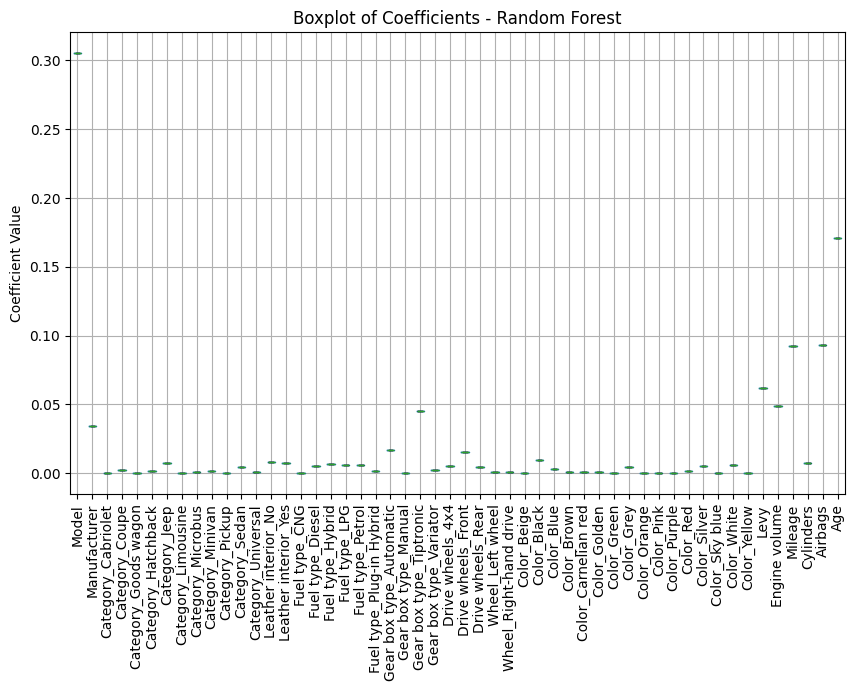

     Model  Manufacturer  Category_Cabriolet  Category_Coupe  \
0  0.60391      0.148244          101.042061      185.126349   

   Category_Goods wagon  Category_Hatchback  Category_Jeep  \
0            -46.615867         -717.522473     815.528491   

   Category_Limousine  Category_Microbus  Category_Minivan  ...  Color_Silver  \
0             12.7243         190.283694        291.328505  ...   -447.709774   

   Color_Sky blue  Color_White  Color_Yellow         Levy  Engine volume  \
0       42.281226  -293.764872    -13.447566 -2054.597612    1136.816838   

       Mileage   Cylinders      Airbags          Age  
0 -1083.402006 -146.263223 -1359.682727 -5037.374337  

[1 rows x 52 columns]


In [ ]:

# -------- 1. Coefficients pour LinearRegression et ElasticNet et RandomForest
def get_coefficients_from_gridsearch(gs, model_name,transformed_features=transformed_features):
    if model_name in ['Linear Regression', 'Elastic Net']:
        # Accéder au meilleur modèle de chaque GridSearch
        best_model = gs.best_estimator_
        # Vérifier que le modèle a un attribut coef_ (c'est-à-dire qu'il s'agit d'une régression linéaire ou ElasticNet)
        if hasattr(best_model[-1], 'coef_'):
            coefficients = best_model[-1].coef_
            coefficients_df = pd.DataFrame([coefficients], columns=transformed_features)
            return coefficients_df
    elif model_name == 'Random Forest':
      best_model = gs.best_estimator_
      # Extract the Random Forest model from the pipeline
      random_forest_model = best_model
      feature_importances = best_model[-1].feature_importances_
      coefficients_df = pd.DataFrame([feature_importances], columns=transformed_features)
      return coefficients_df
    return None

# Coefficients pour LinearRegression et ElasticNet
coeff_linear = get_coefficients_from_gridsearch(gs_LinearRegression, 'Linear Regression')
coeff_elastic = get_coefficients_from_gridsearch(gs_elastic_Net, 'Elastic Net')
coeff_random_forest = get_coefficients_from_gridsearch(gs_RandomForest, 'Random Forest')
# -------- 2. Calcul de la moyenne absolue des coefficients
def get_top_features(coefficients_df):
    # Calculer la moyenne des coefficients absolus
    mean_across_fold = coefficients_df.abs().mean()
    # Afficher les deux meilleures features en fonction de la moyenne absolue
    print(f"Top two features:\n{mean_across_fold.sort_values(ascending=False).head(2)}")
    return mean_across_fold

# Afficher les deux meilleures features pour chaque modèle
mean_linear = get_top_features(coeff_linear)
mean_elastic = get_top_features(coeff_elastic)
mean_random_forest = get_top_features(coeff_random_forest)

# -------- 3. Affichage des boxplots des coefficients
def plot_coefficients_boxplot(coefficients_df, title):
    plt.figure(figsize=(10, 6))
    coefficients_df.boxplot()
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylabel("Coefficient Value")
    plt.show()

# Tracer les boxplots pour LinearRegression et ElasticNet
plot_coefficients_boxplot(coeff_linear, "Boxplot of Coefficients - Linear Regression")
plot_coefficients_boxplot(coeff_elastic, "Boxplot of Coefficients - ElasticNet")
plot_coefficients_boxplot(coeff_random_forest, "Boxplot of Coefficients - Random Forest")

print(coeff_linear)


---

We can see Feature importance is model-based. Indeed the most important feature belongs to Gear type in case of linear regression whereas it is not the case with RandomForest which is the best model. Here the two most important feature was Model and Age.

---

####**Conclusion: Which methods of encoding is the best**

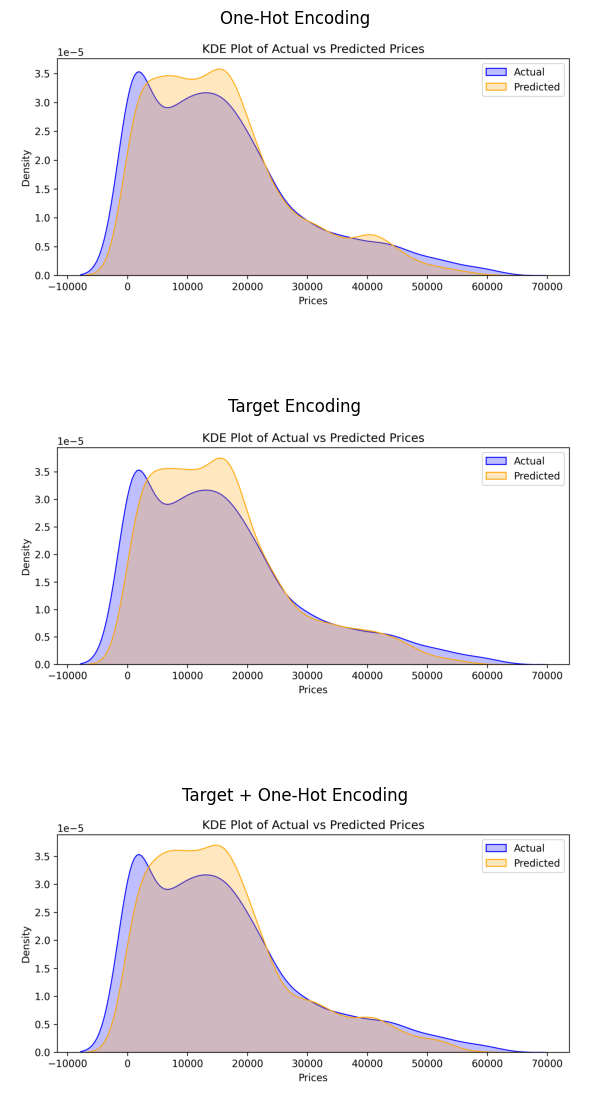

In [ ]:

# Load the images
img1 = plt.imread("Kde_ActualvsPredicted_random_forest_vf_onehot.tiff")
img2 = plt.imread("Kde_ActualvsPredicted_random_forest_vf_target.tiff")
img3 = plt.imread("Kde_ActualvsPredicted_random_forest_vf_targetANDonehot.tiff")

# Create a subplot with 1 column and 3 rows
fig, axs = plt.subplots(3, 1, figsize=(6, 12))  # 1 column, 3 rows

# Display each image in its subplot
axs[0].imshow(img1)
axs[0].axis('off')  # Hide axes
axs[0].set_title("One-Hot Encoding")

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title("Target Encoding")

axs[2].imshow(img3)
axs[2].axis('off')
axs[2].set_title("Target + One-Hot Encoding")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

---
In conclusion, The three methods lead to the same results and we can even conclude one hot encoding is better than the others even if it is a little bit more time-consuming. Their scores are 0.77, 0.75 and 0.75 respectively but we cannot really conclude one-hot enconding has been the best method as we have not checked the boxplot.

---

####**Stacking models**

In [ ]:
from sklearn.tree import DecisionTreeRegressor


# Prétraitement des données : application du ColumnTransformer
X_train = preprocessor.fit_transform(df_train,target_train)
X_test = preprocessor.transform(df_test)

#Best Parameters
best_params_KNN = gs_KNN.best_params_
best_params_XGBoost = gs_XGBoost.best_params_
best_params_RandomForest = gs_RandomForest.best_params_


# Modèles de base
model_1 = ('linear',LinearRegression())
model_2 = ('Tree',DecisionTreeRegressor(max_depth=best_params_RandomForest['randomforestregressor__max_depth']))
model_3 = ('Forest',RandomForestRegressor(max_depth=best_params_RandomForest['randomforestregressor__max_depth'],n_estimators=best_params_RandomForest['randomforestregressor__n_estimators'] ))
model_4 = ('KNN',KNeighborsRegressor(n_neighbors=best_params_KNN['kneighborsregressor__n_neighbors'],p=best_params_KNN['kneighborsregressor__n_neighbors'],weights=best_params_KNN['kneighborsregressor__weights'],metric='cosine')) #**best ne marche pas compte tenu de la definition dans le pipeline...
model_5 = ('xgb',XGBRegressor(learning_rate=best_params_XGBoost['xgbregressor__learning_rate'], max_depth=best_params_XGBoost['xgbregressor__max_depth'],n_estimators=best_params_XGBoost['xgbregressor__n_estimators']))
models = [model_1, model_2, model_3,model_4,model_5]
#models = [ model_3,model_4,model_5]


# Méta-modèles
meta_model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
meta_model_xgb = XGBRegressor(n_estimators=100, random_state=42)

# Fonction pour entraîner un modèle Stacking avec un méta-modèle spécifique
def train_stacking_model(meta_model, X_train, y_train, X_test, kf,models):
    # Créer un Stacking Regressor avec les modèles de base et le méta-modèle
    stacking_model = StackingRegressor(estimators=models,final_estimator=meta_model,cv=kf)
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    return y_pred


# Validation croisée pour générer les prédictions de base

def evaluate_model(y_true, y_pred):
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # R² (coefficient de détermination)
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, r2, mae

# Entraînement et prédiction avec le méta-modèle RandomForest
meta_model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred_rf = train_stacking_model(meta_model_rf, X_train, target_train, X_test, kf,models)

# Évaluation des performances de RandomForest avec RMSE, R², MAE
rmse_rf, r2_rf, mae_rf = evaluate_model(target_test, y_pred_rf)
print(f"RandomForest - RMSE: {rmse_rf}, R²: {r2_rf}, MAE: {mae_rf}")

# Entraînement et prédiction avec le méta-modèle XGBoost
meta_model_xgb = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
y_pred_xgb = train_stacking_model(meta_model_xgb, X_train, target_train, X_test, kf,models)

# Évaluation des performances de XGBoost avec RMSE, R², MAE
rmse_xgb, r2_xgb, mae_xgb = evaluate_model(target_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb}, R²: {r2_xgb}, MAE: {mae_xgb}")


RandomForest - RMSE: 6990.869332434071, R²: 0.726363906080762, MAE: 4248.975691083193
XGBoost - RMSE: 7031.295111059374, R²: 0.7231900691986084, MAE: 4299.666936995136


---

A stacking model using RandomForest , xgboost,KNN which was our best models before and using either a RandomForest and xgboost as metamodel does not succeed to go beyond the previous results. It is even worse.

---

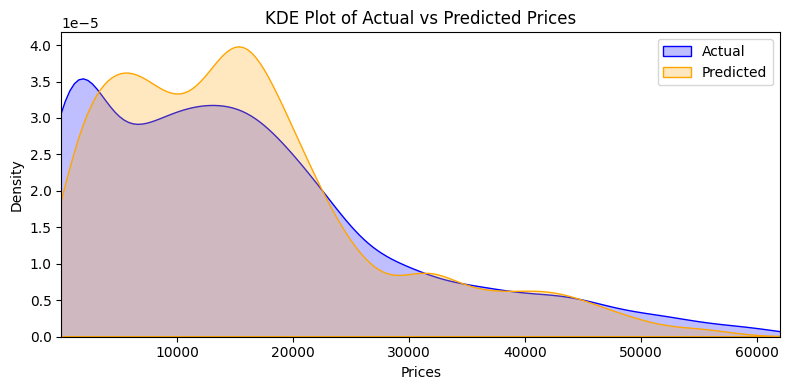

In [ ]:

# Créer un DataFrame pour la visualisation
plot_data = pd.DataFrame({'Actual': target_test, 'Predicted': y_pred_rf})

# KDE plot
plt.figure(figsize=(8, 4))
sns.kdeplot(data=plot_data, x='Actual', label='Actual', fill=True, common_norm=False, color='blue')
sns.kdeplot(data=plot_data, x='Predicted', label='Predicted', fill=True, common_norm=False, color='orange')
plt.title('KDE Plot of Actual vs Predicted Prices')
plt.xlabel('Prices')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
x_min = min(plot_data['Actual'].min(), plot_data['Predicted'].min())
x_max = max(plot_data['Actual'].max(), plot_data['Predicted'].max())
plt.xlim(x_min, x_max + 5)  # Ajouter une marge de 5 unités
plt.savefig("Kde_ActualvsPredicted_Stack_vf_targetANDonehot.tiff", format="tiff", dpi=300)
plt.show()


---
We observe the same patterns.

---

#Hyperparameters Tuning - A more Efficient Way

In [ ]:
preprocessor = preprocessor_mixed_onehot_target
# Random Forest hyperparameters

pipeline_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])


pipeline_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid_RandomForest = {
    'randomforestregressor__n_estimators': [50, 100],
    'randomforestregressor__max_depth': list(range(1, 50, 2)) + [None],
    'randomforestregressor__min_samples_split': list(range(2, 21, 2)),
    'randomforestregressor__min_samples_leaf': list(range(1, 21, 2)),
    'randomforestregressor__max_features': ['sqrt', 'log2', None],
    'randomforestregressor__bootstrap': [True, False]
}


# XGBoost hyperparameters
param_grid_XGBoost = {
    'xgbregressor__n_estimators': [50, 100],
    'xgbregressor__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'xgbregressor__max_depth': list(range(1, 21, 2)),  # Plus raisonnable (1 à 20)
    'xgbregressor__subsample': [0.5, 0.7, 0.9, 1.0],
    'xgbregressor__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'xgbregressor__gamma': [0, 0.1, 1, 5, 10],
    'xgbregressor__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'xgbregressor__reg_lambda': [0.01, 0.1, 1, 5, 10],
    'xgbregressor__max_leaf_nodes': list(range(2, 50, 5)) + [None],
    'xgbregressor__scale_pos_weight': [1, 10, 25, 50],  # Pour gérer le déséquilibre de classes
    'xgbregressor__min_child_weight': [1, 5, 10]
}


# Pipelines
pipeline_RandomForest = Pipeline([
    ('preprocessor', preprocessor),
    ('randomforestregressor', RandomForestRegressor(random_state=42))
])

pipeline_XGBoost = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbregressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# RandomizedSearchCV
random_search_RF = RandomizedSearchCV(
    pipeline_RandomForest,
    param_distributions=param_grid_RandomForest,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
)

random_search_XGB = RandomizedSearchCV(
    pipeline_XGBoost,
    param_distributions=param_grid_XGBoost,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=kf,
    random_state=42,
    n_jobs=-1
)

# Fit the models
random_search_RF.fit(df_train, target_train)
print("Random Forest tuning complete.")

random_search_XGB.fit(df_train, target_train)
print("XGBoost tuning complete.")


Random Forest tuning complete.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:00:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost tuning complete.


In [ ]:
# Convert results to DataFrame
rf_results = pd.DataFrame(random_search_RF.cv_results_)
xgb_results = pd.DataFrame(random_search_XGB.cv_results_)

# Extract relevant columns
rf_results = rf_results[['param_randomforestregressor__n_estimators',
                         'param_randomforestregressor__max_depth',
                         'param_randomforestregressor__min_samples_split',
                         'param_randomforestregressor__min_samples_leaf',
                         'mean_test_score']]
xgb_results = xgb_results[['param_xgbregressor__n_estimators',
                           'param_xgbregressor__learning_rate',
                           'param_xgbregressor__max_depth',
                           'param_xgbregressor__subsample',
                           'param_xgbregressor__colsample_bytree',
                           'param_xgbregressor__gamma',
                           'mean_test_score']]




<ipython-input-99-35fcc1df071d>:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


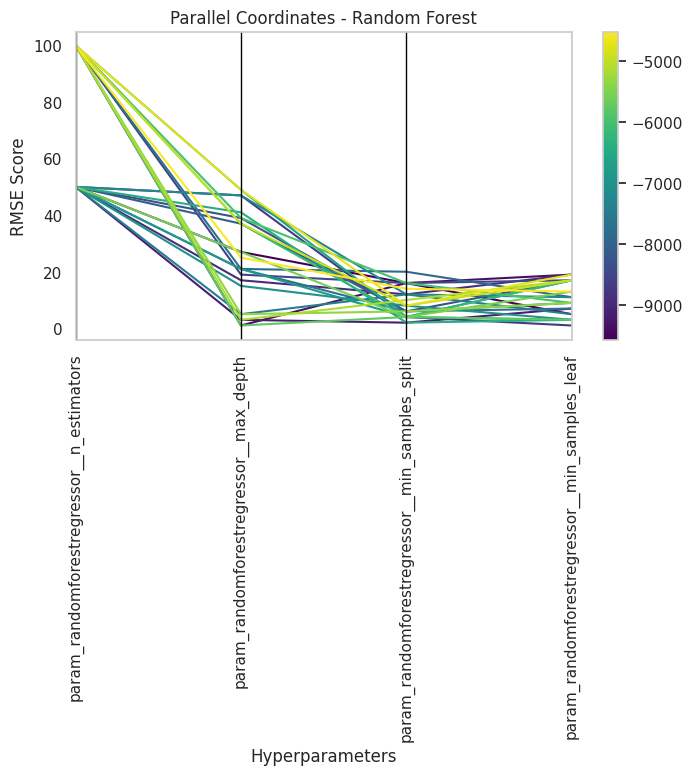

<ipython-input-99-35fcc1df071d>:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


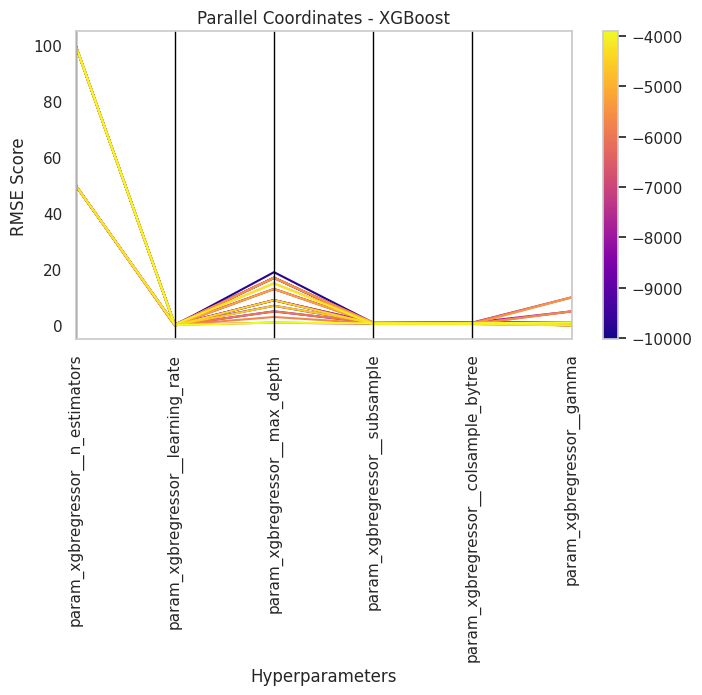

In [ ]:


# Tracer pour Random Forest
plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")

# Tracé parallèle des coordonnées avec coloration par 'mean_test_score'
parallel_coordinates(
    rf_results,  # Renommer pour affichage clair
    class_column='mean_test_score',
    colormap=plt.cm.viridis  # Colormap pour les scores
)
plt.title("Parallel Coordinates - Random Forest")
plt.xlabel("Hyperparameters")
plt.ylabel("RMSE Score")
plt.xticks(rotation=90)
plt.legend().set_visible(False)


# Normalisation des couleurs selon les scores
cmap = plt.cm.viridis
norm = plt.Normalize(rf_results['mean_test_score'].min(), rf_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Ceci est important pour la colorbar

# Ajouter la colorbar avec l'argument ax
plt.colorbar(sm, ax=plt.gca())  # Utiliser l'axe actuel (gca) pour la colorbar

plt.tight_layout()
plt.show()

# Tracer pour XGBoost
plt.figure(figsize=(8, 4))
parallel_coordinates(
    xgb_results,
    class_column='mean_test_score',
    colormap=plt.cm.plasma
)
plt.title("Parallel Coordinates - XGBoost")
plt.xlabel("Hyperparameters")
plt.ylabel("RMSE Score")
plt.xticks(rotation=90)
plt.legend().set_visible(False)

# Normalisation des couleurs selon les scores
cmap = plt.cm.plasma
norm = plt.Normalize(xgb_results['mean_test_score'].min(), xgb_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Ceci est important pour la colorbar

# Ajouter la colorbar avec l'argument ax
plt.colorbar(sm, ax=plt.gca())  # Utiliser l'axe actuel (gca) pour la colorbar

plt.tight_layout()
plt.show()


---

It takes 30 mintues to compute the code we should reduce the number of categories and be more selective to our features. However with this sample we couldn't find a better combinations that before.

---

#VERSIONING